In [1]:
from pcd_dataset import PointCloudDataset
from plane_detector import StructuralRANSAC
from semantic_segmentation import SemanticSegmentor
from pointnet_utils import PointnetInference
import yaml
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import nearest_points
import alphashape

In [2]:
FILE = "./data/full_scan.ply"

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
s_val = PointCloudDataset(FILE)

In [5]:
sem_seg = SemanticSegmentor(s_val, StructuralRANSAC, PointnetInference, config)

/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: divide by zero encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: overflow encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T
/Users/dmytroivanov/projects/o3d/pcd_dataset.py:351: RuntimeWarning: invalid value encountered in matmul
  points_xyz = points_xyz @ R_yup_to_zup.T


In [6]:
# sem_seg.visualize_pcd()

### Step 2: Detect Floor & Ceiling

In [7]:
sem_seg.ransac_segment()

Starting structural segmentation...
Detecting floor and ceiling...
  Floor found: 107809 points
  Ceiling found: 72271 points
Segmentation complete in 4.05 seconds
Found: 2 structural elements
  floor: 1
  ceiling: 1
Remaining unsegmented points: 413962


In [36]:
sem_seg.ransac_segmentor.visualize_segments()

PointCloud with 594042 points.

In [9]:
n = sem_seg.ransac_segmentor.segments["ceiling"]["plane"]["normal"]
target = np.array([0., 0., -1.])
angle = np.degrees(np.arccos(np.clip(np.abs(np.dot(n, target)), -1, 1)))
angle

np.float64(0.199221859151718)

### Step 3: Extract Wall Points

In [10]:
remainig_ind = sem_seg.ransac_segmentor.remaining_indices

In [11]:
points = sem_seg.points[remainig_ind]

In [12]:
def extract_wall_points(points, floor_height, ceiling_height, 
                       floor_margin=0.1, ceiling_margin=0.1):
    """
    Keep only points between floor and ceiling (potential walls)
    
    Args:
        points: Nx3 array
        floor_height: float
        ceiling_height: float
        floor_margin: Distance above floor to include (m)
        ceiling_margin: Distance below ceiling to include (m)
    
    Returns:
        wall_points: Filtered points
        wall_mask: Boolean mask
    """
    z_values = points[:, 2]
    
    wall_mask = (z_values > floor_height + floor_margin) & \
                (z_values < ceiling_height - ceiling_margin)
    
    wall_points = points[wall_mask]
    
    print(f"Original points: {len(points)}")
    print(f"Wall points: {len(wall_points)} ({100*len(wall_points)/len(points):.1f}%)")
    
    return wall_points, wall_mask

In [13]:
def visualize_wall_points(wall_points):
    """Visualize extracted wall points"""
    pcd_walls = o3d.geometry.PointCloud()
    pcd_walls.points = o3d.utility.Vector3dVector(wall_points)
    pcd_walls.paint_uniform_color([0, 1, 0])  # Green
    
    o3d.visualization.draw_geometries([pcd_walls], 
                                      window_name="Wall Points (Green)")

In [14]:
floor_h, ceiling_h = sem_seg.ransac_segmentor.get_floor_height(), sem_seg.ransac_segmentor.get_ceiling_height()

In [15]:
floor_h, ceiling_h

(np.float64(-1.4463912159055796), np.float64(1.1840834199936132))

In [16]:
wall_points, wall_mask = extract_wall_points(points[:, :3], floor_h, ceiling_h)

Original points: 413962
Wall points: 396961 (95.9%)


In [17]:
# visualize_wall_points(wall_points)

### Step 4: Filter Vertical Points

In [18]:
def compute_normals(points, radius=0.1, max_nn=30):
    """
    Compute normal vectors for each point
    
    Args:
        points: Nx3 array
        radius: Search radius for normal estimation
        max_nn: Max number of neighbors
    
    Returns:
        normals: Nx3 array of normal vectors
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=radius, 
            max_nn=max_nn
        )
    )
    
    # Orient normals consistently (optional but helpful)
    pcd.orient_normals_consistent_tangent_plane(k=15)
    
    normals = np.asarray(pcd.normals)
    
    print(f"Computed normals for {len(normals)} points")
    
    return normals, pcd

In [19]:
def filter_vertical_points(points, normals, vertical_threshold=0.1):
    """
    Keep only points with vertical normals (walls)
    
    Args:
        points: Nx3 array
        normals: Nx3 array
        vertical_threshold: Max abs(normal_z) for vertical surfaces
    
    Returns:
        vertical_points: Filtered points
        vertical_normals: Corresponding normals
        vertical_mask: Boolean mask
    """
    # Vertical surfaces have normals with small Z component
    normal_z = np.abs(normals[:, 2])
    vertical_mask = normal_z < vertical_threshold
    
    vertical_points = points[vertical_mask]
    vertical_normals = normals[vertical_mask]
    
    print(f"Wall points: {len(points)}")
    print(f"Vertical wall points: {len(vertical_points)} "
          f"({100*len(vertical_points)/len(points):.1f}%)")
    
    return vertical_points, vertical_normals, vertical_mask

In [20]:
normals, pcd_with_normals = compute_normals(wall_points)

Computed normals for 396961 points


In [21]:
vertical_points, vertical_normals, vert_mask = filter_vertical_points(
    wall_points, normals
)

Wall points: 396961
Vertical wall points: 240007 (60.5%)


In [22]:
pcd_vert = o3d.geometry.PointCloud()
pcd_vert.points = o3d.utility.Vector3dVector(vertical_points)
pcd_vert.normals = o3d.utility.Vector3dVector(vertical_normals)
pcd_vert.paint_uniform_color([1, 0, 1])  # Magenta
o3d.visualization.draw_geometries([pcd_vert], window_name="Vertical Wall Points")

### ROOM SEGMENTATION

#### Step 5: Create 2D Occupancy Grid

In [23]:
def create_2d_occupancy_grid(points, resolution=0.05):
    """
    Project wall points to 2D and create occupancy grid
    
    Args:
        points: Nx3 array (vertical wall points)
        resolution: Grid cell size in meters
    
    Returns:
        grid: 2D binary array (1=occupied, 0=free)
        origin: (min_x, min_y) for coordinate transform
        grid_size: (width, height) in cells
    """
    # Project to 2D (top-down view)
    points_2d = points[:, :2]  # Take only X, Y
    
    # Compute grid bounds
    min_x, min_y = points_2d.min(axis=0)
    max_x, max_y = points_2d.max(axis=0)
    
    # Add padding
    padding = 0.5  # meters
    min_x -= padding
    min_y -= padding
    max_x += padding
    max_y += padding
    
    # Calculate grid dimensions
    width = int(np.ceil((max_x - min_x) / resolution))
    height = int(np.ceil((max_y - min_y) / resolution))
    
    print(f"Grid size: {width} x {height} cells")
    print(f"Physical size: {max_x-min_x:.2f}m x {max_y-min_y:.2f}m")
    print(f"Resolution: {resolution}m/cell")
    
    # Create empty grid
    grid = np.zeros((height, width), dtype=np.uint8)
    
    # Fill grid with points
    for point in points_2d:
        # Convert to grid coordinates
        grid_x = int((point[0] - min_x) / resolution)
        grid_y = int((point[1] - min_y) / resolution)
        
        # Bounds check
        if 0 <= grid_x < width and 0 <= grid_y < height:
            grid[grid_y, grid_x] = 1
    
    origin = (min_x, min_y)
    grid_size = (width, height)
    
    occupied_cells = np.sum(grid)
    print(f"Occupied cells: {occupied_cells} ({100*occupied_cells/(width*height):.1f}%)")
    
    return grid, origin, resolution

In [24]:
def visualize_2d_grid(grid, title="Occupancy Grid"):
    """
    Visualize the 2D occupancy grid
    """
    plt.figure(figsize=(12, 10))
    plt.imshow(grid, cmap='binary', origin='lower')
    plt.title(title)
    plt.xlabel('X (grid cells)')
    plt.ylabel('Y (grid cells)')
    plt.colorbar(label='Occupied (1) / Free (0)')
    plt.tight_layout()
    plt.show()

Grid size: 201 x 294 cells
Physical size: 10.03m x 14.65m
Resolution: 0.05m/cell
Occupied cells: 6315 (10.7%)


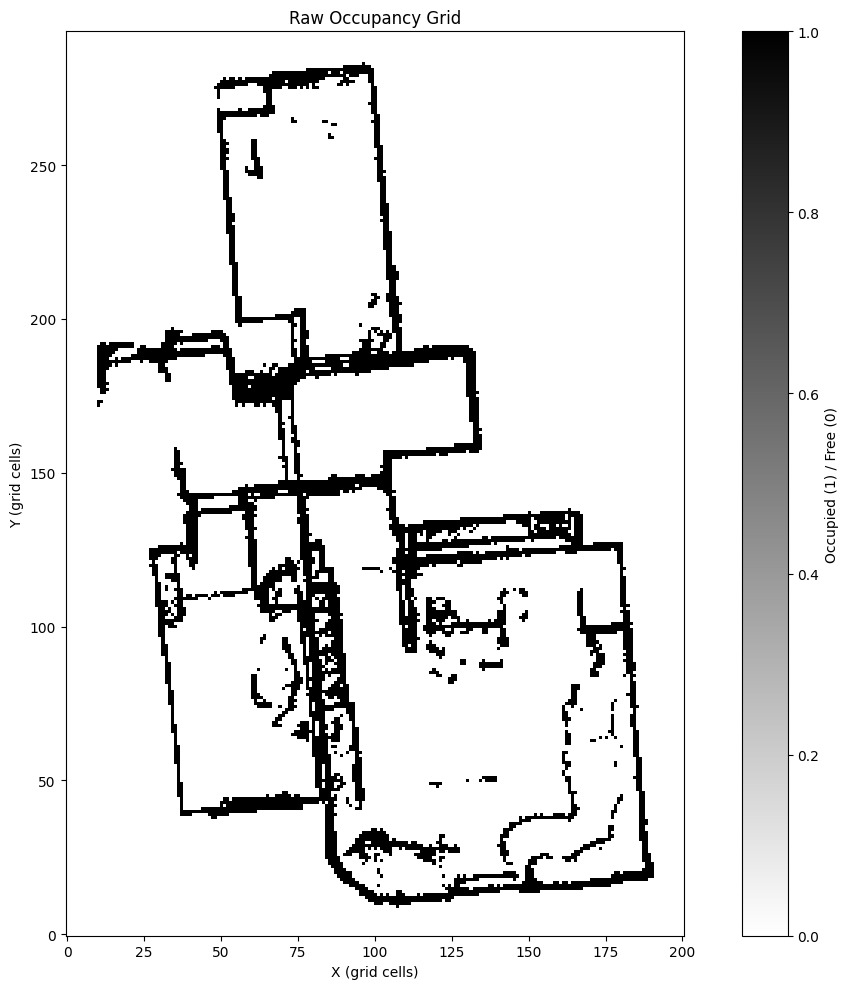

In [25]:
grid, origin, resolution = create_2d_occupancy_grid(vertical_points, resolution=0.05)
visualize_2d_grid(grid, "Raw Occupancy Grid")

#### Step 6: Segment Rooms

In [26]:
def visualize_rooms(room_labels):
    """
    Visualize segmented rooms with different colors
    """
    plt.figure(figsize=(12, 10))
    
    # Use a colormap that shows distinct colors per room
    cmap = plt.cm.get_cmap('tab20', room_labels.max() + 1)
    
    plt.imshow(room_labels, cmap=cmap, origin='lower', interpolation='nearest')
    plt.title(f'Room Segmentation ({room_labels.max()} rooms)')
    plt.xlabel('X (grid cells)')
    plt.ylabel('Y (grid cells)')
    
    # Add colorbar with room numbers
    cbar = plt.colorbar(ticks=range(room_labels.max() + 1))
    cbar.set_label('Room ID')
    
    plt.tight_layout()
    plt.show()

In [27]:
def segment_rooms(grid, resolution=0.05,
                    door_size_cells=20,
                    wall_dilation=4,
                    min_distance=30,
                    min_room_size=500,
                    exclude_border=True):
  
    from skimage import morphology
    from scipy.ndimage import label as nd_label, distance_transform_edt
    from skimage.feature import peak_local_max
    from skimage.segmentation import watershed
    
    # closing doors
    kernel = morphology.disk(door_size_cells // 2)
    closed_grid = morphology.binary_closing(grid, kernel).astype(np.uint8)
    
    # dilating walls
    kernel_dilate = morphology.disk(wall_dilation)
    dilated_grid = morphology.binary_dilation(closed_grid, kernel_dilate).astype(np.uint8)
    
    # invert
    inverted = 1 - dilated_grid
    
    # finding interior regions
    labeled_regions, num_regions = nd_label(inverted)
    
    from scipy.ndimage import center_of_mass
    region_sizes = np.bincount(labeled_regions.ravel())
    region_sizes[0] = 0
    
    h, w = grid.shape
    border_margin = 10
    
    interior_region_ids = []
    
    for region_id in range(1, num_regions + 1):
        if region_sizes[region_id] < min_room_size:
            continue
            
        region_mask = labeled_regions == region_id
        
        if exclude_border:
            edge_cells = (
                np.sum(region_mask[:border_margin, :]) +
                np.sum(region_mask[-border_margin:, :]) +
                np.sum(region_mask[:, :border_margin]) +
                np.sum(region_mask[:, -border_margin:])
            )
            
            edge_ratio = edge_cells / region_sizes[region_id]
            
            if edge_ratio > 0.3:
                print(f"  Excluding region {region_id} (edge ratio: {edge_ratio:.2%})")
                continue
        
        interior_region_ids.append(region_id)
        area = region_sizes[region_id] * (resolution ** 2)
        print(f"  Interior region {region_id}: {region_sizes[region_id]} cells ({area:.1f} m²)")
    
    interior_mask = np.zeros_like(inverted, dtype=bool)
    for region_id in interior_region_ids:
        interior_mask |= (labeled_regions == region_id)
    
    print(f"\nStep 4: Watershed on {len(interior_region_ids)} interior regions...")
    
    distance = distance_transform_edt(interior_mask)
    coords = peak_local_max(distance, min_distance=min_distance, labels=interior_mask)
    
    print(f"  Found {len(coords)} room centers")
    
    if len(coords) == 0:
        print("⚠️  No room centers found!")
        return interior_mask.astype(np.uint8), 0
    
    markers = np.zeros_like(interior_mask, dtype=int)
    for i, (y, x) in enumerate(coords, start=1):
        markers[y, x] = i
    
    room_labels = watershed(-distance, markers, mask=interior_mask)
    
    final_labels = np.zeros_like(room_labels)
    room_id = 1
    
    for region_id in range(1, len(coords) + 1):
        region_mask = room_labels == region_id
        region_size = np.sum(region_mask)
        
        if region_size >= min_room_size:
            area_m2 = region_size * (resolution ** 2)
            print(f"  Room {room_id}: {region_size} cells ({area_m2:.1f} m²)")
            final_labels[region_mask] = room_id
            room_id += 1
    
    num_rooms = room_id - 1
    print(f"\n✓ Final: {num_rooms} rooms")
    
    return final_labels, num_rooms

room_labels, num_rooms = segment_rooms(
    grid,  # grid from step 5
    resolution=resolution,
    door_size_cells=20,
    wall_dilation=6,
    min_distance=35,
    min_room_size=500,
    exclude_border=True
)

  Excluding region 1 (edge ratio: 34.15%)
  Interior region 3: 2006 cells (5.0 m²)
  Interior region 4: 985 cells (2.5 m²)
  Interior region 6: 746 cells (1.9 m²)
  Interior region 7: 1582 cells (4.0 m²)

Step 4: Watershed on 4 interior regions...
  Found 4 room centers
  Room 1: 1582 cells (4.0 m²)
  Room 2: 2006 cells (5.0 m²)
  Room 3: 985 cells (2.5 m²)
  Room 4: 746 cells (1.9 m²)

✓ Final: 4 rooms


In [28]:
room_labels, num_rooms = segment_rooms(
    grid,  # grid from step 5
    resolution=resolution,
    door_size_cells=20,
    wall_dilation=6,
    min_distance=35,
    min_room_size=500,
    exclude_border=True
)

  Excluding region 1 (edge ratio: 34.15%)
  Interior region 3: 2006 cells (5.0 m²)
  Interior region 4: 985 cells (2.5 m²)
  Interior region 6: 746 cells (1.9 m²)
  Interior region 7: 1582 cells (4.0 m²)

Step 4: Watershed on 4 interior regions...
  Found 4 room centers
  Room 1: 1582 cells (4.0 m²)
  Room 2: 2006 cells (5.0 m²)
  Room 3: 985 cells (2.5 m²)
  Room 4: 746 cells (1.9 m²)

✓ Final: 4 rooms


/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_16413/3282121466.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', room_labels.max() + 1)


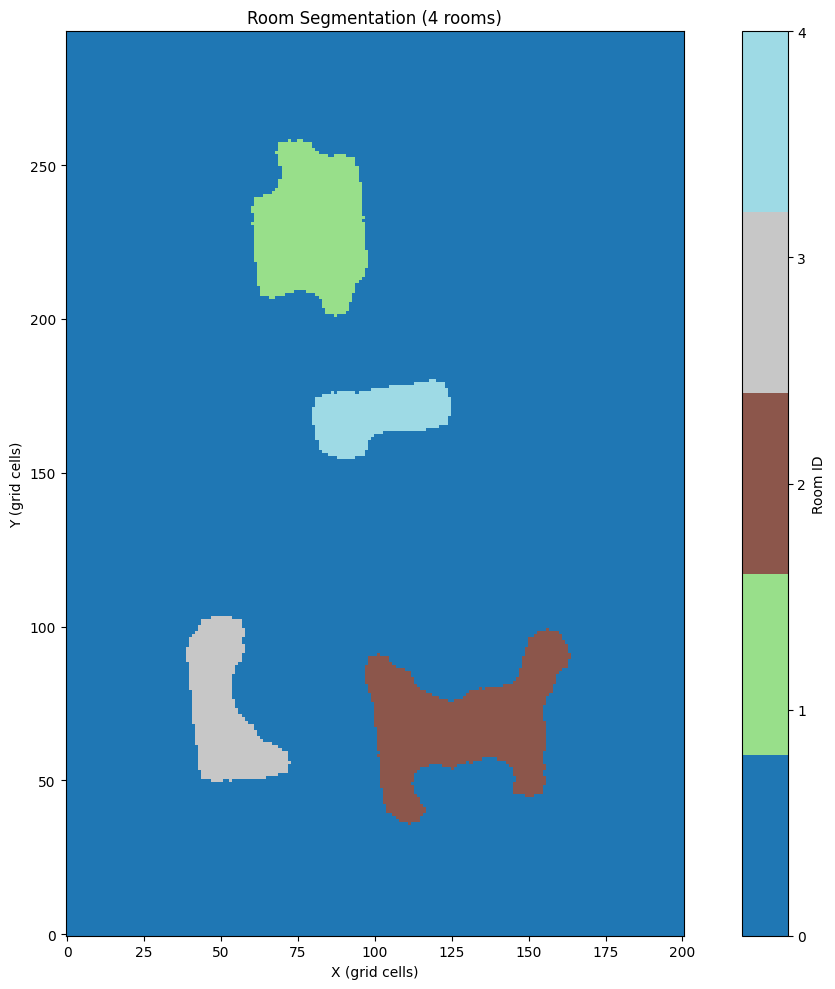

In [29]:
visualize_rooms(room_labels)

#### Step 7: Assign Points to Rooms

In [30]:
def assign_points_to_rooms_with_dilation(points, room_labels, origin, resolution, 
                                         dilation_cells=3):
    """
    Assign points to rooms, dilating room regions to capture wall points
    
    Args:
        points: Nx3 array
        room_labels: 2D grid with room IDs
        origin: (min_x, min_y)
        resolution: Grid resolution
        dilation_cells: How many cells to expand each room
    
    Returns:
        point_room_ids: Room ID for each point
    """
    from skimage import morphology
    
    print(f"Dilating room regions by {dilation_cells} cells ({dilation_cells * resolution:.2f}m)...")
    
    # Create dilated version of room labels
    dilated_labels = np.zeros_like(room_labels)
    
    # Dilate each room separately to avoid overlap conflicts
    num_rooms = room_labels.max()
    
    for room_id in range(1, num_rooms + 1):
        # Get mask for this room
        room_mask = (room_labels == room_id)
        
        # Dilate this room's region
        kernel = morphology.disk(dilation_cells)
        dilated_room = morphology.binary_dilation(room_mask, kernel)
        
        # Assign to dilated labels (later rooms overwrite earlier ones in overlaps)
        dilated_labels[dilated_room] = room_id
    
    # Now assign points using dilated labels
    min_x, min_y = origin
    height, width = room_labels.shape
    
    point_room_ids = np.zeros(len(points), dtype=np.int32)
    out_of_bounds = 0
    
    for i, point in enumerate(points):
        grid_x = int((point[0] - min_x) / resolution)
        grid_y = int((point[1] - min_y) / resolution)
        
        if 0 <= grid_x < width and 0 <= grid_y < height:
            point_room_ids[i] = dilated_labels[grid_y, grid_x]
        else:
            out_of_bounds += 1
    
    # Statistics
    print(f"\nResults:")
    print(f"  Out of bounds: {out_of_bounds} points")
    
    for room_id in range(1, num_rooms + 1):
        num_points = np.sum(point_room_ids == room_id)
        print(f"  Room {room_id}: {num_points} points")
    
    unassigned = np.sum(point_room_ids == 0)
    print(f"  Unassigned: {unassigned} points")
    
    # Visualize dilated room labels
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.imshow(dilated_labels, cmap='tab20', origin='lower')
    plt.title('Dilated Room Labels')
    plt.colorbar()
    plt.show()
    
    return point_room_ids

Dilating room regions by 10 cells (0.50m)...

Results:
  Out of bounds: 0 points
  Room 1: 23935 points
  Room 2: 9628 points
  Room 3: 17813 points
  Room 4: 22217 points
  Unassigned: 166414 points


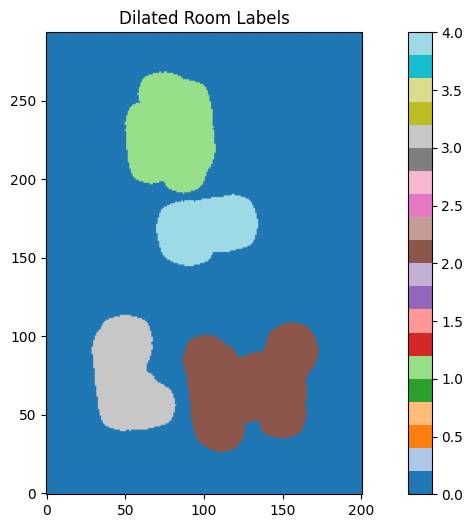

In [31]:
point_room_ids = assign_points_to_rooms_with_dilation(
    vertical_points,
    room_labels,
    origin,
    resolution,
    dilation_cells=10
)

In [32]:
def assign_remaining_to_nearest_room(points, point_room_ids, room_labels, 
                                     origin, resolution):
    """
    Assign unassigned points (room 0) to nearest room
    """
    from scipy.ndimage import distance_transform_edt
    
    unassigned_mask = (point_room_ids == 0)
    num_unassigned = np.sum(unassigned_mask)
    
    print(f"\nAssigning {num_unassigned} unassigned points to nearest room...")
    
    if num_unassigned == 0:
        return point_room_ids
    
    min_x, min_y = origin
    height, width = room_labels.shape
    num_rooms = room_labels.max()
    
    # Compute distance to each room
    nearest_room_grid = np.zeros_like(room_labels)
    min_distance_grid = np.full_like(room_labels, fill_value=np.inf, dtype=float)
    
    for room_id in range(1, num_rooms + 1):
        room_mask = (room_labels == room_id)
        
        # Expand room mask with previous dilation
        from skimage import morphology
        kernel = morphology.disk(10)
        expanded_room = morphology.binary_dilation(room_mask, kernel)
        
        # Distance from each cell to this expanded room
        distance = distance_transform_edt(~expanded_room)
        
        # Track nearest room
        closer_mask = distance < min_distance_grid
        nearest_room_grid[closer_mask] = room_id
        min_distance_grid[closer_mask] = distance[closer_mask]
    
    # Assign unassigned points
    updated_ids = point_room_ids.copy()
    
    for i in np.where(unassigned_mask)[0]:
        point = points[i]
        grid_x = int((point[0] - min_x) / resolution)
        grid_y = int((point[1] - min_y) / resolution)
        
        if 0 <= grid_x < width and 0 <= grid_y < height:
            updated_ids[i] = nearest_room_grid[grid_y, grid_x]
    
    # Statistics
    print("\nFinal assignment:")
    for room_id in range(1, num_rooms + 1):
        num_points = np.sum(updated_ids == room_id)
        print(f"  Room {room_id}: {num_points} points")
    
    remaining_unassigned = np.sum(updated_ids == 0)
    print(f"  Still unassigned: {remaining_unassigned} points")
    
    return updated_ids

In [33]:
point_room_ids_final = assign_remaining_to_nearest_room(
    vertical_points, point_room_ids, room_labels, origin, resolution
)


Assigning 166414 unassigned points to nearest room...

Final assignment:
  Room 1: 51396 points
  Room 2: 73026 points
  Room 3: 56035 points
  Room 4: 59550 points
  Still unassigned: 0 points


In [34]:
def visualize_rooms_3d(points, room_ids, num_rooms):
    """
    Visualize 3D points colored by room
    
    Args:
        points: Nx3 array of points
        room_ids: Room ID for each point
        num_rooms: Total number of rooms
    """
    import matplotlib.pyplot as plt
    
    # Create colormap
    colors = plt.cm.tab20(np.linspace(0, 1, num_rooms + 1))
    
    point_colors = np.zeros((len(points), 3))
    for room_id in range(num_rooms + 1):
        mask = room_ids == room_id
        point_colors[mask] = colors[room_id, :3]
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    o3d.visualization.draw_geometries([pcd], 
                                      window_name="Rooms in 3D (Color=Room)")

In [35]:
visualize_rooms_3d(vertical_points, point_room_ids_final, num_rooms)

In [54]:
def print_room_summary(point_room_ids, num_rooms):
    """
    Print summary of point assignments
    """
    print("\n=== Room Assignment Summary ===")
    for room_id in range(num_rooms + 1):
        count = np.sum(point_room_ids == room_id)
        percentage = 100 * count / len(point_room_ids)
        
        if room_id == 0:
            print(f"  Unassigned (Room 0): {count} points ({percentage:.1f}%)")
        else:
            print(f"  Room {room_id}: {count} points ({percentage:.1f}%)")
    
    print(f"\nTotal points: {len(point_room_ids)}")

In [55]:
print_room_summary(point_room_ids_final, num_rooms)


=== Room Assignment Summary ===
  Unassigned (Room 0): 0 points (0.0%)
  Room 1: 79444 points (17.1%)
  Room 2: 151323 points (32.6%)
  Room 3: 119299 points (25.7%)
  Room 4: 113409 points (24.5%)

Total points: 463475


### WALL DETECTION

#### Detect Walls Per Room (RANSAC + DBSCAN)

In [58]:
def visualize_walls_per_room_fast(vertical_points, point_room_ids, walls, num_rooms):
    """
    Fast visualization - assigns colors directly without nested loops
    """
    import matplotlib.pyplot as plt
    
    print("Creating visualization...")
    
    # Initialize all points as gray
    point_colors = np.ones((len(vertical_points), 3)) * 0.5
    
    for room_id in range(1, num_rooms + 1):
        if room_id not in walls:
            continue
        
        room_color = plt.cm.tab10(room_id % 10)[:3]
        room_walls = walls[room_id]
        
        # Color walls in this room
        for wall_idx, wall_info in enumerate(room_walls):
            wall_points = wall_info['inliers']
            
            # Vary brightness per wall
            brightness = 0.5 + (wall_idx * 0.5 / len(room_walls))
            wall_color = np.array(room_color) * brightness
            
            # Find these points by checking if they belong to this room
            room_mask = (point_room_ids == room_id)
            room_point_indices = np.where(room_mask)[0]
            
            # Use spatial hashing for faster lookup
            from scipy.spatial import cKDTree
            
            # Build KDTree for wall points
            tree = cKDTree(wall_points)
            
            # Query for room points within wall
            room_points_subset = vertical_points[room_mask]
            distances, indices = tree.query(room_points_subset, distance_upper_bound=0.02)
            
            # Points with distance < threshold belong to this wall
            wall_point_mask = distances < 0.02
            actual_indices = room_point_indices[wall_point_mask]
            
            point_colors[actual_indices] = wall_color
    
    # Visualize
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(vertical_points)
    pcd.colors = o3d.utility.Vector3dVector(point_colors)
    
    o3d.visualization.draw_geometries([pcd], window_name="Walls per Room (Fast)")


In [59]:
def detect_walls_per_room_clustered(vertical_points, point_room_ids, num_rooms,
                                    floor_height, ceiling_height,
                                    distance_threshold=0.03,
                                    cluster_eps=0.15,
                                    min_cluster_points=100,
                                    min_wall_height=1.5,
                                    min_wall_length=1.0,
                                    max_iterations=30):
    """
    Detect walls using RANSAC + DBSCAN clustering
    
    Process:
    1. RANSAC: Find plane
    2. DBSCAN: Cluster points on that plane (separates disconnected furniture)
    3. Keep largest cluster (main wall segment)
    4. Filter by size
    5. Repeat
    
    Args:
        vertical_points: Nx3 wall points
        point_room_ids: Room ID for each point
        num_rooms: Total rooms
        floor_height, ceiling_height: Room bounds
        distance_threshold: RANSAC plane distance (m)
        cluster_eps: DBSCAN epsilon (m) - distance between points in cluster
        min_cluster_points: Minimum points for valid cluster
        min_wall_height: Minimum wall height (m)
        min_wall_length: Minimum wall length (m)
        max_iterations: Maximum number of planes to detect per room
    
    Returns:
        walls: Dict of room_id -> list of wall info
    """
    walls = {}
    room_height = ceiling_height - floor_height
    
    for room_id in range(1, num_rooms + 1):
        print(f"\n{'='*60}")
        print(f"ROOM {room_id}")
        print('='*60)
        
        # Get room points
        room_mask = point_room_ids == room_id
        room_points = vertical_points[room_mask]
        
        if len(room_points) < min_cluster_points:
            print(f"Too few points: {len(room_points)}")
            continue
        
        print(f"Total points: {len(room_points)}")
        
        # Storage
        room_walls = []
        remaining_points = room_points.copy()
        
        # Iteratively find planes
        for iteration in range(max_iterations):
            if len(remaining_points) < min_cluster_points:
                print(f"\nStopping: Only {len(remaining_points)} points remaining")
                break
            
            print(f"\n--- Iteration {iteration + 1} ---")
            print(f"Remaining points: {len(remaining_points)}")
            
            # Create point cloud
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(remaining_points)
            
            # STEP 1: RANSAC - Find plane
            plane_model, inliers_idx = pcd.segment_plane(
                distance_threshold=distance_threshold,
                ransac_n=3,
                num_iterations=1000
            )
            
            if len(inliers_idx) < min_cluster_points:
                print(f"Plane too small: {len(inliers_idx)} points")
                break
            
            [a, b, c, d] = plane_model
            print(f"Plane found: {len(inliers_idx)} inliers, normal=[{a:.2f}, {b:.2f}, {c:.2f}]")
            
            # Check verticality
            if abs(c) > 0.3:
                print(f"Not vertical (|normal_z|={abs(c):.2f}), skipping")
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # Get inlier points
            inlier_points = remaining_points[inliers_idx]
            
            # STEP 2: DBSCAN - Cluster points on this plane
            pcd_inliers = o3d.geometry.PointCloud()
            pcd_inliers.points = o3d.utility.Vector3dVector(inlier_points)
            
            labels = np.array(pcd_inliers.cluster_dbscan(
                eps=cluster_eps,
                min_points=min_cluster_points
            ))
            
            # Find clusters
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[unique_labels >= 0]  # Remove noise (-1)
            
            if len(unique_labels) == 0:
                print("No valid clusters found")
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # Count points in each cluster
            cluster_sizes = []
            for label in unique_labels:
                cluster_size = np.sum(labels == label)
                cluster_sizes.append(cluster_size)
            
            print(f"Clusters found: {len(unique_labels)}")
            for label, size in zip(unique_labels, cluster_sizes):
                print(f"  Cluster {label}: {size} points")
            
            # STEP 3: Keep largest cluster (main wall segment)
            largest_cluster_idx = unique_labels[np.argmax(cluster_sizes)]
            largest_cluster_size = max(cluster_sizes)
            
            print(f"Largest cluster: {largest_cluster_idx} with {largest_cluster_size} points")
            
            # Extract largest cluster points
            largest_cluster_mask = (labels == largest_cluster_idx)
            wall_segment_points = inlier_points[largest_cluster_mask]
            
            # STEP 4: Validate wall segment
            # Check height
            z_values = wall_segment_points[:, 2]
            wall_height = z_values.max() - z_values.min()
            
            # Check length
            points_2d = wall_segment_points[:, :2]
            
            if len(points_2d) > 2:
                from scipy.spatial import ConvexHull
                try:
                    hull = ConvexHull(points_2d)
                    perimeter = hull.area
                    wall_length = perimeter / 2
                    wall_area = wall_length * wall_height
                except:
                    wall_length = 0
                    wall_area = 0
            else:
                wall_length = 0
                wall_area = 0
            
            # Height ratio
            height_ratio = wall_height / room_height
            
            # Filtering
            is_valid = (
                wall_height >= min_wall_height and
                wall_length >= min_wall_length and
                largest_cluster_size >= min_cluster_points
            )
            
            if not is_valid:
                print(f"❌ Rejected: h={wall_height:.2f}m, len={wall_length:.2f}m, "
                      f"pts={largest_cluster_size}")
                
                # Remove all inliers (including small clusters) from remaining
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # STEP 5: Store valid wall
            wall_info = {
                'plane_model': plane_model,
                'inliers': wall_segment_points,
                'num_inliers': largest_cluster_size,
                'length': wall_length,
                'height': wall_height,
                'area': wall_area,
                'height_ratio': height_ratio
            }
            
            room_walls.append(wall_info)
            
            print(f"✅ Wall {len(room_walls)}: {largest_cluster_size} points, "
                  f"len={wall_length:.2f}m, h={wall_height:.2f}m ({height_ratio*100:.0f}%), "
                  f"area={wall_area:.2f}m²")
            
            # Remove ALL inliers (including rejected small clusters)
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
        
        walls[room_id] = room_walls
        print(f"\n{'='*60}")
        print(f"Room {room_id} complete: {len(room_walls)} walls detected")
        print('='*60)
    
    return walls

In [63]:
walls_clustered = detect_walls_per_room_clustered(
    vertical_points,
    point_room_ids_final,
    num_rooms,
    floor_h,
    ceiling_h,
    distance_threshold=0.1,  # Plane fitting tolerance
    cluster_eps=0.12,         # DBSCAN: max distance between points (15cm)
    min_cluster_points=50,   # Minimum points for valid wall segment
    min_wall_height=1.5,      # Minimum 1.5m tall
    min_wall_length=0.5,      # Minimum 1.0m long
    max_iterations=30         # Max walls to detect per room
)


ROOM 1
Total points: 79444

--- Iteration 1 ---
Remaining points: 79444
Plane found: 25630 inliers, normal=[0.99, 0.10, -0.00]
Clusters found: 1
  Cluster 0: 25110 points
Largest cluster: 0 with 25110 points
✅ Wall 1: 25110 points, len=3.41m, h=2.43m (92%), area=8.29m²

--- Iteration 2 ---
Remaining points: 53814
Plane found: 22147 inliers, normal=[1.00, 0.09, 0.01]
Clusters found: 1
  Cluster 0: 22065 points
Largest cluster: 0 with 22065 points
✅ Wall 2: 22065 points, len=3.55m, h=2.43m (92%), area=8.63m²

--- Iteration 3 ---
Remaining points: 31667
Plane found: 13460 inliers, normal=[-0.27, 0.96, 0.08]
Clusters found: 3
  Cluster 0: 7793 points
  Cluster 1: 4554 points
  Cluster 2: 984 points
Largest cluster: 0 with 7793 points
✅ Wall 3: 7793 points, len=1.47m, h=2.42m (92%), area=3.57m²

--- Iteration 4 ---
Remaining points: 18207
Plane found: 4749 inliers, normal=[0.97, 0.24, 0.06]
Clusters found: 5
  Cluster 0: 702 points
  Cluster 1: 2815 points
  Cluster 2: 546 points
  Cluster

In [65]:
def detect_walls_per_room_all_clusters(vertical_points, point_room_ids, num_rooms,
                                        floor_height, ceiling_height,
                                        distance_threshold=0.1,
                                        cluster_eps=0.15,
                                        min_cluster_points=30,
                                        min_wall_height=1.5,
                                        min_wall_length=0.3,
                                        min_height_ratio=0.6,
                                        max_iterations=30):
    """
    Detect walls using RANSAC + DBSCAN, keeping ALL valid clusters per plane
    
    Key difference from original: Instead of keeping only the largest cluster,
    this keeps ALL clusters that meet validation criteria. This prevents loss
    of valid wall segments (e.g., walls split by doors/windows).
    
    Process:
    1. RANSAC: Find plane
    2. DBSCAN: Cluster points on that plane
    3. Validate EACH cluster independently
    4. Keep ALL valid clusters as separate wall segments
    5. Remove all inliers and repeat
    
    Args:
        vertical_points: Nx3 wall points (pre-filtered for verticality)
        point_room_ids: Room ID for each point
        num_rooms: Total number of rooms
        floor_height: Floor Z coordinate
        ceiling_height: Ceiling Z coordinate
        distance_threshold: RANSAC plane distance tolerance (m)
        cluster_eps: DBSCAN epsilon - max distance between points in cluster (m)
        min_cluster_points: Minimum points for valid cluster
        min_wall_height: Minimum wall height (m)
        min_wall_length: Minimum wall length (m)
        min_height_ratio: Minimum ratio of wall_height/room_height (0-1)
        max_iterations: Maximum number of planes to detect per room
    
    Returns:
        walls: Dict of room_id -> list of wall segment info
    """
    walls = {}
    room_height = ceiling_height - floor_height
    
    for room_id in range(1, num_rooms + 1):
        print(f"\n{'='*60}")
        print(f"ROOM {room_id}")
        print('='*60)
        
        # Get room points
        room_mask = point_room_ids == room_id
        room_points = vertical_points[room_mask]
        
        if len(room_points) < min_cluster_points:
            print(f"Too few points: {len(room_points)}")
            continue
        
        print(f"Total points: {len(room_points)}")
        
        # Storage
        room_walls = []
        remaining_points = room_points.copy()
        
        # Iteratively find planes
        for iteration in range(max_iterations):
            if len(remaining_points) < min_cluster_points:
                print(f"\nStopping: Only {len(remaining_points)} points remaining")
                break
            
            print(f"\n--- Iteration {iteration + 1} ---")
            print(f"Remaining points: {len(remaining_points)}")
            
            # Create point cloud
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(remaining_points)
            
            # STEP 1: RANSAC - Find plane
            plane_model, inliers_idx = pcd.segment_plane(
                distance_threshold=distance_threshold,
                ransac_n=3,
                num_iterations=1000
            )
            
            if len(inliers_idx) < min_cluster_points:
                print(f"Plane too small: {len(inliers_idx)} points")
                break
            
            [a, b, c, d] = plane_model
            print(f"Plane found: {len(inliers_idx)} inliers, normal=[{a:.2f}, {b:.2f}, {c:.2f}]")
            
            # Check verticality
            if abs(c) > 0.3:
                print(f"Not vertical (|normal_z|={abs(c):.2f}), skipping")
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            # Get inlier points
            inlier_points = remaining_points[inliers_idx]
            
            # STEP 2: DBSCAN - Cluster points on this plane
            pcd_inliers = o3d.geometry.PointCloud()
            pcd_inliers.points = o3d.utility.Vector3dVector(inlier_points)
            
            labels = np.array(pcd_inliers.cluster_dbscan(
                eps=cluster_eps,
                min_points=min_cluster_points
            ))
            
            # Find valid clusters (exclude noise label -1)
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[unique_labels >= 0]
            
            if len(unique_labels) == 0:
                print("No valid clusters found")
                remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
                continue
            
            print(f"Clusters found: {len(unique_labels)}")
            
            # STEP 3: Process EACH cluster independently
            valid_segments_this_iteration = 0
            
            for cluster_label in unique_labels:
                cluster_mask = (labels == cluster_label)
                cluster_points = inlier_points[cluster_mask]
                cluster_size = np.sum(cluster_mask)
                
                print(f"\n  Cluster {cluster_label}: {cluster_size} points")
                
                # STEP 4: Validate THIS cluster
                
                # Check height
                z_values = cluster_points[:, 2]
                wall_height = z_values.max() - z_values.min()
                
                # Check length (2D convex hull perimeter / 2)
                points_2d = cluster_points[:, :2]
                
                if len(points_2d) > 2:
                    try:
                        hull = ConvexHull(points_2d)
                        perimeter = hull.area  # In 2D, ConvexHull.area is perimeter
                        wall_length = perimeter / 2  # Approximate length
                        wall_area = wall_length * wall_height
                    except Exception as e:
                        print(f"    ⚠️  ConvexHull failed: {e}")
                        wall_length = 0
                        wall_area = 0
                else:
                    wall_length = 0
                    wall_area = 0
                
                # Height ratio
                height_ratio = wall_height / room_height
                
                # Validation criteria
                is_valid = (
                    wall_height >= min_wall_height and
                    wall_length >= min_wall_length and
                    cluster_size >= min_cluster_points and
                    height_ratio >= min_height_ratio
                )
                
                if not is_valid:
                    print(f"    ❌ Rejected: h={wall_height:.2f}m, len={wall_length:.2f}m, "
                          f"h_ratio={height_ratio:.2f}, pts={cluster_size}")
                    continue
                
                # STEP 5: Store valid wall segment
                wall_info = {
                    'plane_model': plane_model,  # Same plane for all clusters this iteration
                    'inliers': cluster_points,
                    'num_inliers': cluster_size,
                    'length': wall_length,
                    'height': wall_height,
                    'area': wall_area,
                    'height_ratio': height_ratio
                }
                
                room_walls.append(wall_info)
                valid_segments_this_iteration += 1
                
                print(f"    ✅ Wall segment {len(room_walls)}: {cluster_size} points, "
                      f"len={wall_length:.2f}m, h={wall_height:.2f}m ({height_ratio*100:.0f}%), "
                      f"area={wall_area:.2f}m²")
            
            # Summary for this iteration
            if valid_segments_this_iteration > 0:
                print(f"\n  ✓ Kept {valid_segments_this_iteration} valid segment(s) from this plane")
            else:
                print(f"\n  ✗ No valid segments from this plane")
            
            # Remove ALL inliers (including rejected clusters) from remaining points
            remaining_points = np.delete(remaining_points, inliers_idx, axis=0)
        
        walls[room_id] = room_walls
        print(f"\n{'='*60}")
        print(f"Room {room_id} complete: {len(room_walls)} wall segments detected")
        print('='*60)
    
    return walls

In [66]:
def print_wall_statistics(walls):
    """
    Print summary statistics for detected walls
    """
    print(f"\n{'='*60}")
    print("WALL DETECTION SUMMARY")
    print('='*60)
    
    total_segments = 0
    for room_id, room_walls in walls.items():
        total_segments += len(room_walls)
        print(f"\nRoom {room_id}: {len(room_walls)} wall segments")
        
        for i, wall in enumerate(room_walls, 1):
            print(f"  Segment {i}: "
                  f"len={wall['length']:.2f}m, "
                  f"h={wall['height']:.2f}m, "
                  f"pts={wall['num_inliers']}, "
                  f"normal=[{wall['plane_model'][0]:.2f}, "
                  f"{wall['plane_model'][1]:.2f}, "
                  f"{wall['plane_model'][2]:.2f}]")
    
    print(f"\nTotal wall segments across all rooms: {total_segments}")
    print('='*60)

In [69]:
walls = detect_walls_per_room_all_clusters(
    vertical_points,
    point_room_ids_final,
    num_rooms,
    floor_h,
    ceiling_h,
    distance_threshold=0.1,     # RANSAC plane tolerance
    cluster_eps=0.15,            # DBSCAN clustering distance (15cm)
    min_cluster_points=30,       # Minimum points per cluster
    min_wall_height=1.5,         # Minimum 1.5m tall
    min_wall_length=0.3,         # Minimum 0.3m long
    min_height_ratio=0.6,        # Wall must span 60% of room height
    max_iterations=30            # Max planes per room
)


ROOM 1
Total points: 79444

--- Iteration 1 ---
Remaining points: 79444
Plane found: 25640 inliers, normal=[0.99, 0.10, -0.00]
Clusters found: 4

  Cluster 0: 25383 points
    ✅ Wall segment 1: 25383 points, len=3.61m, h=2.43m (92%), area=8.76m²

  Cluster 1: 77 points
    ❌ Rejected: h=0.55m, len=0.20m, h_ratio=0.21, pts=77

  Cluster 2: 29 points
    ❌ Rejected: h=0.28m, len=0.06m, h_ratio=0.11, pts=29

  Cluster 3: 30 points
    ❌ Rejected: h=0.29m, len=0.11m, h_ratio=0.11, pts=30

  ✓ Kept 1 valid segment(s) from this plane

--- Iteration 2 ---
Remaining points: 53804
Plane found: 22167 inliers, normal=[1.00, 0.09, 0.01]
Clusters found: 2

  Cluster 0: 22089 points
    ✅ Wall segment 2: 22089 points, len=3.57m, h=2.43m (92%), area=8.68m²

  Cluster 1: 45 points
    ❌ Rejected: h=0.45m, len=0.13m, h_ratio=0.17, pts=45

  ✓ Kept 1 valid segment(s) from this plane

--- Iteration 3 ---
Remaining points: 31637
Plane found: 13574 inliers, normal=[-0.23, 0.97, 0.01]
Clusters found: 4

  

In [70]:
print_wall_statistics(walls)


WALL DETECTION SUMMARY

Room 1: 10 wall segments
  Segment 1: len=3.61m, h=2.43m, pts=25383, normal=[0.99, 0.10, -0.00]
  Segment 2: len=3.57m, h=2.43m, pts=22089, normal=[1.00, 0.09, 0.01]
  Segment 3: len=1.43m, h=1.87m, pts=7285, normal=[-0.23, 0.97, 0.01]
  Segment 4: len=0.35m, h=2.37m, pts=888, normal=[-0.23, 0.97, 0.01]
  Segment 5: len=1.07m, h=2.43m, pts=5226, normal=[-0.23, 0.97, 0.01]
  Segment 6: len=1.48m, h=2.42m, pts=3628, normal=[-0.19, 0.98, 0.02]
  Segment 7: len=1.81m, h=2.38m, pts=4271, normal=[-0.13, 0.99, -0.04]
  Segment 8: len=0.42m, h=2.43m, pts=1600, normal=[0.97, 0.24, 0.04]
  Segment 9: len=0.36m, h=1.84m, pts=678, normal=[0.86, -0.50, 0.03]
  Segment 10: len=0.34m, h=1.83m, pts=796, normal=[0.87, -0.49, -0.02]

Room 2: 11 wall segments
  Segment 1: len=4.74m, h=2.43m, pts=30762, normal=[-0.09, 1.00, 0.02]
  Segment 2: len=5.47m, h=2.43m, pts=27807, normal=[1.00, 0.09, -0.00]
  Segment 3: len=4.01m, h=2.43m, pts=15537, normal=[-0.08, 1.00, -0.00]
  Segment 

In [2]:
visualize_walls_per_room_fast(vertical_points, point_room_ids_final, walls, num_rooms)

NameError: name 'visualize_walls_per_room_fast' is not defined

### ROOM POLYGON

#### Approach 1: Concave Hull + Simplification

##### Extract Wall Points for a Room

In [72]:
def get_room_wall_points(walls, room_id):
    """
    Extract all wall points for a specific room
    
    Args:
        walls: Dict from detect_walls_per_room_all_clusters
               Format: {room_id: [wall1, wall2, ...]}
               Each wall has: {'inliers': Nx3 array, 'plane_model': [a,b,c,d], ...}
        room_id: Room ID (integer)
    
    Returns:
        points_3d: Nx3 numpy array of all wall points in this room
                   Returns empty array if room not found or has no walls
    """
    # Check if room exists
    if room_id not in walls:
        print(f"Room {room_id} not found in walls dict")
        return np.array([])
    
    room_walls = walls[room_id]
    
    if len(room_walls) == 0:
        print(f"Room {room_id} has no detected walls")
        return np.array([])
    
    # Collect all point clouds from all wall segments
    all_points = []
    
    for i, wall in enumerate(room_walls):
        wall_points = wall['inliers']  # Nx3 array
        all_points.append(wall_points)
        print(f"  Wall segment {i+1}: {len(wall_points)} points")
    
    # Stack all points into single array
    combined_points = np.vstack(all_points)
    
    print(f"\nTotal wall points for room {room_id}: {len(combined_points)}")
    
    return combined_points

In [98]:
room_points = get_room_wall_points(walls, 2)

  Wall segment 1: 30762 points
  Wall segment 2: 27807 points
  Wall segment 3: 15537 points
  Wall segment 4: 6796 points
  Wall segment 5: 9844 points
  Wall segment 6: 13386 points
  Wall segment 7: 905 points
  Wall segment 8: 11911 points
  Wall segment 9: 4834 points
  Wall segment 10: 1739 points
  Wall segment 11: 2918 points

Total wall points for room 2: 126439


##### Project points to 2D

In [99]:
def project_points_to_2d(points_3d):
    """
    Project 3D wall points to 2D (X-Y plane)
    
    Args:
        points_3d: Nx3 numpy array (X, Y, Z coordinates)
    
    Returns:
        points_2d: Nx2 numpy array (X, Y coordinates)
    """
    if len(points_3d) == 0:
        return np.array([])
    
    # Simply take X and Y columns (ignore Z)
    points_2d = points_3d[:, :2]
    
    print(f"Projected {len(points_3d)} points to 2D")
    print(f"2D bounds:")
    print(f"  X: [{points_2d[:, 0].min():.3f}, {points_2d[:, 0].max():.3f}] "
          f"(range: {points_2d[:, 0].max() - points_2d[:, 0].min():.3f}m)")
    print(f"  Y: [{points_2d[:, 1].min():.3f}, {points_2d[:, 1].max():.3f}] "
          f"(range: {points_2d[:, 1].max() - points_2d[:, 1].min():.3f}m)")
    
    return points_2d

In [100]:
def visualize_2d_points(points_2d, title="2D Wall Points", downsample=10):
    """
    Visualize 2D points with matplotlib
    
    Args:
        points_2d: Nx2 numpy array
        title: Plot title
        downsample: Plot every Nth point (for speed with large datasets)
    """
    if len(points_2d) == 0:
        print("No points to visualize")
        return
    
    # Downsample for visualization
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
        print(f"Plotting {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    else:
        points_to_plot = points_2d
    
    plt.figure(figsize=(10, 6))
    plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                s=1, c='blue', alpha=0.5)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(title)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [101]:
points_2d = project_points_to_2d(room_points)

Projected 126439 points to 2D
2D bounds:
  X: [1.694, 7.346] (range: 5.652m)
  Y: [-3.555, 2.345] (range: 5.900m)


Plotting 12644 points (downsampled from 126439)


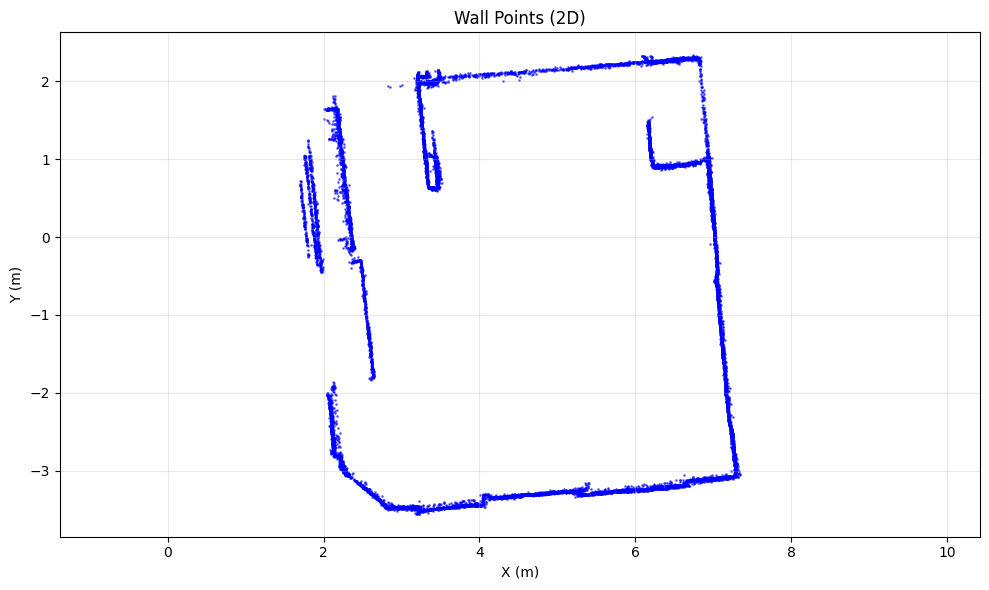

In [102]:
visualize_2d_points(points_2d, title="Wall Points (2D)", downsample=10)

In [105]:
def compute_concave_hull(points_2d, alpha=0.5):
    """
    Compute concave hull (alpha shape) of 2D points
    
    Args:
        points_2d: Nx2 numpy array of 2D points
        alpha: Alpha parameter controlling hull tightness
               - Smaller alpha (0.1-0.3): Tighter, more detailed hull (follows contours closely)
               - Medium alpha (0.5-0.8): Balanced
               - Larger alpha (1.0-2.0): Looser, more convex (smooths over gaps)
               - alpha → infinity: Becomes convex hull
    
    Returns:
        hull_polygon: Shapely Polygon object, or None if failed
    """
    
    print(f"\nComputing concave hull with alpha={alpha}...")
    print(f"Input: {len(points_2d)} points")
    
    try:
        # Compute alpha shape
        hull = alphashape.alphashape(points_2d, alpha)
        
        # Check result type
        if hull is None or hull.is_empty:
            print("Warning: Hull computation returned empty result")
            return None
        
        # Handle MultiPolygon (disconnected regions)
        if hull.geom_type == 'MultiPolygon':
            print(f"Warning: Got MultiPolygon with {len(list(hull.geoms))} parts")
            # Take the largest polygon
            polygons = list(hull.geoms)
            hull = max(polygons, key=lambda p: p.area)
            print(f"Selected largest polygon (area={hull.area:.2f} m²)")
        
        # Get hull info
        num_vertices = len(hull.exterior.coords) - 1  # -1 because first=last
        
        print(f"✓ Hull computed successfully")
        print(f"  Vertices: {num_vertices}")
        print(f"  Area: {hull.area:.2f} m²")
        print(f"  Perimeter: {hull.length:.2f} m")
        
        return hull
    
    except Exception as e:
        print(f"Error computing hull: {e}")
        return None

In [106]:
hull = compute_concave_hull(points_2d, alpha=0.5)


Computing concave hull with alpha=0.5...
Input: 126439 points
✓ Hull computed successfully
  Vertices: 112
  Area: 28.42 m²
  Perimeter: 20.56 m


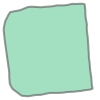

In [107]:
hull

In [110]:
def visualize_hull(points_2d, hull_polygon, title="Concave Hull", downsample=10):
    """
    Visualize 2D points with hull overlay
    
    Args:
        points_2d: Nx2 numpy array of original points
        hull_polygon: Shapely Polygon from compute_concave_hull
        title: Plot title
        downsample: Downsample points for faster plotting
    """
    if hull_polygon is None:
        print("No hull to visualize")
        return
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    # Extract hull vertices
    hull_coords = np.array(hull_polygon.exterior.coords)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot points
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
               s=1, c='lightblue', alpha=0.3, label='Wall points')
    
    # Plot hull
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'r-', linewidth=2, label='Concave hull')
    ax.plot(hull_coords[:, 0], hull_coords[:, 1], 
            'ro', markersize=4, label='Hull vertices')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization info:")
    print(f"  Plotted {len(points_to_plot)} points (downsampled from {len(points_2d)})")
    print(f"  Hull has {len(hull_coords)-1} vertices")

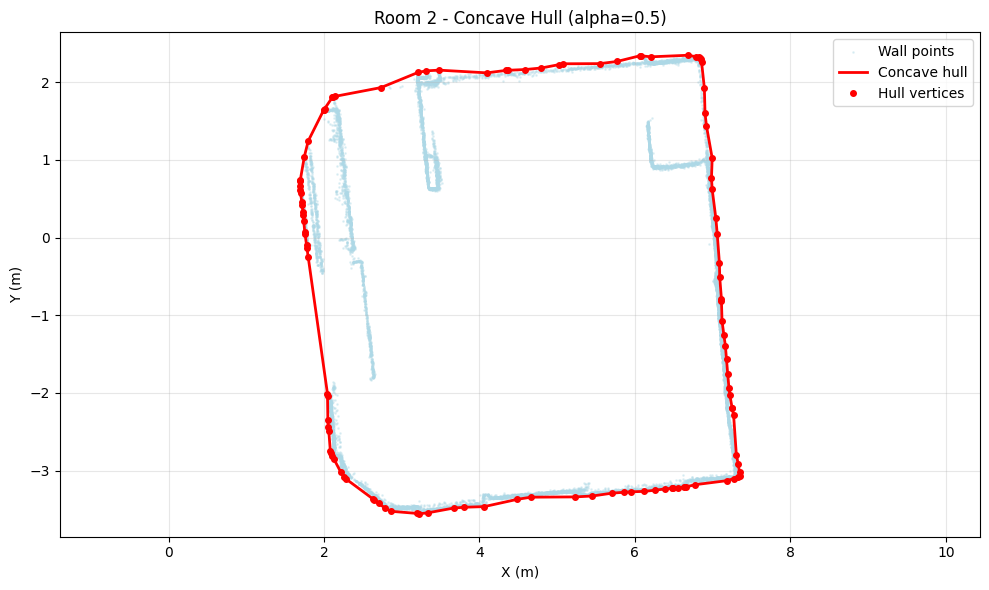


Visualization info:
  Plotted 12644 points (downsampled from 126439)
  Hull has 112 vertices


In [111]:
visualize_hull(points_2d, hull, title="Room 2 - Concave Hull (alpha=0.5)")

In [114]:
def compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0], downsample=10):
    """
    Compare different alpha values side-by-side
    
    Args:
        points_2d: Nx2 numpy array
        alpha_values: List of alpha values to test
        downsample: Downsample for plotting
    """
    
    # Downsample points
    if downsample > 1:
        points_to_plot = points_2d[::downsample]
    else:
        points_to_plot = points_2d
    
    num_alphas = len(alpha_values)
    fig, axes = plt.subplots(1, num_alphas, figsize=(6*num_alphas, 6))
    
    if num_alphas == 1:
        axes = [axes]
    
    for i, alpha in enumerate(alpha_values):
        ax = axes[i]
        
        # Compute hull
        hull = compute_concave_hull(points_2d, alpha=alpha)
        
        if hull is not None:
            # Plot points
            ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], 
                      s=1, c='lightblue', alpha=0.3)
            
            # Plot hull
            hull_coords = np.array(hull.exterior.coords)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'r-', linewidth=2)
            ax.plot(hull_coords[:, 0], hull_coords[:, 1], 'ro', markersize=3)
            
            ax.set_title(f'Alpha = {alpha}\n{len(hull_coords)-1} vertices, '
                        f'Area = {hull.area:.2f} m²')
        else:
            ax.set_title(f'Alpha = {alpha}\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Computing concave hull with alpha=0.3...
Input: 126439 points
✓ Hull computed successfully
  Vertices: 85
  Area: 28.55 m²
  Perimeter: 20.53 m

Computing concave hull with alpha=0.5...
Input: 126439 points
✓ Hull computed successfully
  Vertices: 112
  Area: 28.42 m²
  Perimeter: 20.56 m

Computing concave hull with alpha=0.8...
Input: 126439 points
✓ Hull computed successfully
  Vertices: 144
  Area: 28.22 m²
  Perimeter: 20.63 m

Computing concave hull with alpha=1.0...
Input: 126439 points
✓ Hull computed successfully
  Vertices: 159
  Area: 28.20 m²
  Perimeter: 20.63 m


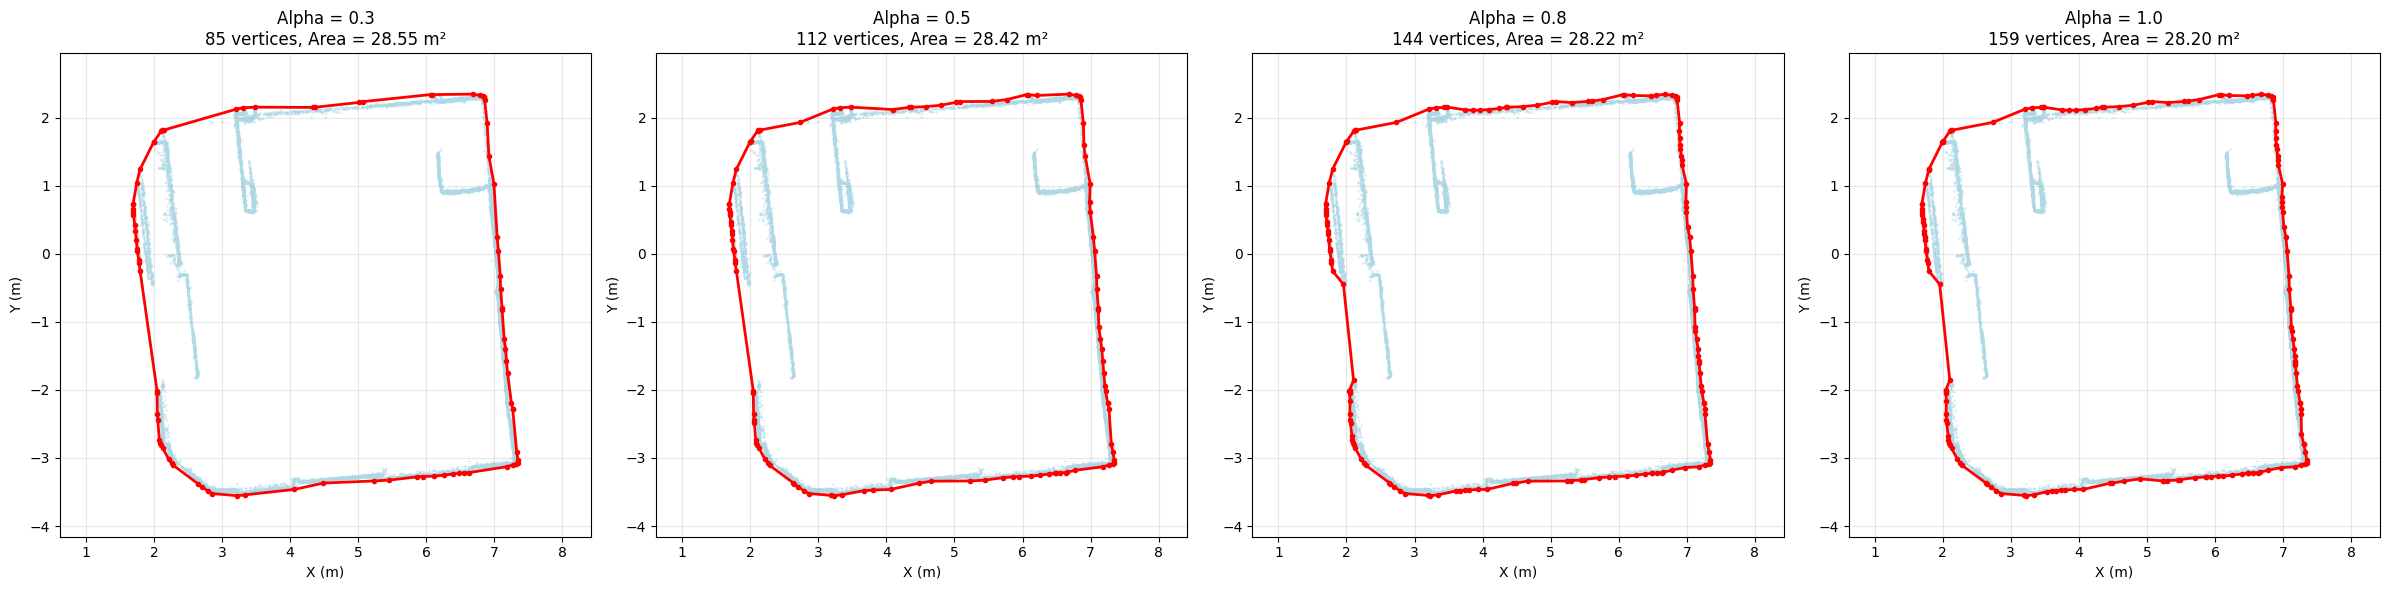

In [115]:
compare_alpha_values(points_2d, alpha_values=[0.3, 0.5, 0.8, 1.0])

##### Simplification with Douglas-Peucker

In [120]:
def simplify_polygon(polygon, epsilon=0.1):
    """
    Simplify polygon using Douglas-Peucker algorithm
    
    The Douglas-Peucker algorithm removes vertices that contribute less than
    epsilon to the polygon's shape, creating a simplified polygon with fewer
    vertices while preserving the overall shape.
    
    Args:
        polygon: Shapely Polygon object
        epsilon: Simplification tolerance (meters)
                 - Smaller epsilon (0.03-0.05): Keeps more detail, more vertices
                 - Medium epsilon (0.08-0.12): Balanced (recommended)
                 - Larger epsilon (0.15-0.20): Aggressive simplification, fewer vertices
    
    Returns:
        simplified_polygon: Shapely Polygon with fewer vertices
    """
    if polygon is None or polygon.is_empty:
        print("Error: Invalid polygon")
        return None
    
    print(f"\nSimplifying polygon with epsilon={epsilon}m...")
    
    # Get original vertex count
    original_vertices = len(polygon.exterior.coords) - 1  # -1 for closing point
    original_area = polygon.area
    original_perimeter = polygon.length
    
    print(f"Original: {original_vertices} vertices, area={original_area:.2f} m², perimeter={original_perimeter:.2f} m")
    
    try:
        # Simplify using Douglas-Peucker
        simplified = polygon.simplify(epsilon, preserve_topology=True)
        
        # Get simplified info
        simplified_vertices = len(simplified.exterior.coords) - 1
        simplified_area = simplified.area
        simplified_perimeter = simplified.length
        
        # Calculate differences
        vertex_reduction = original_vertices - simplified_vertices
        area_diff = abs(original_area - simplified_area)
        area_diff_percent = (area_diff / original_area) * 100
        
        print(f"Simplified: {simplified_vertices} vertices, area={simplified_area:.2f} m², perimeter={simplified_perimeter:.2f} m")
        print(f"Reduction: {vertex_reduction} vertices removed ({vertex_reduction/original_vertices*100:.1f}%)")
        print(f"Area change: {area_diff:.3f} m² ({area_diff_percent:.2f}%)")
        
        return simplified
    
    except Exception as e:
        print(f"Error during simplification: {e}")
        return None

In [121]:
def extract_vertices(polygon):
    """
    Extract ordered vertices from Shapely polygon
    
    Args:
        polygon: Shapely Polygon
    
    Returns:
        vertices: Nx2 numpy array of (x, y) coordinates
    """
    if polygon is None:
        return np.array([])
    
    # Get exterior ring coordinates
    coords = np.array(polygon.exterior.coords)
    
    # Remove last point (duplicate of first for closing)
    vertices = coords[:-1]
    
    return vertices

In [128]:
def visualize_simplification(original_polygon, simplified_polygon, points_2d=None, 
                             title="Polygon Simplification", downsample=10):
    """
    Visualize original hull vs simplified polygon
    
    Args:
        original_polygon: Original concave hull
        simplified_polygon: Simplified polygon
        points_2d: Optional - original 2D points to show in background
        title: Plot title
        downsample: Downsample points for plotting
    """
    if original_polygon is None or simplified_polygon is None:
        print("Missing polygon for visualization")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Extract coordinates
    orig_coords = np.array(original_polygon.exterior.coords)
    simp_coords = np.array(simplified_polygon.exterior.coords)
    
    # Plot 1: Original hull
    ax1.set_title(f'Original Hull\n{len(orig_coords)-1} vertices')
    if points_2d is not None:
        points_plot = points_2d[::downsample] if downsample > 1 else points_2d
        ax1.scatter(points_plot[:, 0], points_plot[:, 1], s=1, c='lightblue', alpha=0.2)
    ax1.plot(orig_coords[:, 0], orig_coords[:, 1], 'b-', linewidth=2, label='Original')
    ax1.plot(orig_coords[:, 0], orig_coords[:, 1], 'bo', markersize=3)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.axis('equal')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Simplified polygon
    ax2.set_title(f'Simplified Polygon\n{len(simp_coords)-1} vertices')
    if points_2d is not None:
        points_plot = points_2d[::downsample] if downsample > 1 else points_2d
        ax2.scatter(points_plot[:, 0], points_plot[:, 1], s=1, c='lightblue', alpha=0.2)
    ax2.plot(simp_coords[:, 0], simp_coords[:, 1], 'r-', linewidth=2, label='Simplified')
    ax2.plot(simp_coords[:, 0], simp_coords[:, 1], 'ro', markersize=5)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.axis('equal')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [129]:
def compare_epsilon_values(hull_polygon, epsilon_values=[0.05, 0.10, 0.15, 0.20], 
                          points_2d=None, downsample=10):
    """
    Compare different epsilon values for simplification
    
    Args:
        hull_polygon: Original concave hull to simplify
        epsilon_values: List of epsilon values to test
        points_2d: Optional original points for background
        downsample: Downsample for plotting
    """
    if hull_polygon is None:
        print("No hull provided")
        return
    
    num_epsilons = len(epsilon_values)
    fig, axes = plt.subplots(1, num_epsilons, figsize=(6*num_epsilons, 6))
    
    if num_epsilons == 1:
        axes = [axes]
    
    for i, epsilon in enumerate(epsilon_values):
        ax = axes[i]
        
        # Simplify
        simplified = simplify_polygon(hull_polygon, epsilon=epsilon)
        
        if simplified is not None:
            # Plot background points
            if points_2d is not None:
                points_plot = points_2d[::downsample] if downsample > 1 else points_2d
                ax.scatter(points_plot[:, 0], points_plot[:, 1], 
                          s=1, c='lightblue', alpha=0.2)
            
            # Plot simplified polygon
            coords = np.array(simplified.exterior.coords)
            ax.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=2)
            ax.plot(coords[:, 0], coords[:, 1], 'ro', markersize=5)
            
            ax.set_title(f'Epsilon = {epsilon}m\n{len(coords)-1} vertices, '
                        f'Area = {simplified.area:.2f} m²')
        else:
            ax.set_title(f'Epsilon = {epsilon}m\n(failed)')
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Simplifying polygon with epsilon=0.05m...
Original: 112 vertices, area=28.42 m², perimeter=20.56 m
Simplified: 15 vertices, area=28.50 m², perimeter=20.51 m
Reduction: 97 vertices removed (86.6%)
Area change: 0.077 m² (0.27%)

Simplifying polygon with epsilon=0.1m...
Original: 112 vertices, area=28.42 m², perimeter=20.56 m
Simplified: 11 vertices, area=28.55 m², perimeter=20.50 m
Reduction: 101 vertices removed (90.2%)
Area change: 0.123 m² (0.43%)

Simplifying polygon with epsilon=0.15m...
Original: 112 vertices, area=28.42 m², perimeter=20.56 m
Simplified: 8 vertices, area=28.14 m², perimeter=20.42 m
Reduction: 104 vertices removed (92.9%)
Area change: 0.282 m² (0.99%)

Simplifying polygon with epsilon=0.2m...
Original: 112 vertices, area=28.42 m², perimeter=20.56 m
Simplified: 7 vertices, area=27.68 m², perimeter=20.28 m
Reduction: 105 vertices removed (93.8%)
Area change: 0.744 m² (2.62%)


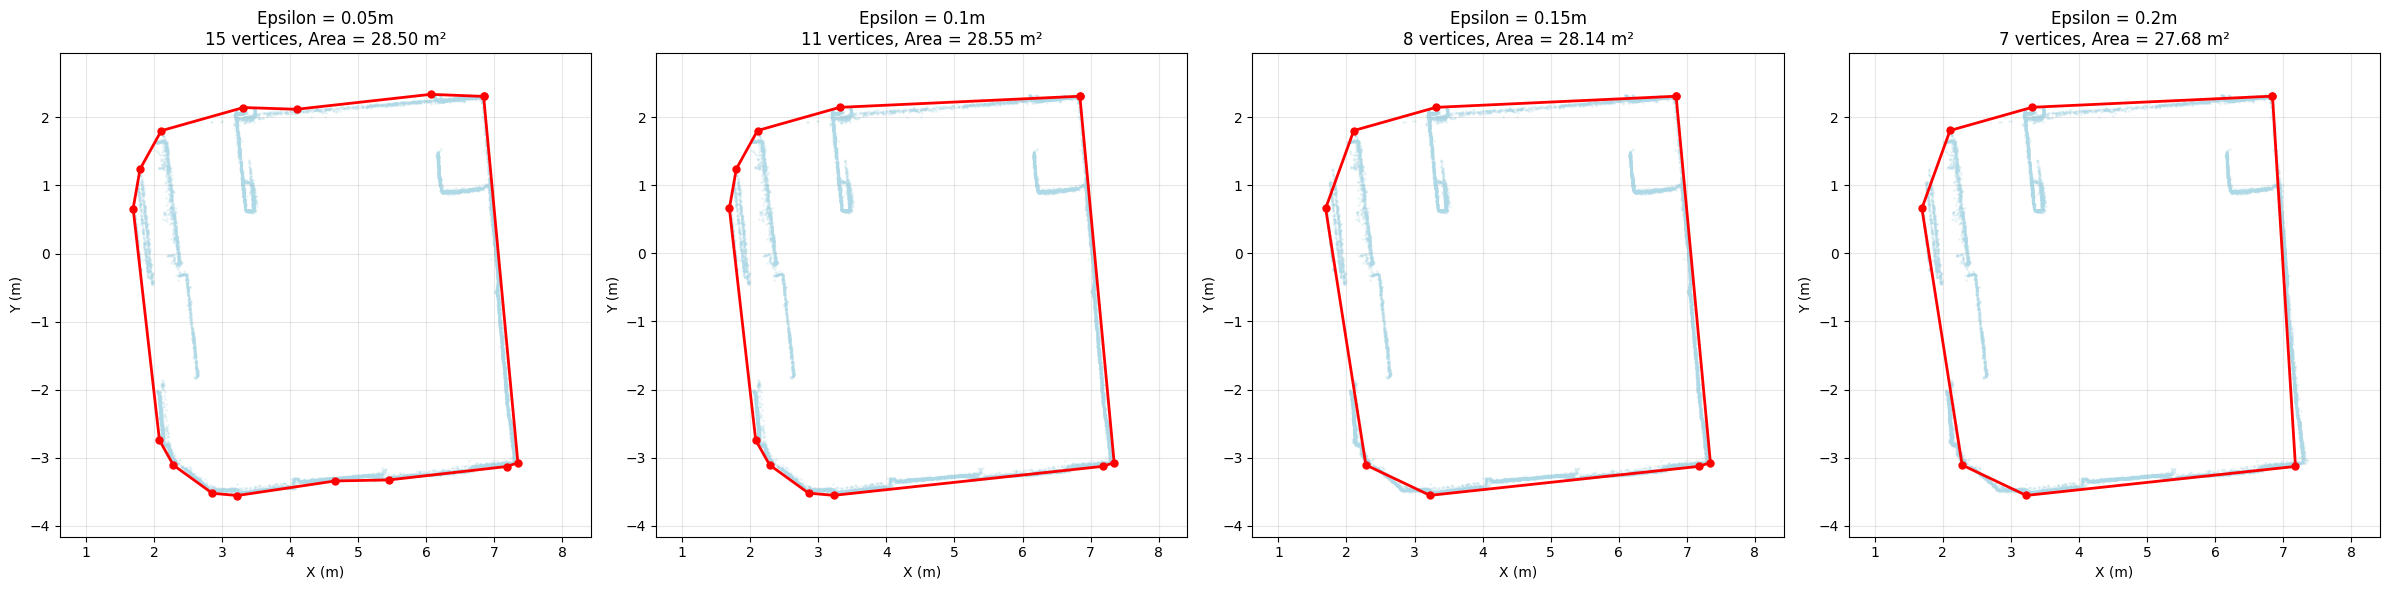

In [130]:
compare_epsilon_values(hull, epsilon_values=[0.05, 0.10, 0.15, 0.20], 
                      points_2d=points_2d)


Simplifying polygon with epsilon=0.15m...
Original: 112 vertices, area=28.42 m², perimeter=20.56 m
Simplified: 8 vertices, area=28.14 m², perimeter=20.42 m
Reduction: 104 vertices removed (92.9%)
Area change: 0.282 m² (0.99%)


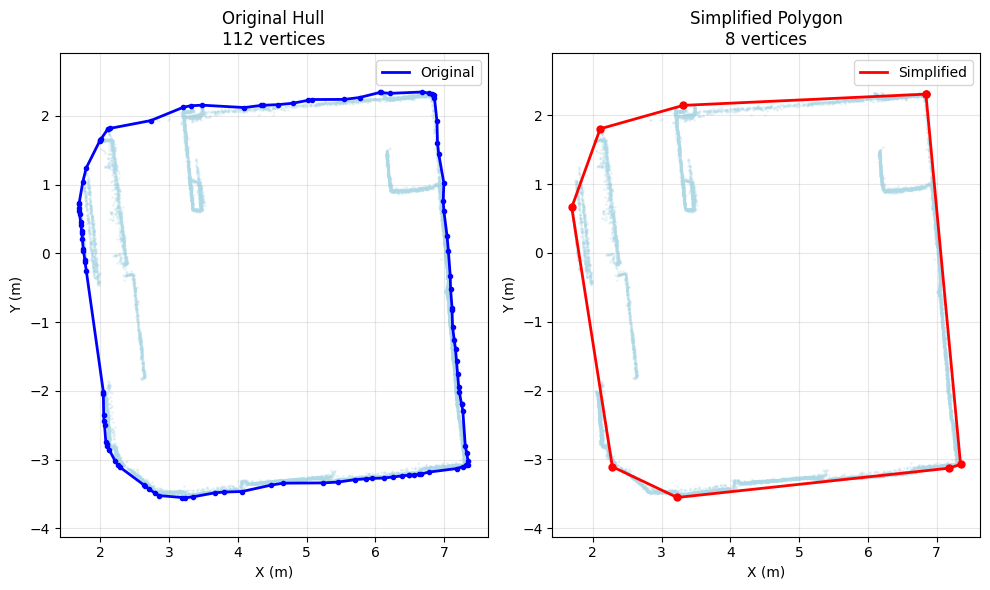

In [131]:
simplified = simplify_polygon(hull, epsilon=0.15)
visualize_simplification(hull, simplified, points_2d=points_2d)

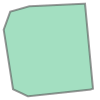

In [285]:
simplified

#### Approach 2: Wall Line Intersection

##### Extract 2D Line from Wall Segment (plane normal, PCA)

In [132]:
def extract_wall_line_2d(wall_segment, method='plane_normal'):
    """
    Extract 2D line segment from wall point cloud
    
    Takes a wall's 3D point cloud and plane equation, converts it to a 
    clean 2D line segment with start and end points.
    
    Args:
        wall_segment: Dict with:
            - 'inliers': Nx3 array of wall points
            - 'plane_model': [a, b, c, d] plane equation (ax + by + cz + d = 0)
        method: How to determine line direction
            - 'plane_normal': Use plane normal (perpendicular to wall)
            - 'pca': Use PCA on points (data-driven)
    
    Returns:
        line_info: Dict with:
            - 'start': (x, y) start point
            - 'end': (x, y) end point
            - 'direction': (dx, dy) unit vector along wall
            - 'length': length in meters
            - 'centroid': (x, y) center of wall
            - 'plane_model': original plane equation
    """
    points_3d = wall_segment['inliers']
    plane_model = wall_segment['plane_model']
    a, b, c, d = plane_model
    
    # Project to 2D (ignore Z)
    points_2d = points_3d[:, :2]
    
    if method == 'plane_normal':
        # The plane normal [a, b, c] is perpendicular to the wall
        # In 2D, the wall direction is perpendicular to [a, b]
        # Rotate [a, b] by 90° to get wall direction
        wall_direction = np.array([-b, a])
        
        # Normalize to unit vector
        norm = np.linalg.norm(wall_direction)
        if norm < 1e-6:
            print("Warning: Wall direction has zero length")
            wall_direction = np.array([1, 0])
        else:
            wall_direction = wall_direction / norm
    
    elif method == 'pca':
        # Use PCA to find principal direction of points
        centroid = points_2d.mean(axis=0)
        centered = points_2d - centroid
        
        # Covariance matrix
        cov = np.cov(centered.T)
        
        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        
        # Principal direction (eigenvector with largest eigenvalue)
        principal_idx = np.argmax(eigenvalues)
        wall_direction = eigenvectors[:, principal_idx]
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Compute wall extent
    centroid = points_2d.mean(axis=0)
    
    # Project all points onto the wall direction
    centered = points_2d - centroid
    distances = np.dot(centered, wall_direction)
    
    # Find min/max distance (wall endpoints)
    min_dist = distances.min()
    max_dist = distances.max()
    
    # Compute start and end points
    start = centroid + min_dist * wall_direction
    end = centroid + max_dist * wall_direction
    
    length = np.linalg.norm(end - start)
    
    line_info = {
        'start': start,
        'end': end,
        'direction': wall_direction,
        'length': length,
        'centroid': centroid,
        'plane_model': plane_model,
        'num_points': len(points_3d)
    }
    
    return line_info

In [141]:
def visualize_wall_line(wall_segment, line_info, title="Wall Line Extraction"):
    """
    Visualize wall points with extracted line overlaid
    
    Args:
        wall_segment: Original wall dict with 'inliers'
        line_info: Result from extract_wall_line_2d
        title: Plot title
    """
    points_3d = wall_segment['inliers']
    points_2d = points_3d[:, :2]
    
    plt.figure(figsize=(10, 6))
    
    # Plot wall points
    plt.scatter(points_2d[:, 0], points_2d[:, 1], 
                s=1, c='lightblue', alpha=0.5, label='Wall points')
    
    # Plot extracted line
    start = line_info['start']
    end = line_info['end']
    plt.plot([start[0], end[0]], [start[1], end[1]], 
             'r-', linewidth=3, label='Extracted line')
    plt.plot([start[0], end[0]], [start[1], end[1]], 
             'ro', markersize=8, label='Endpoints')
    
    # Plot centroid
    centroid = line_info['centroid']
    plt.plot(centroid[0], centroid[1], 'g*', markersize=15, label='Centroid')
    
    # Plot direction vector
    direction = line_info['direction']
    arrow_scale = line_info['length'] * 0.3
    plt.arrow(centroid[0], centroid[1], 
              direction[0] * arrow_scale, direction[1] * arrow_scale,
              head_width=0.1, head_length=0.1, fc='green', ec='green',
              label='Direction')
    
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title(f"{title}\nLength: {line_info['length']:.2f}m, "
              f"{line_info['num_points']} points")
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [142]:
def extract_all_room_wall_lines(walls, room_id, method='plane_normal'):
    """
    Extract 2D lines for all wall segments in a room
    
    Args:
        walls: Dict from detect_walls_per_room_all_clusters
        room_id: Room ID
        method: 'plane_normal' or 'pca'
    
    Returns:
        wall_lines: List of line_info dicts
    """
    if room_id not in walls:
        print(f"Room {room_id} not found")
        return []
    
    room_walls = walls[room_id]
    
    if len(room_walls) == 0:
        print(f"Room {room_id} has no walls")
        return []
    
    print(f"\nExtracting 2D lines for Room {room_id} (method={method})")
    print(f"Number of wall segments: {len(room_walls)}")
    print("="*60)
    
    wall_lines = []
    
    for i, wall in enumerate(room_walls):
        line_info = extract_wall_line_2d(wall, method=method)
        wall_lines.append(line_info)
        
        # Print info
        normal_2d = wall['plane_model'][:2]
        normal_2d = normal_2d / np.linalg.norm(normal_2d)
        
        print(f"Wall {i+1}:")
        print(f"  Points: {line_info['num_points']}")
        print(f"  Length: {line_info['length']:.2f}m")
        print(f"  Direction: [{line_info['direction'][0]:.3f}, {line_info['direction'][1]:.3f}]")
        print(f"  Normal (2D): [{normal_2d[0]:.3f}, {normal_2d[1]:.3f}]")
        print(f"  Start: ({line_info['start'][0]:.2f}, {line_info['start'][1]:.2f})")
        print(f"  End: ({line_info['end'][0]:.2f}, {line_info['end'][1]:.2f})")
    
    print("="*60)
    print(f"Extracted {len(wall_lines)} wall lines\n")
    
    return wall_lines

In [143]:
room_2_walls = walls[2]

In [153]:
wall_0 = room_2_walls[0]

In [204]:
line_info = extract_wall_line_2d(wall_0, method='pca')

In [205]:
print(f"Wall length: {line_info['length']:.2f}m")
print(f"Direction: {line_info['direction']}")

Wall length: 4.66m
Direction: [0.9958398 0.0911213]


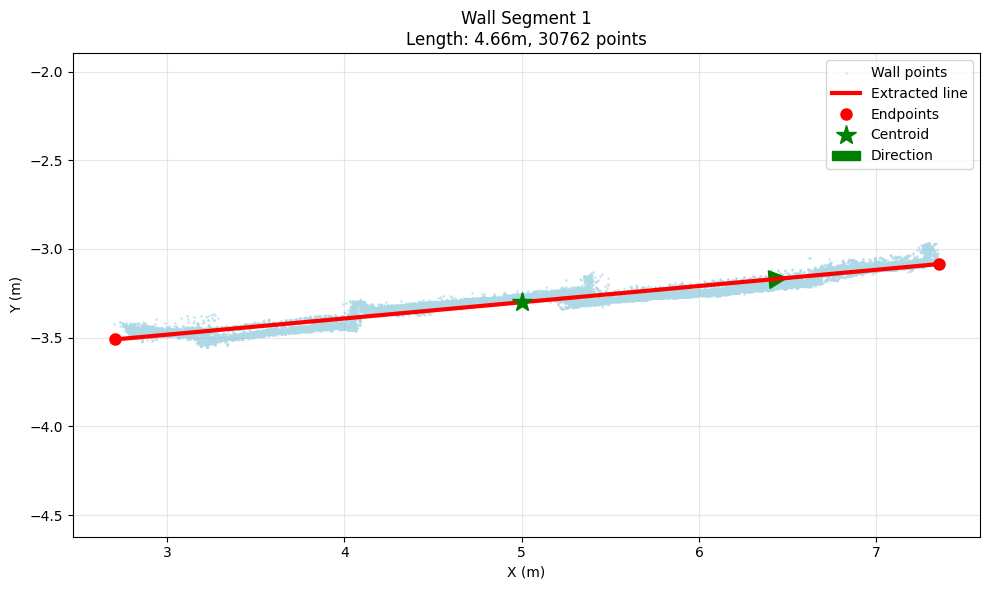

In [206]:
visualize_wall_line(wall_0, line_info, title="Wall Segment 1")

In [207]:
wall_lines = extract_all_room_wall_lines(walls, room_id=2, method='pca')


Extracting 2D lines for Room 2 (method=pca)
Number of wall segments: 11
Wall 1:
  Points: 30762
  Length: 4.66m
  Direction: [0.996, 0.091]
  Normal (2D): [-0.091, 0.996]
  Start: (2.71, -3.51)
  End: (7.35, -3.09)
Wall 2:
  Points: 27807
  Length: 5.39m
  Direction: [0.088, -0.996]
  Normal (2D): [0.996, 0.088]
  Start: (6.80, 2.36)
  End: (7.27, -3.01)
Wall 3:
  Points: 15537
  Length: 3.96m
  Direction: [0.997, 0.079]
  Normal (2D): [-0.080, 0.997]
  Start: (2.73, 1.98)
  End: (6.67, 2.29)
Wall 4:
  Points: 6796
  Length: 1.73m
  Direction: [0.104, -0.995]
  Normal (2D): [0.994, 0.108]
  Start: (1.75, 1.24)
  End: (1.94, -0.49)
Wall 5:
  Points: 9844
  Length: 1.27m
  Direction: [0.171, -0.985]
  Normal (2D): [0.994, 0.108]
  Start: (2.02, -1.87)
  End: (2.24, -3.12)
Wall 6:
  Points: 13386
  Length: 3.69m
  Direction: [0.151, -0.989]
  Normal (2D): [0.991, 0.131]
  Start: (2.10, 1.81)
  End: (2.66, -1.84)
Wall 7:
  Points: 905
  Length: 0.35m
  Direction: [0.761, -0.649]
  Normal 

In [208]:
def visualize_all_wall_lines(wall_lines, room_id=None, show_points=False, points_2d=None):
    """
    Visualize all wall lines for a room together
    
    Args:
        wall_lines: List of line_info dicts from extract_all_room_wall_lines
        room_id: Optional room ID for title
        show_points: If True, show wall points in background
        points_2d: Optional Nx2 array of all wall points (if show_points=True)
    """
    if len(wall_lines) == 0:
        print("No wall lines to visualize")
        return
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot background points if requested
    if show_points and points_2d is not None:
        ax.scatter(points_2d[:, 0], points_2d[:, 1], 
                  s=1, c='lightblue', alpha=0.2, label='Wall points')
    
    # Plot each wall line with different color
    colors = plt.cm.tab20(np.linspace(0, 1, len(wall_lines)))
    
    for i, line in enumerate(wall_lines):
        start = line['start']
        end = line['end']
        
        # Plot line
        ax.plot([start[0], end[0]], [start[1], end[1]], 
                color=colors[i], linewidth=3, label=f'Wall {i+1} ({line["length"]:.1f}m)')
        
        # Plot endpoints
        ax.plot([start[0], end[0]], [start[1], end[1]], 
                'o', color=colors[i], markersize=8)
        
        # Add wall number label at centroid
        centroid = line['centroid']
        ax.text(centroid[0], centroid[1], str(i+1), 
               fontsize=12, fontweight='bold', 
               ha='center', va='center',
               bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    
    title = f'Room {room_id} - All Wall Lines' if room_id else 'All Wall Lines'
    title += f'\n{len(wall_lines)} wall segments'
    ax.set_title(title, fontsize=14)
    
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized {len(wall_lines)} wall lines")

In [209]:
def print_wall_line_summary(wall_lines):
    """
    Print summary statistics for wall lines
    
    Args:
        wall_lines: List of line_info dicts
    """
    if len(wall_lines) == 0:
        print("No wall lines")
        return
    
    print(f"\n{'='*60}")
    print(f"WALL LINE SUMMARY")
    print('='*60)
    print(f"Total wall segments: {len(wall_lines)}")
    
    lengths = [line['length'] for line in wall_lines]
    print(f"\nLength statistics:")
    print(f"  Min: {min(lengths):.2f}m")
    print(f"  Max: {max(lengths):.2f}m")
    print(f"  Mean: {np.mean(lengths):.2f}m")
    print(f"  Median: {np.median(lengths):.2f}m")
    
    # Count by length category
    short = sum(1 for l in lengths if l < 1.0)
    medium = sum(1 for l in lengths if 1.0 <= l < 3.0)
    long = sum(1 for l in lengths if l >= 3.0)
    
    print(f"\nLength distribution:")
    print(f"  Short (<1m): {short} walls")
    print(f"  Medium (1-3m): {medium} walls")
    print(f"  Long (≥3m): {long} walls")
    
    # Check for parallel walls (same direction)
    print(f"\nChecking for parallel walls...")
    parallel_pairs = []
    
    for i in range(len(wall_lines)):
        for j in range(i+1, len(wall_lines)):
            dir1 = wall_lines[i]['direction']
            dir2 = wall_lines[j]['direction']
            
            # Dot product of unit vectors (1 = parallel, 0 = perpendicular)
            dot = abs(np.dot(dir1, dir2))
            
            if dot > 0.95:  # Nearly parallel (within ~18 degrees)
                parallel_pairs.append((i+1, j+1, dot))
    
    if len(parallel_pairs) > 0:
        print(f"  Found {len(parallel_pairs)} parallel wall pairs:")
        for w1, w2, dot in parallel_pairs[:5]:  # Show first 5
            print(f"    Wall {w1} ∥ Wall {w2} (dot={dot:.3f})")
        if len(parallel_pairs) > 5:
            print(f"    ... and {len(parallel_pairs)-5} more")
    else:
        print("  No parallel walls found")
    
    print('='*60)

In [210]:
print_wall_line_summary(wall_lines)


WALL LINE SUMMARY
Total wall segments: 11

Length statistics:
  Min: 0.35m
  Max: 5.39m
  Mean: 2.19m
  Median: 1.34m

Length distribution:
  Short (<1m): 4 walls
  Medium (1-3m): 3 walls
  Long (≥3m): 4 walls

Checking for parallel walls...
  Found 19 parallel wall pairs:
    Wall 1 ∥ Wall 3 (dot=1.000)
    Wall 1 ∥ Wall 9 (dot=0.993)
    Wall 2 ∥ Wall 4 (dot=1.000)
    Wall 2 ∥ Wall 5 (dot=0.996)
    Wall 2 ∥ Wall 6 (dot=0.998)
    ... and 14 more


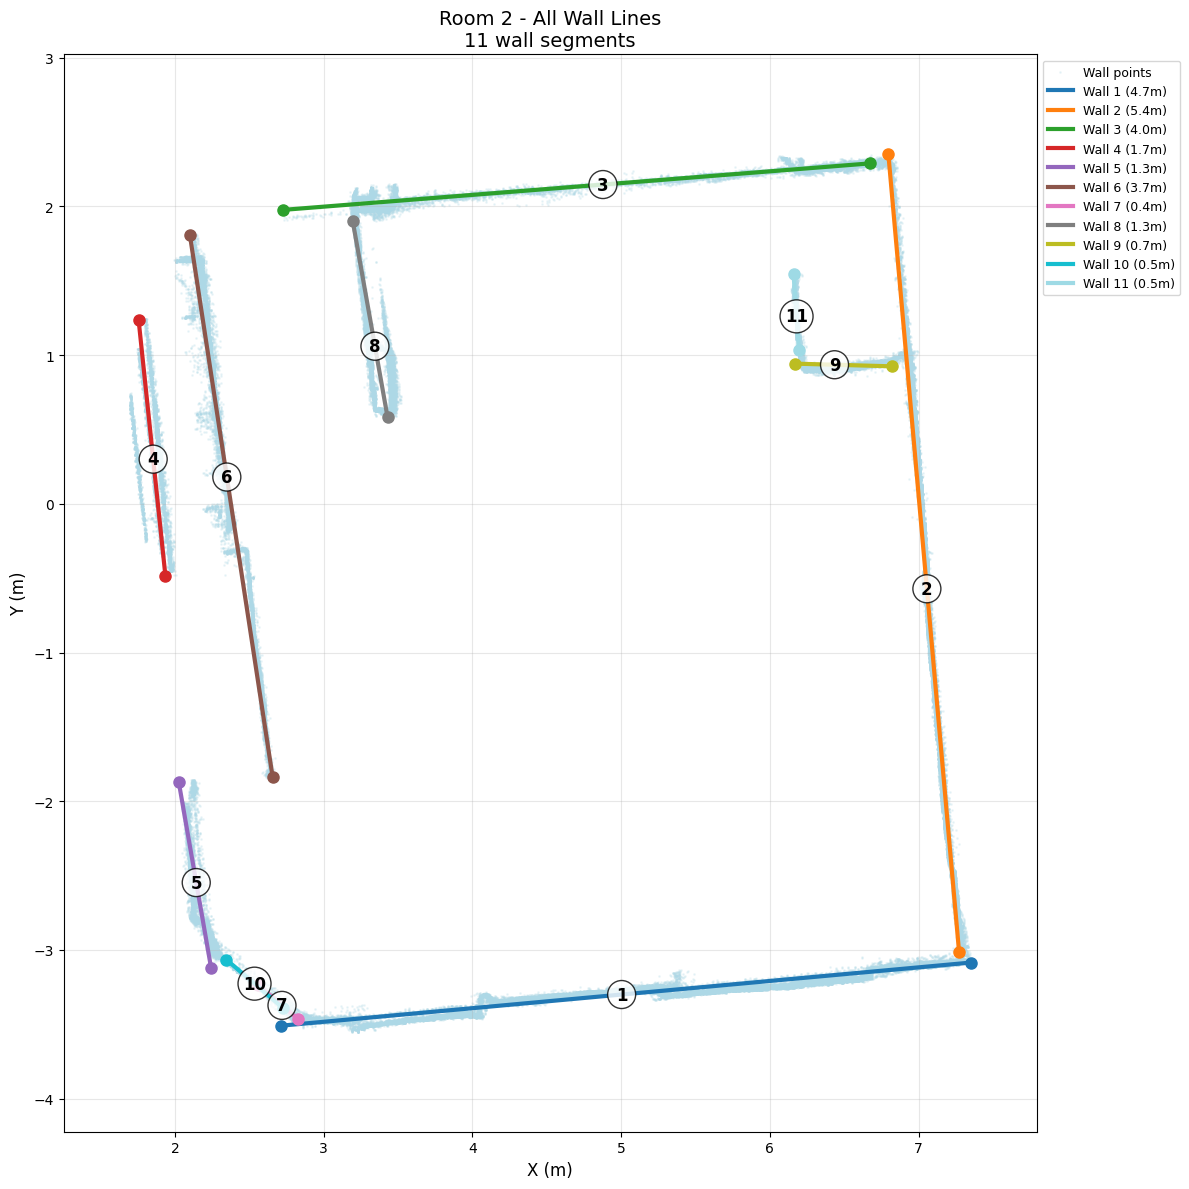


Visualized 11 wall lines


In [211]:
visualize_all_wall_lines(wall_lines, room_id=2, show_points=True, points_2d=points_2d)

In [199]:
def are_walls_collinear(line1, line2, 
                        normal_threshold=0.05,  # ~3 degrees
                        distance_threshold=0.3,  # 30cm
                        alignment_threshold=0.9):
    """
    Check if two wall lines should be merged (are part of the same physical wall)
    
    Criteria:
    1. Normals are nearly parallel (same plane orientation)
    2. Lines are spatially close (small perpendicular distance)
    3. Lines are aligned (not just parallel but on same line)
    
    Args:
        line1, line2: line_info dicts from extract_wall_line_2d
        normal_threshold: Max angle difference between normals (radians)
        distance_threshold: Max perpendicular distance between lines (m)
        alignment_threshold: Min alignment score (0-1)
    
    Returns:
        bool: True if walls should be merged
    """
    # Get plane normals (2D)
    normal1 = np.array(line1['plane_model'][:2])
    normal2 = np.array(line2['plane_model'][:2])
    
    # Normalize
    normal1 = normal1 / np.linalg.norm(normal1)
    normal2 = normal2 / np.linalg.norm(normal2)
    
    # Check 1: Are normals parallel?
    # Dot product close to ±1 means parallel (same or opposite direction)
    dot = np.dot(normal1, normal2)
    if abs(abs(dot) - 1.0) > normal_threshold:
        return False
    
    # Check 2: Are lines spatially close?
    # Compute perpendicular distance between line centers
    centroid1 = line1['centroid']
    centroid2 = line2['centroid']
    
    # Vector between centroids
    diff = centroid2 - centroid1
    
    # Project onto wall direction (line1)
    wall_dir = line1['direction']
    parallel_component = np.dot(diff, wall_dir)
    
    # Perpendicular component (distance between lines)
    perpendicular_dist = np.sqrt(np.dot(diff, diff) - parallel_component**2)
    
    if perpendicular_dist > distance_threshold:
        return False
    
    # Check 3: Are lines aligned (not just parallel)?
    # Lines are aligned if they extend in the same direction
    # (not just parallel but forming a continuous line)
    
    # Vector from line1 center to line2 center
    direction_to_other = diff / (np.linalg.norm(diff) + 1e-8)
    
    # Should be aligned with wall direction
    alignment = abs(np.dot(direction_to_other, wall_dir))
    
    if alignment < alignment_threshold:
        return False
    
    return True

In [200]:
def group_collinear_walls(wall_lines, 
                         normal_threshold=0.05,
                         distance_threshold=0.3,
                         alignment_threshold=0.9):
    """
    Group wall segments that belong to the same physical wall
    
    Uses Union-Find algorithm to group walls that are mutually collinear
    
    Args:
        wall_lines: List of line_info dicts
        normal_threshold, distance_threshold, alignment_threshold: Merging criteria
    
    Returns:
        groups: List of lists, each sublist contains indices of walls to merge
                e.g., [[0, 3, 7], [1, 4], [2], [5, 6], ...]
    """
    n = len(wall_lines)
    
    if n == 0:
        return []
    
    print(f"\nGrouping {n} wall segments...")
    print("="*60)
    
    # Build adjacency: which walls should be merged with which
    should_merge = np.zeros((n, n), dtype=bool)
    
    for i in range(n):
        for j in range(i+1, n):
            if are_walls_collinear(wall_lines[i], wall_lines[j],
                                  normal_threshold, distance_threshold, 
                                  alignment_threshold):
                should_merge[i, j] = True
                should_merge[j, i] = True
                print(f"  Wall {i+1} ↔ Wall {j+1}: Collinear (will merge)")
    
    # Union-Find to group connected walls
    parent = list(range(n))
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py
    
    # Union all walls that should be merged
    for i in range(n):
        for j in range(i+1, n):
            if should_merge[i, j]:
                union(i, j)
    
    # Group by parent
    groups_dict = {}
    for i in range(n):
        root = find(i)
        if root not in groups_dict:
            groups_dict[root] = []
        groups_dict[root].append(i)
    
    groups = list(groups_dict.values())
    
    print("="*60)
    print(f"Grouped into {len(groups)} wall groups:")
    for i, group in enumerate(groups):
        wall_nums = [idx+1 for idx in group]
        if len(group) > 1:
            print(f"  Group {i+1}: Walls {wall_nums} (MERGED)")
        else:
            print(f"  Group {i+1}: Wall {wall_nums[0]} (standalone)")
    print("="*60)
    
    return groups

In [201]:
def visualize_wall_groups(wall_lines, groups, room_id=None):
    """
    Visualize wall segments colored by group
    
    Args:
        wall_lines: List of line_info dicts
        groups: List of groups from group_collinear_walls
        room_id: Optional room ID for title
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Assign color to each group
    colors = plt.cm.tab20(np.linspace(0, 1, len(groups)))
    
    for group_idx, group in enumerate(groups):
        color = colors[group_idx]
        
        for wall_idx in group:
            line = wall_lines[wall_idx]
            start = line['start']
            end = line['end']
            
            # Plot line
            ax.plot([start[0], end[0]], [start[1], end[1]], 
                   color=color, linewidth=4, 
                   label=f'Group {group_idx+1}' if wall_idx == group[0] else '')
            
            # Plot endpoints
            ax.plot([start[0], end[0]], [start[1], end[1]], 
                   'o', color=color, markersize=6)
            
            # Add wall number
            centroid = line['centroid']
            ax.text(centroid[0], centroid[1], str(wall_idx+1), 
                   fontsize=10, fontweight='bold',
                   ha='center', va='center',
                   bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    
    title = f'Room {room_id} - Wall Groups' if room_id else 'Wall Groups'
    title += f'\n{len(groups)} groups from {len(wall_lines)} segments'
    ax.set_title(title, fontsize=14)
    
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    
    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), 
             loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

In [248]:
groups = group_collinear_walls(
    wall_lines,
    normal_threshold=0.05,     # ~3 degrees tolerance
    distance_threshold=0.3,    # 30cm max distance
    alignment_threshold=0.9    # Must be well-aligned
)


Grouping 11 wall segments...
  Wall 4 ↔ Wall 5: Collinear (will merge)
  Wall 5 ↔ Wall 10: Collinear (will merge)
  Wall 6 ↔ Wall 7: Collinear (will merge)
  Wall 7 ↔ Wall 10: Collinear (will merge)
Grouped into 7 wall groups:
  Group 1: Wall 1 (standalone)
  Group 2: Wall 2 (standalone)
  Group 3: Wall 3 (standalone)
  Group 4: Walls [4, 5, 6, 7, 10] (MERGED)
  Group 5: Wall 8 (standalone)
  Group 6: Wall 9 (standalone)
  Group 7: Wall 11 (standalone)


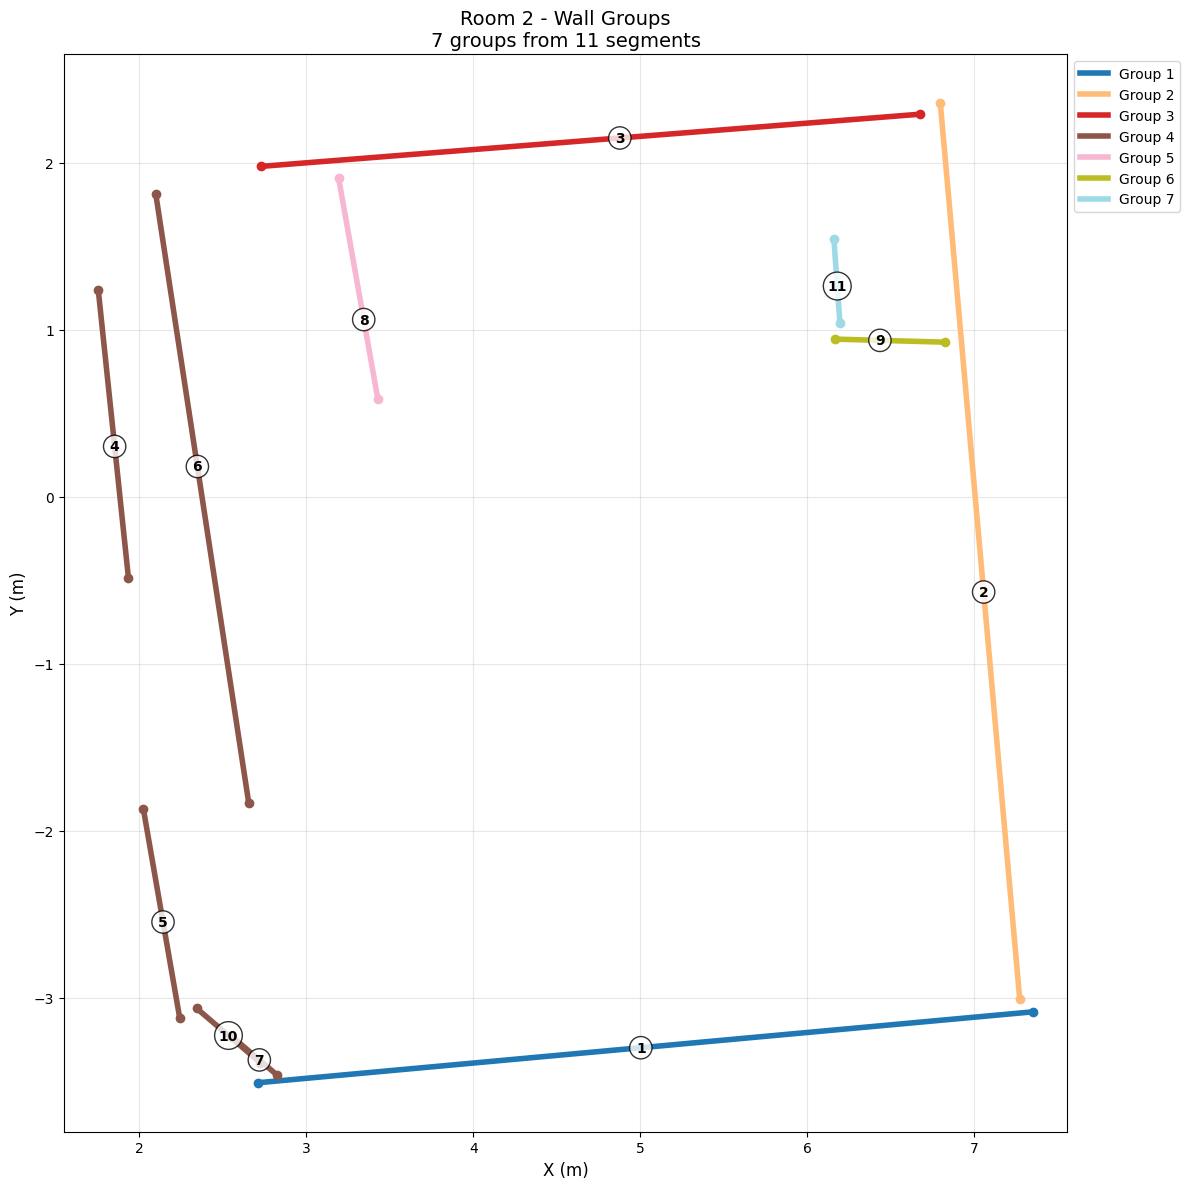

In [249]:
visualize_wall_groups(wall_lines, groups, room_id=2)

In [254]:
def merge_wall_group(group_walls, group_indices, method='pca'):
    """
    Merge multiple wall segments into one by combining their point clouds
    and extracting a single line
    
    Args:
        group_walls: List of wall dicts to merge (already extracted from room)
        group_indices: List of original wall indices (for tracking)
        method: 'pca' or 'plane_normal' for line extraction
    
    Returns:
        merged_wall: Dict with combined points and extracted line
    """
    # from intersection_step1_extract_line import extract_wall_line_2d
    
    if len(group_walls) == 0:
        return None
    
    # Collect all points from walls in this group
    all_points = []
    all_plane_models = []
    
    for wall in group_walls:
        all_points.append(wall['inliers'])
        all_plane_models.append(wall['plane_model'])
    
    # Combine points
    combined_points_3d = np.vstack(all_points)
    
    # Average plane model (for reference)
    avg_plane_model = np.mean(all_plane_models, axis=0)
    
    # Create merged wall segment
    merged_wall_segment = {
        'inliers': combined_points_3d,
        'plane_model': avg_plane_model,
        'num_inliers': len(combined_points_3d),
        'group_indices': group_indices,
        'num_segments': len(group_walls)
    }
    
    # Extract line from merged points
    line_info = extract_wall_line_2d(merged_wall_segment, method=method)
    
    # Add group info to line
    line_info['group_indices'] = group_indices
    line_info['num_segments_merged'] = len(group_walls)
    
    return line_info

In [244]:
def merge_all_groups(walls, room_id, groups, method='pca'):
    """
    Merge all wall groups for a room
    
    Args:
        walls: Dict from detect_walls_per_room_all_clusters
        room_id: Room ID
        groups: List of groups from group_collinear_walls
        method: 'pca' or 'plane_normal'
    
    Returns:
        merged_lines: List of line_info dicts (one per group)
    """
    if room_id not in walls:
        print(f"Room {room_id} not found")
        return []
    
    room_walls = walls[room_id]
    
    print(f"\n{'='*60}")
    print(f"MERGING WALL GROUPS FOR ROOM {room_id} (method={method})")
    print('='*60)
    print(f"Input: {len(room_walls)} wall segments")
    print(f"Groups: {len(groups)} groups")
    
    merged_lines = []
    
    for i, group in enumerate(groups):
        print(f"\nGroup {i+1}:")
        
        # Get walls for this group
        group_walls = [room_walls[idx] for idx in group]
        
        # Merge
        merged_line = merge_wall_group(group_walls, group, method=method)
        
        if merged_line is not None:
            wall_nums = [idx+1 for idx in group]
            
            if len(group) > 1:
                print(f"  Merged walls {wall_nums}")
                print(f"  Total points: {merged_line['num_points']}")
                print(f"  Line length: {merged_line['length']:.2f}m")
            else:
                print(f"  Wall {wall_nums[0]} (standalone)")
                print(f"  Points: {merged_line['num_points']}")
                print(f"  Line length: {merged_line['length']:.2f}m")
            
            merged_lines.append(merged_line)
    
    print('='*60)
    print(f"Result: {len(merged_lines)} merged wall lines")
    print('='*60)
    
    return merged_lines

In [245]:
def visualize_merged_lines(merged_lines, room_id=None, show_points=False, points_2d=None):
    """
    Visualize merged wall lines
    
    Args:
        merged_lines: List of line_info dicts from merge_all_groups
        room_id: Optional room ID for title
        show_points: If True, show background points
        points_2d: Optional Nx2 array of all points
    """
    if len(merged_lines) == 0:
        print("No merged lines to visualize")
        return
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Background points
    if show_points and points_2d is not None:
        ax.scatter(points_2d[:, 0], points_2d[:, 1], 
                  s=1, c='lightblue', alpha=0.2, label='Wall points')
    
    # Plot merged lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(merged_lines)))
    
    for i, line in enumerate(merged_lines):
        start = line['start']
        end = line['end']
        
        # Determine label
        if line.get('num_segments_merged', 1) > 1:
            wall_nums = [idx+1 for idx in line['group_indices']]
            label = f'Merged {wall_nums} ({line["length"]:.1f}m)'
        else:
            wall_num = line['group_indices'][0] + 1
            label = f'Wall {wall_num} ({line["length"]:.1f}m)'
        
        # Plot line
        ax.plot([start[0], end[0]], [start[1], end[1]], 
               color=colors[i], linewidth=4, label=label)
        
        # Endpoints
        ax.plot([start[0], end[0]], [start[1], end[1]], 
               'o', color=colors[i], markersize=8)
        
        # Label
        centroid = line['centroid']
        ax.text(centroid[0], centroid[1], str(i+1), 
               fontsize=12, fontweight='bold',
               ha='center', va='center',
               bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    
    title = f'Room {room_id} - Merged Wall Lines' if room_id else 'Merged Wall Lines'
    title += f'\n{len(merged_lines)} lines from merged groups'
    ax.set_title(title, fontsize=14)
    
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
    plt.tight_layout()
    plt.show()

In [246]:
def print_merged_lines_summary(merged_lines):
    """
    Print summary of merged lines
    """
    print(f"\n{'='*60}")
    print("MERGED LINES SUMMARY")
    print('='*60)
    print(f"Total lines: {len(merged_lines)}")
    
    for i, line in enumerate(merged_lines):
        print(f"\nLine {i+1}:")
        print(f"  Length: {line['length']:.2f}m")
        print(f"  Points: {line['num_points']}")
        print(f"  Direction: [{line['direction'][0]:.3f}, {line['direction'][1]:.3f}]")
        
        if line.get('num_segments_merged', 1) > 1:
            wall_nums = [idx+1 for idx in line['group_indices']]
            print(f"  Merged from: Walls {wall_nums}")
        else:
            wall_num = line['group_indices'][0] + 1
            print(f"  Original: Wall {wall_num}")
    
    print('='*60)

In [255]:
merged_lines_pca = merge_all_groups(walls, room_id=2, groups=groups, method='pca')


MERGING WALL GROUPS FOR ROOM 2 (method=pca)
Input: 11 wall segments
Groups: 7 groups

Group 1:
  Wall 1 (standalone)
  Points: 30762
  Line length: 4.66m

Group 2:
  Wall 2 (standalone)
  Points: 27807
  Line length: 5.39m

Group 3:
  Wall 3 (standalone)
  Points: 15537
  Line length: 3.96m

Group 4:
  Merged walls [4, 5, 6, 7, 10]
  Total points: 32670
  Line length: 5.30m

Group 5:
  Wall 8 (standalone)
  Points: 11911
  Line length: 1.34m

Group 6:
  Wall 9 (standalone)
  Points: 4834
  Line length: 0.66m

Group 7:
  Wall 11 (standalone)
  Points: 2918
  Line length: 0.51m
Result: 7 merged wall lines


In [256]:
merged_lines_pca

[{'start': array([ 2.71027319, -3.51010661]),
  'end': array([ 7.35178965, -3.0853987 ]),
  'direction': array([0.9958398, 0.0911213]),
  'length': np.float64(4.660906762580021),
  'centroid': array([ 5.00340206, -3.30028079]),
  'plane_model': array([-0.09135942,  0.99563448,  0.01911638,  3.74205363]),
  'num_points': 30762,
  'group_indices': [0],
  'num_segments_merged': 1},
 {'start': array([6.79700093, 2.35520907]),
  'end': array([ 7.27267023, -3.01148236]),
  'direction': array([ 0.08828751, -0.99609503]),
  'length': np.float64(5.387730345223799),
  'centroid': array([ 7.05638652, -0.5712829 ]),
  'plane_model': array([ 9.96089321e-01,  8.82670363e-02, -3.87222361e-03, -6.97750690e+00]),
  'num_points': 27807,
  'group_indices': [1],
  'num_segments_merged': 1},
 {'start': array([2.72696479, 1.97725532]),
  'end': array([6.67467095, 2.28993939]),
  'direction': array([0.99687785, 0.07895923]),
  'length': np.float64(3.960070104163939),
  'centroid': array([4.877667  , 2.147604

In [257]:
print_merged_lines_summary(merged_lines_pca)


MERGED LINES SUMMARY
Total lines: 7

Line 1:
  Length: 4.66m
  Points: 30762
  Direction: [0.996, 0.091]
  Original: Wall 1

Line 2:
  Length: 5.39m
  Points: 27807
  Direction: [0.088, -0.996]
  Original: Wall 2

Line 3:
  Length: 3.96m
  Points: 15537
  Direction: [0.997, 0.079]
  Original: Wall 3

Line 4:
  Length: 5.30m
  Points: 32670
  Direction: [0.058, -0.998]
  Merged from: Walls [4, 5, 6, 7, 10]

Line 5:
  Length: 1.34m
  Points: 11911
  Direction: [0.175, -0.985]
  Original: Wall 8

Line 6:
  Length: 0.66m
  Points: 4834
  Direction: [1.000, -0.028]
  Original: Wall 9

Line 7:
  Length: 0.51m
  Points: 2918
  Direction: [0.071, -0.997]
  Original: Wall 11


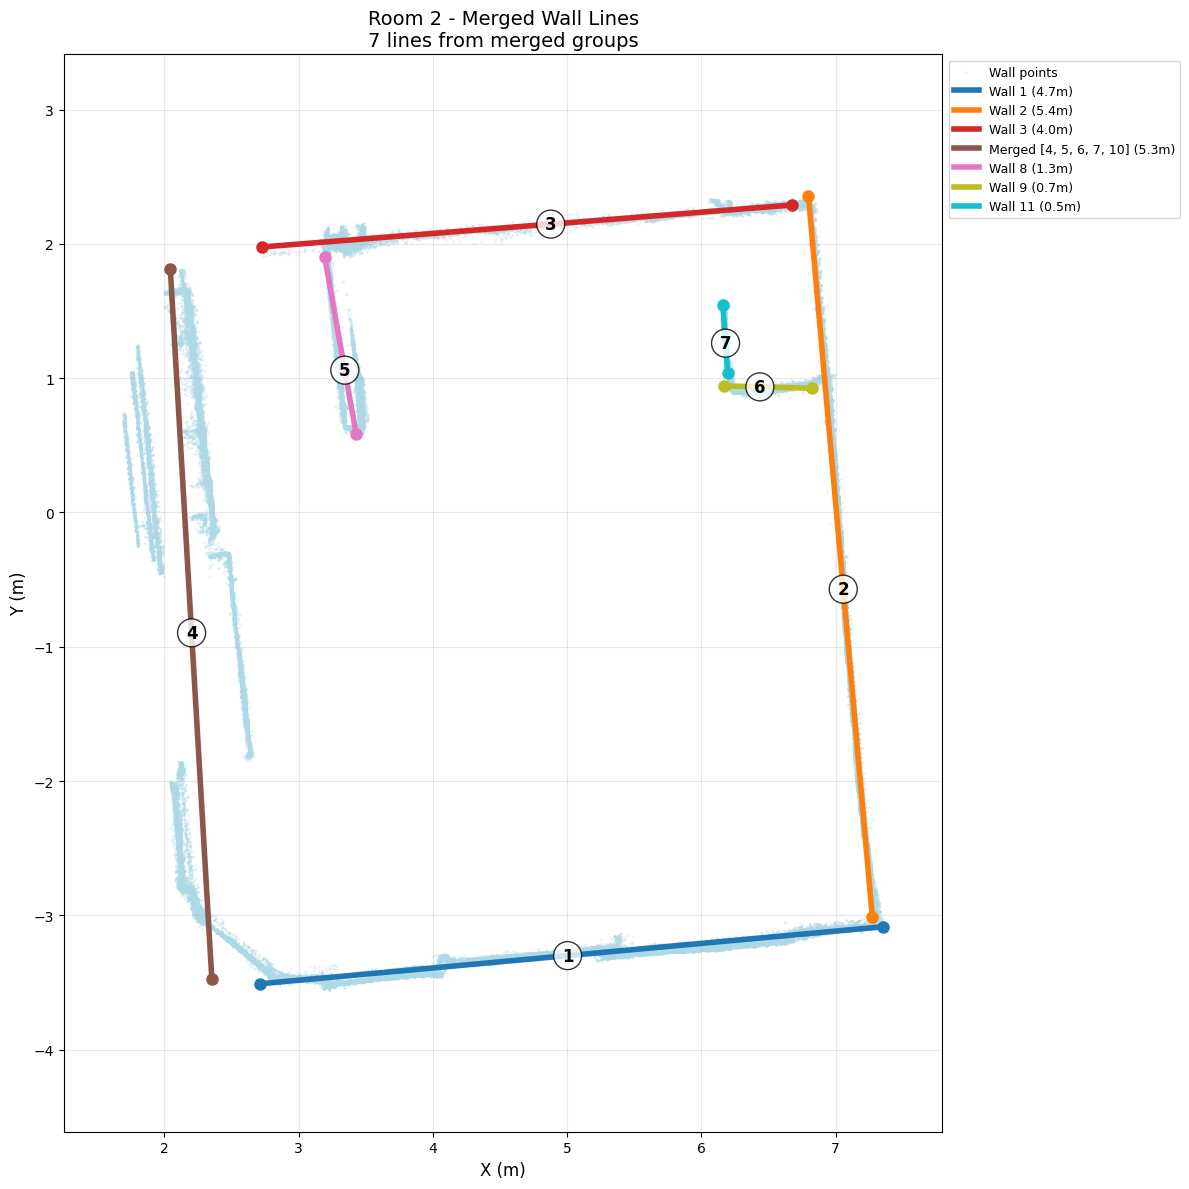

In [258]:
visualize_merged_lines(merged_lines_pca, room_id=2, show_points=True, points_2d=points_2d)

##### Find Line Intersections 

In [259]:
def line_intersection_2d(line1, line2):
    """
    Find intersection point of two 2D lines (infinite extension)
    
    Line representation: point + direction
    Line1: P1 + t * d1
    Line2: P2 + s * d2
    
    Args:
        line1: Dict with 'start', 'end', 'direction'
        line2: Dict with 'start', 'end', 'direction'
    
    Returns:
        intersection: (x, y) array or None if parallel
    """
    # Use line centers as reference points
    p1 = line1['centroid']
    p2 = line2['centroid']
    
    # Direction vectors
    d1 = line1['direction']
    d2 = line2['direction']
    
    # Check if parallel (cross product = 0 in 2D)
    cross = d1[0] * d2[1] - d1[1] * d2[0]
    
    if abs(cross) < 1e-6:
        # Lines are parallel
        return None
    
    # Solve: p1 + t*d1 = p2 + s*d2
    # p1 - p2 = s*d2 - t*d1
    # In matrix form: [d1 | -d2] * [t; s] = p2 - p1
    
    diff = p2 - p1
    
    # Compute t parameter
    t = (diff[0] * d2[1] - diff[1] * d2[0]) / cross
    
    # Intersection point
    intersection = p1 + t * d1
    
    return intersection

In [260]:
def find_all_intersections(wall_lines, parallel_threshold=0.95):
    """
    Find all intersection points between non-parallel wall lines
    
    Args:
        wall_lines: List of line_info dicts
        parallel_threshold: Dot product threshold for considering lines parallel
                           (1.0 = perfectly parallel, 0.0 = perpendicular)
    
    Returns:
        intersections: List of tuples (intersection_point, line1_idx, line2_idx)
    """
    n = len(wall_lines)
    intersections = []
    
    print(f"\n{'='*60}")
    print(f"FINDING LINE INTERSECTIONS")
    print('='*60)
    print(f"Testing {n} lines ({n*(n-1)//2} pairs)")
    
    num_parallel = 0
    num_intersections = 0
    
    for i in range(n):
        for j in range(i+1, n):
            line1 = wall_lines[i]
            line2 = wall_lines[j]
            
            # Check if parallel
            dir1 = line1['direction']
            dir2 = line2['direction']
            
            dot = abs(np.dot(dir1, dir2))
            
            if dot > parallel_threshold:
                num_parallel += 1
                continue
            
            # Find intersection
            intersection = line_intersection_2d(line1, line2)
            
            if intersection is not None:
                intersections.append((intersection, i, j))
                num_intersections += 1
                
                print(f"  Line {i+1} × Line {j+1}: intersection at ({intersection[0]:.2f}, {intersection[1]:.2f})")
    
    print(f"\nResults:")
    print(f"  Parallel pairs skipped: {num_parallel}")
    print(f"  Intersections found: {num_intersections}")
    print('='*60)
    
    return intersections

In [261]:
def filter_intersections_by_proximity(intersections, wall_lines, max_distance=1.0):
    """
    Filter intersections to keep only those close to at least one of the walls
    
    This removes spurious intersections from extended lines that are far from actual walls
    
    Args:
        intersections: List from find_all_intersections
        wall_lines: List of line_info dicts
        max_distance: Maximum distance from intersection to nearest wall line (m)
    
    Returns:
        filtered_intersections: List of valid intersections
    """
    print(f"\nFiltering intersections (max_distance={max_distance}m)...")
    
    filtered = []
    
    for intersection, i, j in intersections:
        line1 = wall_lines[i]
        line2 = wall_lines[j]
        
        # Distance from intersection to each line's extent
        # Check if intersection is near the actual wall segments
        
        # For line 1: distance to line segment [start, end]
        start1 = line1['start']
        end1 = line1['end']
        
        # Project intersection onto line direction
        vec_to_int = intersection - line1['centroid']
        proj_dist1 = np.dot(vec_to_int, line1['direction'])
        
        # Distance from line center
        half_length1 = line1['length'] / 2
        
        # How far beyond the line segment?
        overshoot1 = max(0, abs(proj_dist1) - half_length1)
        
        # Same for line 2
        vec_to_int2 = intersection - line2['centroid']
        proj_dist2 = np.dot(vec_to_int2, line2['direction'])
        half_length2 = line2['length'] / 2
        overshoot2 = max(0, abs(proj_dist2) - half_length2)
        
        # Keep if intersection is close to at least one wall
        min_overshoot = min(overshoot1, overshoot2)
        
        if min_overshoot <= max_distance:
            filtered.append((intersection, i, j))
            status = "✓"
        else:
            status = "✗"
        
        print(f"  {status} Line {i+1} × Line {j+1}: overshoot={min_overshoot:.2f}m")
    
    print(f"\nKept {len(filtered)}/{len(intersections)} intersections")
    
    return filtered

In [262]:
def order_corners_ccw(corners):
    """
    Order corner points counter-clockwise around centroid
    
    Args:
        corners: List of (x, y) points or Nx2 array
    
    Returns:
        ordered_corners: Nx2 array ordered counter-clockwise
    """
    if len(corners) == 0:
        return np.array([])
    
    corners = np.array(corners)
    
    # Compute centroid
    centroid = corners.mean(axis=0)
    
    # Compute angle from centroid
    angles = np.arctan2(corners[:, 1] - centroid[1], 
                        corners[:, 0] - centroid[0])
    
    # Sort by angle
    sorted_indices = np.argsort(angles)
    ordered = corners[sorted_indices]
    
    return ordered

In [263]:
def create_polygon_from_intersections(intersections, snap_grid=None):
    """
    Create polygon from intersection points
    
    Args:
        intersections: List of tuples (point, line1_idx, line2_idx)
        snap_grid: Optional grid size for snapping (m)
    
    Returns:
        polygon_info: Dict with vertices, polygon, area, etc.
    """
    if len(intersections) < 3:
        print("Not enough intersections to form polygon")
        return None
    
    # Extract just the points
    corners = np.array([inter[0] for inter in intersections])
    
    print(f"\nCreating polygon from {len(corners)} corners...")
    
    # Order corners
    ordered_corners = order_corners_ccw(corners)
    
    # Optional: snap to grid
    if snap_grid is not None:
        print(f"Snapping to {snap_grid*100:.0f}cm grid...")
        ordered_corners = np.round(ordered_corners / snap_grid) * snap_grid
    
    # Create Shapely polygon
    try:
        polygon = Polygon(ordered_corners)
        
        if not polygon.is_valid:
            print("Warning: Polygon is invalid (self-intersecting?)")
            # Try to fix
            polygon = polygon.buffer(0)
        
        polygon_info = {
            'vertices': ordered_corners,
            'num_vertices': len(ordered_corners),
            'area': polygon.area,
            'perimeter': polygon.length,
            'shapely_polygon': polygon,
            'method': 'intersection'
        }
        
        print(f"✓ Polygon created:")
        print(f"  Vertices: {len(ordered_corners)}")
        print(f"  Area: {polygon.area:.2f} m²")
        print(f"  Perimeter: {polygon.length:.2f} m")
        
        return polygon_info
    
    except Exception as e:
        print(f"Failed to create polygon: {e}")
        return None

In [264]:
def visualize_intersections(wall_lines, intersections, polygon_info=None, 
                           room_id=None, points_2d=None):
    """
    Visualize wall lines, intersections, and resulting polygon
    
    Args:
        wall_lines: List of line_info dicts
        intersections: List from find_all_intersections or filtered
        polygon_info: Optional polygon from create_polygon_from_intersections
        room_id: Optional room ID
        points_2d: Optional background points
    """
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Background points
    if points_2d is not None:
        ax.scatter(points_2d[:, 0], points_2d[:, 1], 
                  s=0.5, c='lightblue', alpha=0.1, label='Wall points')
    
    # Wall lines
    colors = plt.cm.tab10(np.linspace(0, 1, len(wall_lines)))
    
    for i, line in enumerate(wall_lines):
        start = line['start']
        end = line['end']
        
        # Extend line for visualization
        direction = line['direction']
        length = line['length']
        extension = length * 0.3  # Extend 30% beyond endpoints
        
        extended_start = start - extension * direction
        extended_end = end + extension * direction
        
        # Plot extended line (thin, dashed)
        ax.plot([extended_start[0], extended_end[0]], 
               [extended_start[1], extended_end[1]],
               '--', color=colors[i], linewidth=1, alpha=0.3)
        
        # Plot actual wall segment (thick)
        ax.plot([start[0], end[0]], [start[1], end[1]],
               color=colors[i], linewidth=3, label=f'Line {i+1}')
        
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'o', color=colors[i], markersize=6)
    
    # Intersection points
    if len(intersections) > 0:
        inter_points = np.array([inter[0] for inter in intersections])
        ax.scatter(inter_points[:, 0], inter_points[:, 1],
                  s=100, c='red', marker='X', edgecolors='black', linewidths=2,
                  label='Intersections', zorder=10)
        
        # Number each intersection
        for idx, (point, i, j) in enumerate(intersections):
            ax.text(point[0], point[1], f' {idx+1}', 
                   fontsize=9, color='red', fontweight='bold')
    
    # Polygon
    if polygon_info is not None:
        vertices = polygon_info['vertices']
        # Close the polygon
        poly_coords = np.vstack([vertices, vertices[0]])
        ax.plot(poly_coords[:, 0], poly_coords[:, 1],
               'g-', linewidth=3, label='Polygon', alpha=0.7)
        ax.plot(vertices[:, 0], vertices[:, 1],
               'go', markersize=10, markeredgecolor='black', markeredgewidth=2)
    
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    
    title = f'Room {room_id} - ' if room_id else ''
    title += f'Line Intersections'
    if polygon_info:
        title += f'\n{polygon_info["num_vertices"]} vertices, Area: {polygon_info["area"]:.2f} m²'
    
    ax.set_title(title, fontsize=14)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
    plt.tight_layout()
    plt.show()

In [266]:
intersections = find_all_intersections(wall_lines, parallel_threshold=0.95)


FINDING LINE INTERSECTIONS
Testing 11 lines (55 pairs)
  Line 1 × Line 2: intersection at (7.28, -3.09)
  Line 1 × Line 4: intersection at (2.26, -3.55)
  Line 1 × Line 5: intersection at (2.32, -3.55)
  Line 1 × Line 6: intersection at (2.91, -3.49)
  Line 1 × Line 7: intersection at (2.86, -3.50)
  Line 1 × Line 8: intersection at (4.13, -3.38)
  Line 1 × Line 10: intersection at (2.85, -3.50)
  Line 1 × Line 11: intersection at (6.50, -3.16)
  Line 2 × Line 3: intersection at (6.80, 2.30)
  Line 2 × Line 7: intersection at (7.68, -7.60)
  Line 2 × Line 9: intersection at (6.92, 0.92)
  Line 2 × Line 10: intersection at (7.68, -7.62)
  Line 3 × Line 4: intersection at (1.69, 1.89)
  Line 3 × Line 5: intersection at (1.37, 1.87)
  Line 3 × Line 6: intersection at (2.08, 1.93)
  Line 3 × Line 7: intersection at (-3.02, 1.52)
  Line 3 × Line 8: intersection at (3.17, 2.01)
  Line 3 × Line 10: intersection at (-3.03, 1.52)
  Line 3 × Line 11: intersection at (6.11, 2.25)
  Line 4 × Line

In [342]:
filtered_intersections = filter_intersections_by_proximity(
    intersections, 
    wall_lines, 
    max_distance=0.2
)


Filtering intersections (max_distance=0.2m)...
  ✓ Line 1 × Line 2: overshoot=0.00m
  ✗ Line 1 × Line 4: overshoot=0.43m
  ✗ Line 1 × Line 5: overshoot=0.37m
  ✓ Line 1 × Line 6: overshoot=0.00m
  ✓ Line 1 × Line 7: overshoot=0.00m
  ✓ Line 1 × Line 8: overshoot=0.00m
  ✓ Line 1 × Line 10: overshoot=0.00m
  ✓ Line 1 × Line 11: overshoot=0.00m
  ✓ Line 2 × Line 3: overshoot=0.00m
  ✗ Line 2 × Line 7: overshoot=4.36m
  ✓ Line 2 × Line 9: overshoot=0.00m
  ✗ Line 2 × Line 10: overshoot=4.38m
  ✗ Line 3 × Line 4: overshoot=0.74m
  ✗ Line 3 × Line 5: overshoot=1.54m
  ✓ Line 3 × Line 6: overshoot=0.00m
  ✗ Line 3 × Line 7: overshoot=5.95m
  ✓ Line 3 × Line 8: overshoot=0.00m
  ✗ Line 3 × Line 10: overshoot=5.95m
  ✓ Line 3 × Line 11: overshoot=0.00m
  ✗ Line 4 × Line 7: overshoot=0.52m
  ✓ Line 4 × Line 9: overshoot=0.00m
  ✓ Line 4 × Line 10: overshoot=0.20m
  ✓ Line 5 × Line 7: overshoot=0.00m
  ✗ Line 5 × Line 9: overshoot=3.04m
  ✓ Line 5 × Line 10: overshoot=0.00m
  ✓ Line 6 × Line 7:

In [343]:
polygon_info = create_polygon_from_intersections(filtered_intersections, snap_grid=0.01)


Creating polygon from 19 corners...
Snapping to 1cm grid...
✓ Polygon created:
  Vertices: 19
  Area: 26.14 m²
  Perimeter: 23.17 m


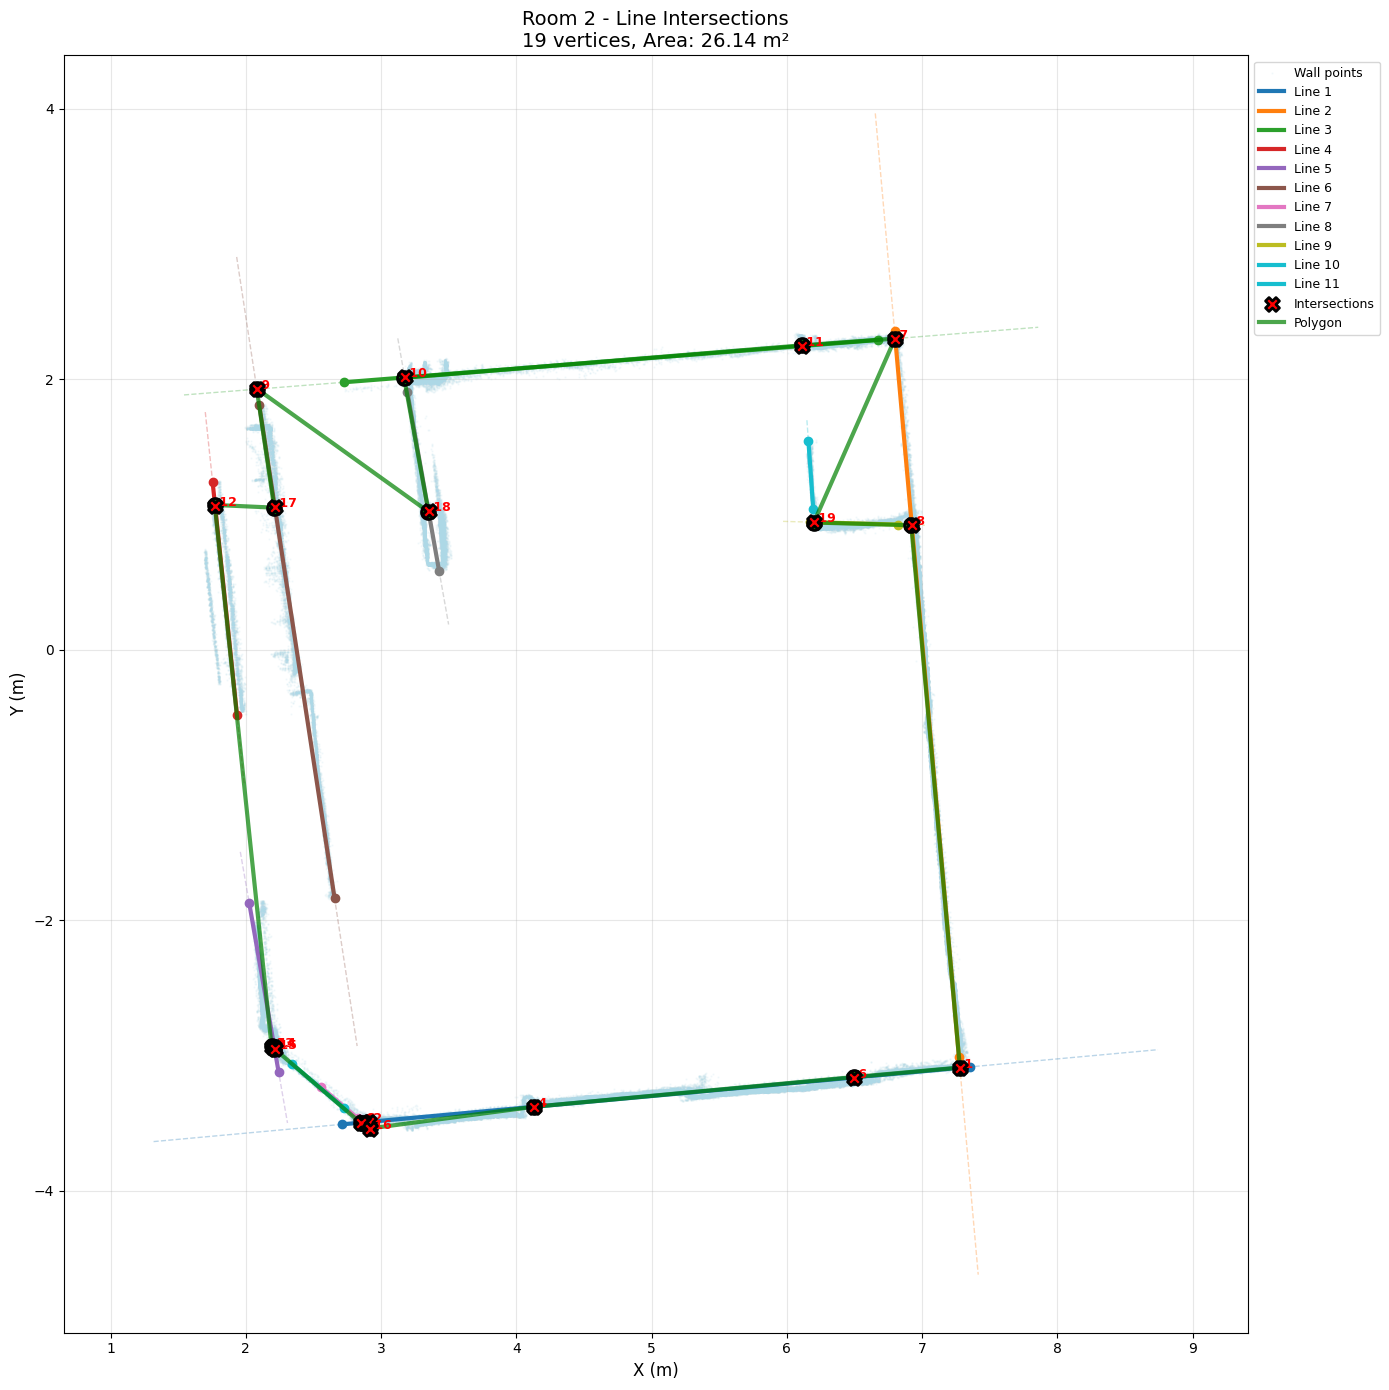

In [344]:
visualize_intersections(wall_lines, filtered_intersections, polygon_info, 
                       room_id=2, points_2d=points_2d)

#####  Hybrid Approach

In [279]:
def classify_walls_boundary_vs_interior(wall_lines, boundary_polygon, 
                                        distance_threshold=0.3,
                                        coverage_threshold=0.7):
    """
    Classify walls as boundary (room perimeter) or interior (structural elements)
    
    A wall is considered BOUNDARY if:
    1. Its centerline is close to the boundary polygon edge
    2. A significant portion of the wall overlaps with the boundary
    
    A wall is INTERIOR if:
    1. Its centerline is far from boundary edges
    2. It's completely inside the room
    
    Args:
        wall_lines: List of line_info dicts (with start, end, centroid)
        boundary_polygon: Shapely Polygon from hull method
        distance_threshold: Max distance from boundary to be considered boundary wall (m)
        coverage_threshold: Min fraction of wall that must be near boundary (0-1)
    
    Returns:
        classification: Dict with 'boundary' and 'interior' lists of wall indices
    """
    print(f"\n{'='*60}")
    print("CLASSIFYING WALLS: BOUNDARY vs INTERIOR")
    print('='*60)
    print(f"Total walls: {len(wall_lines)}")
    print(f"Distance threshold: {distance_threshold}m")
    print(f"Coverage threshold: {coverage_threshold*100:.0f}%")
    
    boundary_indices = []
    interior_indices = []
    
    # Get boundary as LineString for distance calculations
    boundary_line = LineString(boundary_polygon.exterior.coords)
    
    for i, wall in enumerate(wall_lines):
        # Sample points along the wall
        start = wall['start']
        end = wall['end']
        
        # Sample 10 points along the wall
        num_samples = 10
        t_values = np.linspace(0, 1, num_samples)
        wall_points = np.array([start + t * (end - start) for t in t_values])
        
        # Check distance from each point to boundary
        distances = []
        for point in wall_points:
            p = Point(point)
            dist = p.distance(boundary_line)
            distances.append(dist)
        
        distances = np.array(distances)
        
        # What fraction of wall is close to boundary?
        close_points = np.sum(distances < distance_threshold)
        coverage = close_points / num_samples
        
        # Average distance
        avg_distance = np.mean(distances)
        min_distance = np.min(distances)
        
        # Classification
        is_boundary = coverage >= coverage_threshold
        
        if is_boundary:
            boundary_indices.append(i)
            category = "BOUNDARY"
        else:
            interior_indices.append(i)
            category = "INTERIOR"
        
        print(f"  Wall {i+1}: {category}")
        print(f"    Length: {wall['length']:.2f}m")
        print(f"    Avg dist to boundary: {avg_distance:.3f}m")
        print(f"    Min dist to boundary: {min_distance:.3f}m")
        print(f"    Coverage: {coverage*100:.0f}% near boundary")
    
    print(f"\n{'='*60}")
    print(f"BOUNDARY walls: {len(boundary_indices)} -> {[i+1 for i in boundary_indices]}")
    print(f"INTERIOR walls: {len(interior_indices)} -> {[i+1 for i in interior_indices]}")
    print('='*60)
    
    return {
        'boundary': boundary_indices,
        'interior': interior_indices
    }

In [280]:
def visualize_wall_classification(wall_lines, classification, boundary_polygon, 
                                  room_id=None, points_2d=None):
    """
    Visualize boundary vs interior walls
    
    Args:
        wall_lines: List of line_info dicts
        classification: Dict from classify_walls_boundary_vs_interior
        boundary_polygon: Shapely Polygon
        room_id: Optional room ID
        points_2d: Optional background points
    """
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Background points
    if points_2d is not None:
        ax.scatter(points_2d[:, 0], points_2d[:, 1], 
                  s=0.5, c='lightgray', alpha=0.2, label='Wall points')
    
    # Boundary polygon
    boundary_coords = np.array(boundary_polygon.exterior.coords)
    ax.plot(boundary_coords[:, 0], boundary_coords[:, 1],
           'k--', linewidth=2, alpha=0.5, label='Room boundary (hull)')
    
    # Boundary walls (blue)
    for i in classification['boundary']:
        wall = wall_lines[i]
        start = wall['start']
        end = wall['end']
        
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'b-', linewidth=4, label='Boundary wall' if i == classification['boundary'][0] else '')
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'bo', markersize=8)
        
        # Label
        centroid = wall['centroid']
        ax.text(centroid[0], centroid[1], f'{i+1}', 
               fontsize=11, fontweight='bold', color='blue',
               ha='center', va='center',
               bbox=dict(boxstyle='circle', facecolor='lightblue', alpha=0.8))
    
    # Interior walls (red)
    for i in classification['interior']:
        wall = wall_lines[i]
        start = wall['start']
        end = wall['end']
        
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'r-', linewidth=4, label='Interior wall' if i == classification['interior'][0] else '')
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'ro', markersize=8)
        
        # Label
        centroid = wall['centroid']
        ax.text(centroid[0], centroid[1], f'{i+1}', 
               fontsize=11, fontweight='bold', color='red',
               ha='center', va='center',
               bbox=dict(boxstyle='circle', facecolor='pink', alpha=0.8))
    
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    
    title = f'Room {room_id} - ' if room_id else ''
    title += f'Wall Classification\n'
    title += f'{len(classification["boundary"])} boundary + {len(classification["interior"])} interior walls'
    
    ax.set_title(title, fontsize=14)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [281]:
def extract_interior_walls(wall_lines, classification):
    """
    Extract just the interior walls
    
    Args:
        wall_lines: List of line_info dicts
        classification: Dict from classify_walls_boundary_vs_interior
    
    Returns:
        interior_walls: List of line_info dicts for interior walls only
    """
    interior_indices = classification['interior']
    interior_walls = [wall_lines[i] for i in interior_indices]
    
    print(f"\nExtracted {len(interior_walls)} interior walls:")
    for i, idx in enumerate(interior_indices):
        wall = wall_lines[idx]
        print(f"  Wall {idx+1}: length={wall['length']:.2f}m, "
              f"points={wall['num_points']}")
    
    return interior_walls

In [282]:
def create_hybrid_floorplan(boundary_polygon, interior_walls, room_id=None):
    """
    Combine room boundary polygon with interior wall lines
    
    Args:
        boundary_polygon: Shapely Polygon from hull method
        interior_walls: List of line_info dicts for interior structural elements
        room_id: Optional room ID
    
    Returns:
        floorplan: Dict with boundary and interior elements
    """
    print(f"\n{'='*60}")
    print("CREATING HYBRID FLOORPLAN")
    print('='*60)
    
    # Boundary info
    boundary_vertices = np.array(boundary_polygon.exterior.coords[:-1])  # Remove closing point
    
    print(f"\nRoom Boundary:")
    print(f"  Method: Concave hull + simplification")
    print(f"  Vertices: {len(boundary_vertices)}")
    print(f"  Area: {boundary_polygon.area:.2f} m²")
    print(f"  Perimeter: {boundary_polygon.length:.2f} m")
    
    # Interior walls info
    print(f"\nInterior Elements:")
    print(f"  Count: {len(interior_walls)}")
    
    for i, wall in enumerate(interior_walls):
        print(f"  Wall {i+1}:")
        print(f"    Length: {wall['length']:.2f}m")
        print(f"    Start: ({wall['start'][0]:.2f}, {wall['start'][1]:.2f})")
        print(f"    End: ({wall['end'][0]:.2f}, {wall['end'][1]:.2f})")
    
    floorplan = {
        'room_id': room_id,
        'boundary': {
            'vertices': boundary_vertices,
            'polygon': boundary_polygon,
            'area': boundary_polygon.area,
            'perimeter': boundary_polygon.length
        },
        'interior_walls': interior_walls,
        'num_interior_walls': len(interior_walls)
    }
    
    print('='*60)
    
    return floorplan

In [283]:
def visualize_hybrid_floorplan(floorplan, points_2d=None):
    """
    Visualize the complete hybrid floorplan
    
    Args:
        floorplan: Dict from create_hybrid_floorplan
        points_2d: Optional background points
    """
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Background points
    if points_2d is not None:
        ax.scatter(points_2d[:, 0], points_2d[:, 1], 
                  s=0.5, c='lightgray', alpha=0.1)
    
    # Room boundary (thick green)
    boundary_verts = floorplan['boundary']['vertices']
    boundary_closed = np.vstack([boundary_verts, boundary_verts[0]])
    
    ax.fill(boundary_closed[:, 0], boundary_closed[:, 1], 
           color='lightgreen', alpha=0.2, label='Room area')
    ax.plot(boundary_closed[:, 0], boundary_closed[:, 1],
           'g-', linewidth=4, label='Room boundary')
    ax.plot(boundary_verts[:, 0], boundary_verts[:, 1],
           'go', markersize=10, markeredgecolor='darkgreen', markeredgewidth=2)
    
    # Interior walls (thick red)
    for i, wall in enumerate(floorplan['interior_walls']):
        start = wall['start']
        end = wall['end']
        
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'r-', linewidth=4, label='Interior wall' if i == 0 else '')
        ax.plot([start[0], end[0]], [start[1], end[1]],
               'ro', markersize=8, markeredgecolor='darkred', markeredgewidth=2)
        
        # Add length label
        mid = (start + end) / 2
        ax.text(mid[0], mid[1], f'{wall["length"]:.2f}m',
               fontsize=10, ha='center', va='bottom',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Y (m)', fontsize=12)
    
    room_id = floorplan.get('room_id', 'Unknown')
    title = f'Room {room_id} - Hybrid Floorplan\n'
    title += f'Boundary: {len(boundary_verts)} vertices, {floorplan["boundary"]["area"]:.2f} m² | '
    title += f'Interior: {floorplan["num_interior_walls"]} walls'
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

In [284]:
boundary_polygon

NameError: name 'boundary_polygon' is not defined

In [ ]:
simplified

In [288]:
classification = classify_walls_boundary_vs_interior(
    wall_lines, 
    simplified,
    distance_threshold=0.3,  # 30cm tolerance
    coverage_threshold=0.7   # 70% must be near boundary
)


CLASSIFYING WALLS: BOUNDARY vs INTERIOR
Total walls: 11
Distance threshold: 0.3m
Coverage threshold: 70%
  Wall 1: BOUNDARY
    Length: 4.66m
    Avg dist to boundary: 0.068m
    Min dist to boundary: 0.013m
    Coverage: 100% near boundary
  Wall 2: BOUNDARY
    Length: 5.39m
    Avg dist to boundary: 0.055m
    Min dist to boundary: 0.044m
    Coverage: 100% near boundary
  Wall 3: BOUNDARY
    Length: 3.96m
    Avg dist to boundary: 0.057m
    Min dist to boundary: 0.002m
    Coverage: 100% near boundary
  Wall 4: BOUNDARY
    Length: 1.73m
    Avg dist to boundary: 0.085m
    Min dist to boundary: 0.028m
    Coverage: 100% near boundary
  Wall 5: BOUNDARY
    Length: 1.27m
    Avg dist to boundary: 0.055m
    Min dist to boundary: 0.045m
    Coverage: 100% near boundary
  Wall 6: INTERIOR
    Length: 3.69m
    Avg dist to boundary: 0.456m
    Min dist to boundary: 0.010m
    Coverage: 20% near boundary
  Wall 7: BOUNDARY
    Length: 0.35m
    Avg dist to boundary: 0.045m
    Min d

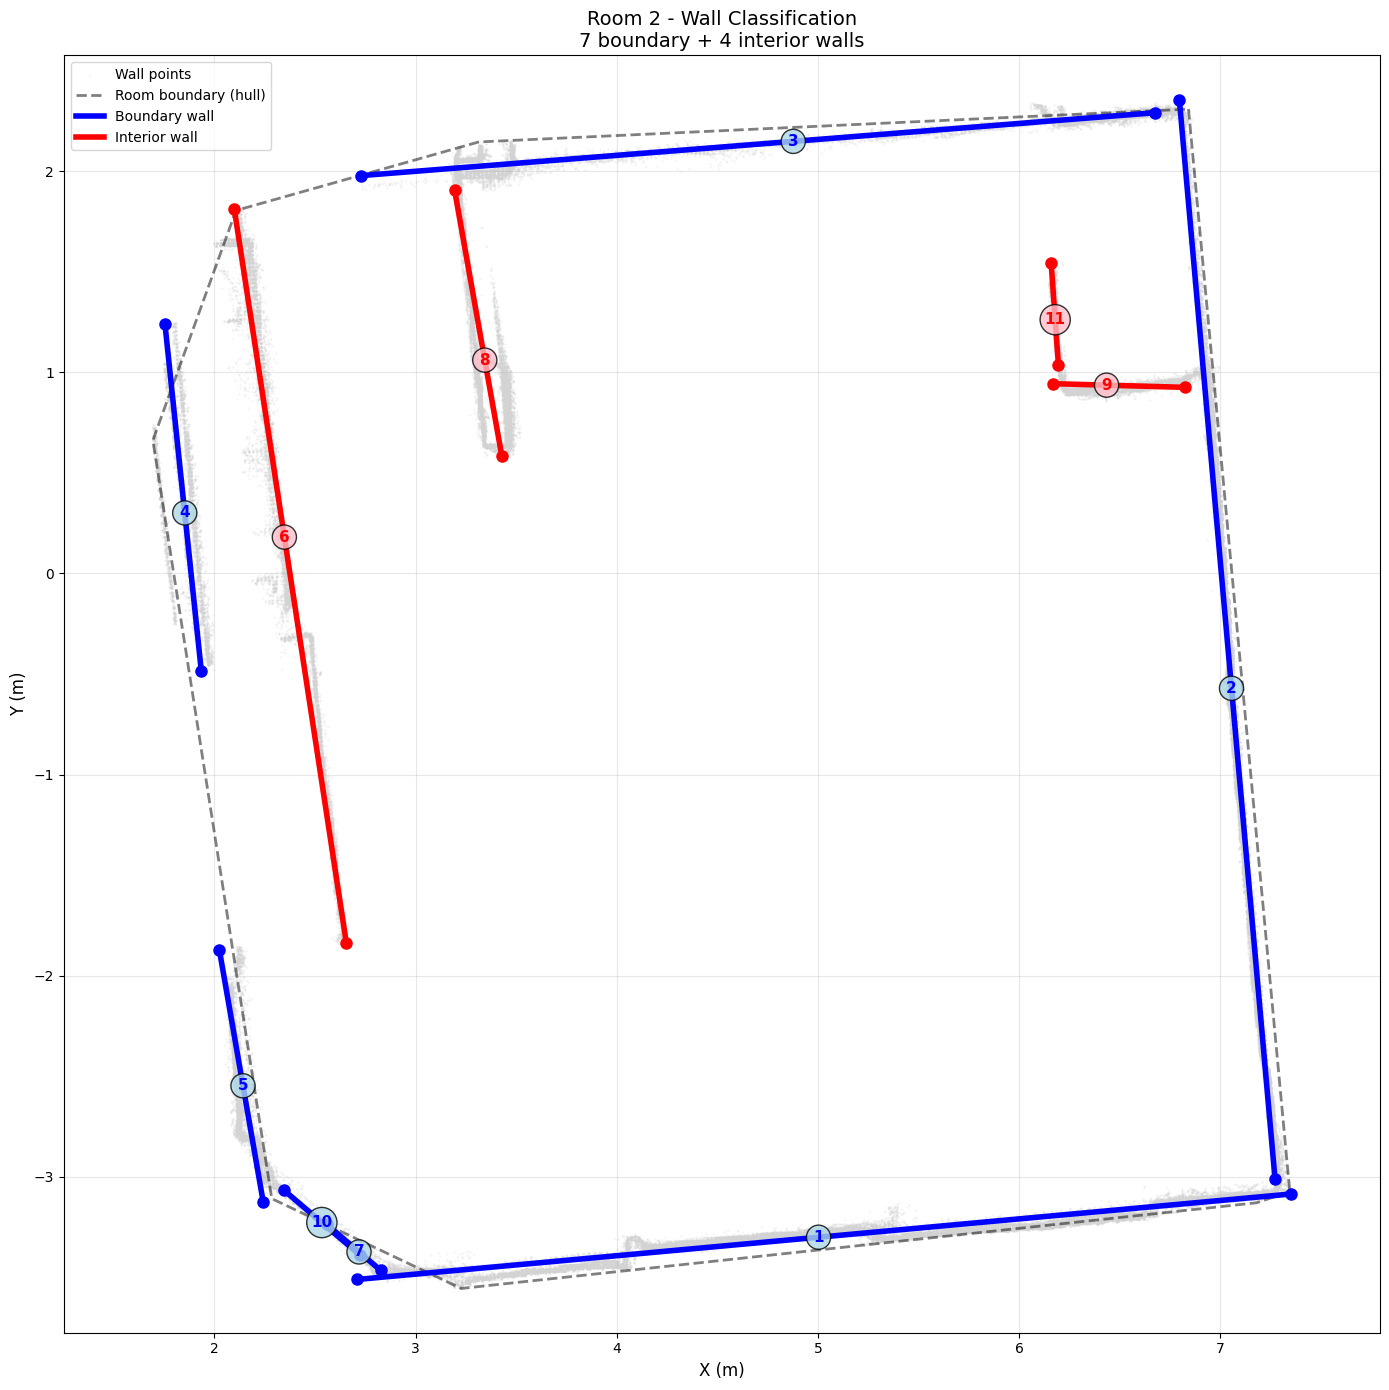

In [289]:
visualize_wall_classification(wall_lines, classification, simplified,
                              room_id=2, points_2d=points_2d)

In [290]:
interior_walls = extract_interior_walls(wall_lines, classification)


Extracted 4 interior walls:
  Wall 6: length=3.69m, points=13386
  Wall 8: length=1.34m, points=11911
  Wall 9: length=0.66m, points=4834
  Wall 11: length=0.51m, points=2918


In [291]:
floorplan = create_hybrid_floorplan(simplified, interior_walls, room_id=2)


CREATING HYBRID FLOORPLAN

Room Boundary:
  Method: Concave hull + simplification
  Vertices: 8
  Area: 28.14 m²
  Perimeter: 20.42 m

Interior Elements:
  Count: 4
  Wall 1:
    Length: 3.69m
    Start: (2.10, 1.81)
    End: (2.66, -1.84)
  Wall 2:
    Length: 1.34m
    Start: (3.19, 1.91)
    End: (3.43, 0.58)
  Wall 3:
    Length: 0.66m
    Start: (6.17, 0.94)
    End: (6.82, 0.92)
  Wall 4:
    Length: 0.51m
    Start: (6.16, 1.54)
    End: (6.20, 1.04)


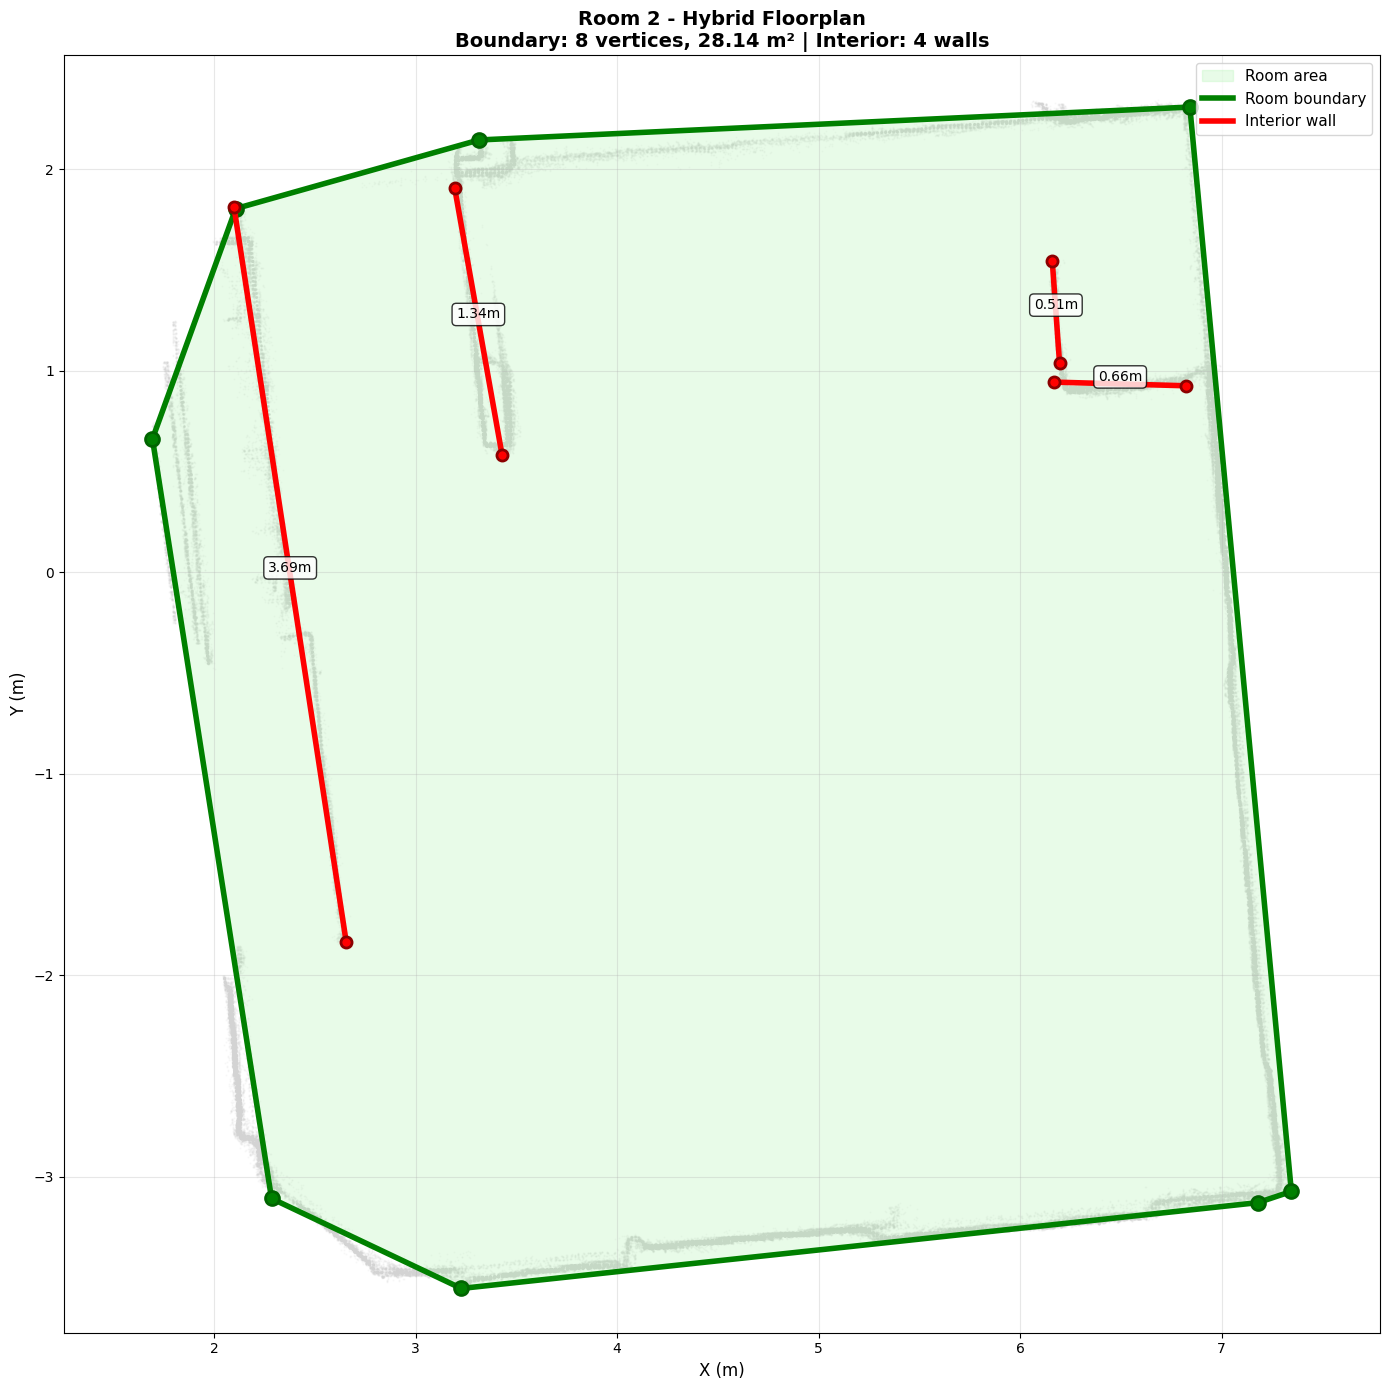

In [292]:
visualize_hybrid_floorplan(floorplan, points_2d=points_2d)

In [311]:
def connect_interior_to_boundary(interior_walls, boundary_polygon, max_extension=1):
    """Connect interior wall endpoints to nearest boundary edge"""
    boundary_line = LineString(boundary_polygon.exterior.coords)
    connected = []
    
    for i, wall in enumerate(interior_walls):
        start, end = wall['start'], wall['end']
        
        nearest_start = nearest_points(Point(start), boundary_line)[1]
        nearest_end = nearest_points(Point(end), boundary_line)[1]
        
        b_start = np.array([nearest_start.x, nearest_start.y])
        b_end = np.array([nearest_end.x, nearest_end.y])
        
        ext_start = np.linalg.norm(b_start - start)
        ext_end = np.linalg.norm(b_end - end)
        
        connected.append({
            'original_start': start, 'original_end': end,
            'boundary_start': b_start if ext_start <= max_extension else start,
            'boundary_end': b_end if ext_end <= max_extension else end,
            'connected_start': ext_start <= max_extension,
            'connected_end': ext_end <= max_extension
        })
    
    return connected

In [316]:
def connect_interior_to_boundary_smart(interior_walls, boundary_polygon, max_extension=2.0):
    """Connect only the nearest endpoint of each interior wall"""
    boundary_line = LineString(boundary_polygon.exterior.coords)
    connected = []
    
    for wall in interior_walls:
        start, end = wall['start'], wall['end']
        
        # Find distances
        nearest_start = nearest_points(Point(start), boundary_line)[1]
        nearest_end = nearest_points(Point(end), boundary_line)[1]
        
        b_start = np.array([nearest_start.x, nearest_start.y])
        b_end = np.array([nearest_end.x, nearest_end.y])
        
        ext_start = np.linalg.norm(b_start - start)
        ext_end = np.linalg.norm(b_end - end)
        
        # Connect only the closer endpoint
        if ext_start < ext_end and ext_start <= max_extension:
            connected.append({
                'original_start': start, 'original_end': end,
                'boundary_start': b_start, 'boundary_end': end,
                'connected_start': True, 'connected_end': False
            })
        elif ext_end <= max_extension:
            connected.append({
                'original_start': start, 'original_end': end,
                'boundary_start': start, 'boundary_end': b_end,
                'connected_start': False, 'connected_end': True
            })
    
    return connected

In [317]:
def measure_boundary_segments(boundary_polygon, connected_walls):
    """Measure distances along boundary between corners and connections"""
    boundary_line = LineString(boundary_polygon.exterior.coords)
    boundary_coords = np.array(boundary_polygon.exterior.coords[:-1])
    
    points = []
    # Add corners
    for corner in boundary_coords:
        pos = boundary_line.project(Point(corner), normalized=True)
        points.append({'pt': corner, 'pos': pos, 'type': 'corner'})
    
    # Add connection points
    for wall in connected_walls:
        if wall['connected_start']:
            pos = boundary_line.project(Point(wall['boundary_start']), normalized=True)
            points.append({'pt': wall['boundary_start'], 'pos': pos, 'type': 'connect'})
        if wall['connected_end']:
            pos = boundary_line.project(Point(wall['boundary_end']), normalized=True)
            points.append({'pt': wall['boundary_end'], 'pos': pos, 'type': 'connect'})
    
    points.sort(key=lambda x: x['pos'])
    
    dimensions = []
    for i in range(len(points)):
        p1, p2 = points[i], points[(i + 1) % len(points)]
        pos_diff = (p2['pos'] - p1['pos']) % 1.0
        length = pos_diff * boundary_line.length
        mid_pos = (p1['pos'] + pos_diff / 2) % 1.0
        mid_pt = boundary_line.interpolate(mid_pos, normalized=True)
        dimensions.append({
            'start': p1['pt'], 'end': p2['pt'], 'length': length,
            'mid': np.array([mid_pt.x, mid_pt.y])
        })
    
    return dimensions

In [345]:
def visualize_with_dimensions(floorplan, connected, dimensions, points_2d=None):
    """Visualize complete floorplan with connections and dimensions"""
    fig, ax = plt.subplots(figsize=(16, 16))
    
    if points_2d is not None:
        ax.scatter(points_2d[:, 0], points_2d[:, 1], s=0.3, c='gray', alpha=0.1)
    
    # Boundary
    verts = floorplan['boundary']['vertices']
    closed = np.vstack([verts, verts[0]])
    ax.fill(closed[:, 0], closed[:, 1], color='lightgreen', alpha=0.15)
    ax.plot(closed[:, 0], closed[:, 1], 'darkgreen', linewidth=3)
    ax.plot(verts[:, 0], verts[:, 1], 'o', color='darkgreen', markersize=8)
    
    # Interior walls with connections
    for wall in connected:
        ax.plot([wall['original_start'][0], wall['original_end'][0]], 
               [wall['original_start'][1], wall['original_end'][1]], 'r-', linewidth=4)
        if wall['connected_start']:
            ax.plot([wall['original_start'][0], wall['boundary_start'][0]], 
                   [wall['original_start'][1], wall['boundary_start'][1]], 'r--', linewidth=2)
            ax.plot(wall['boundary_start'][0], wall['boundary_start'][1], 'ro', markersize=10)
        if wall['connected_end']:
            ax.plot([wall['original_end'][0], wall['boundary_end'][0]], 
                   [wall['original_end'][1], wall['boundary_end'][1]], 'r--', linewidth=2)
            ax.plot(wall['boundary_end'][0], wall['boundary_end'][1], 'ro', markersize=10)
    
    # Dimensions
    poly = floorplan['boundary']['polygon']
    centroid = np.array([poly.centroid.x, poly.centroid.y])
    for dim in dimensions:
        mid = dim['mid']
        offset = (mid - centroid) / (np.linalg.norm(mid - centroid) + 1e-8)
        label_pos = mid + offset * 0.35
        ax.text(label_pos[0], label_pos[1], f'{dim["length"]:.2f}m',
               fontsize=10, fontweight='bold', color='blue', ha='center', va='center',
               bbox=dict(boxstyle='round', facecolor='white', edgecolor='blue', alpha=0.9))
    
    # ax.set_title(f'Room {floorplan.get("room_id", "")} - Complete Floorplan with Dimensions', 
    #             fontsize=15, fontweight='bold')
    ax.axis('equal')
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

In [348]:
connected = connect_interior_to_boundary_smart(floorplan['interior_walls'], floorplan['boundary']['polygon'])

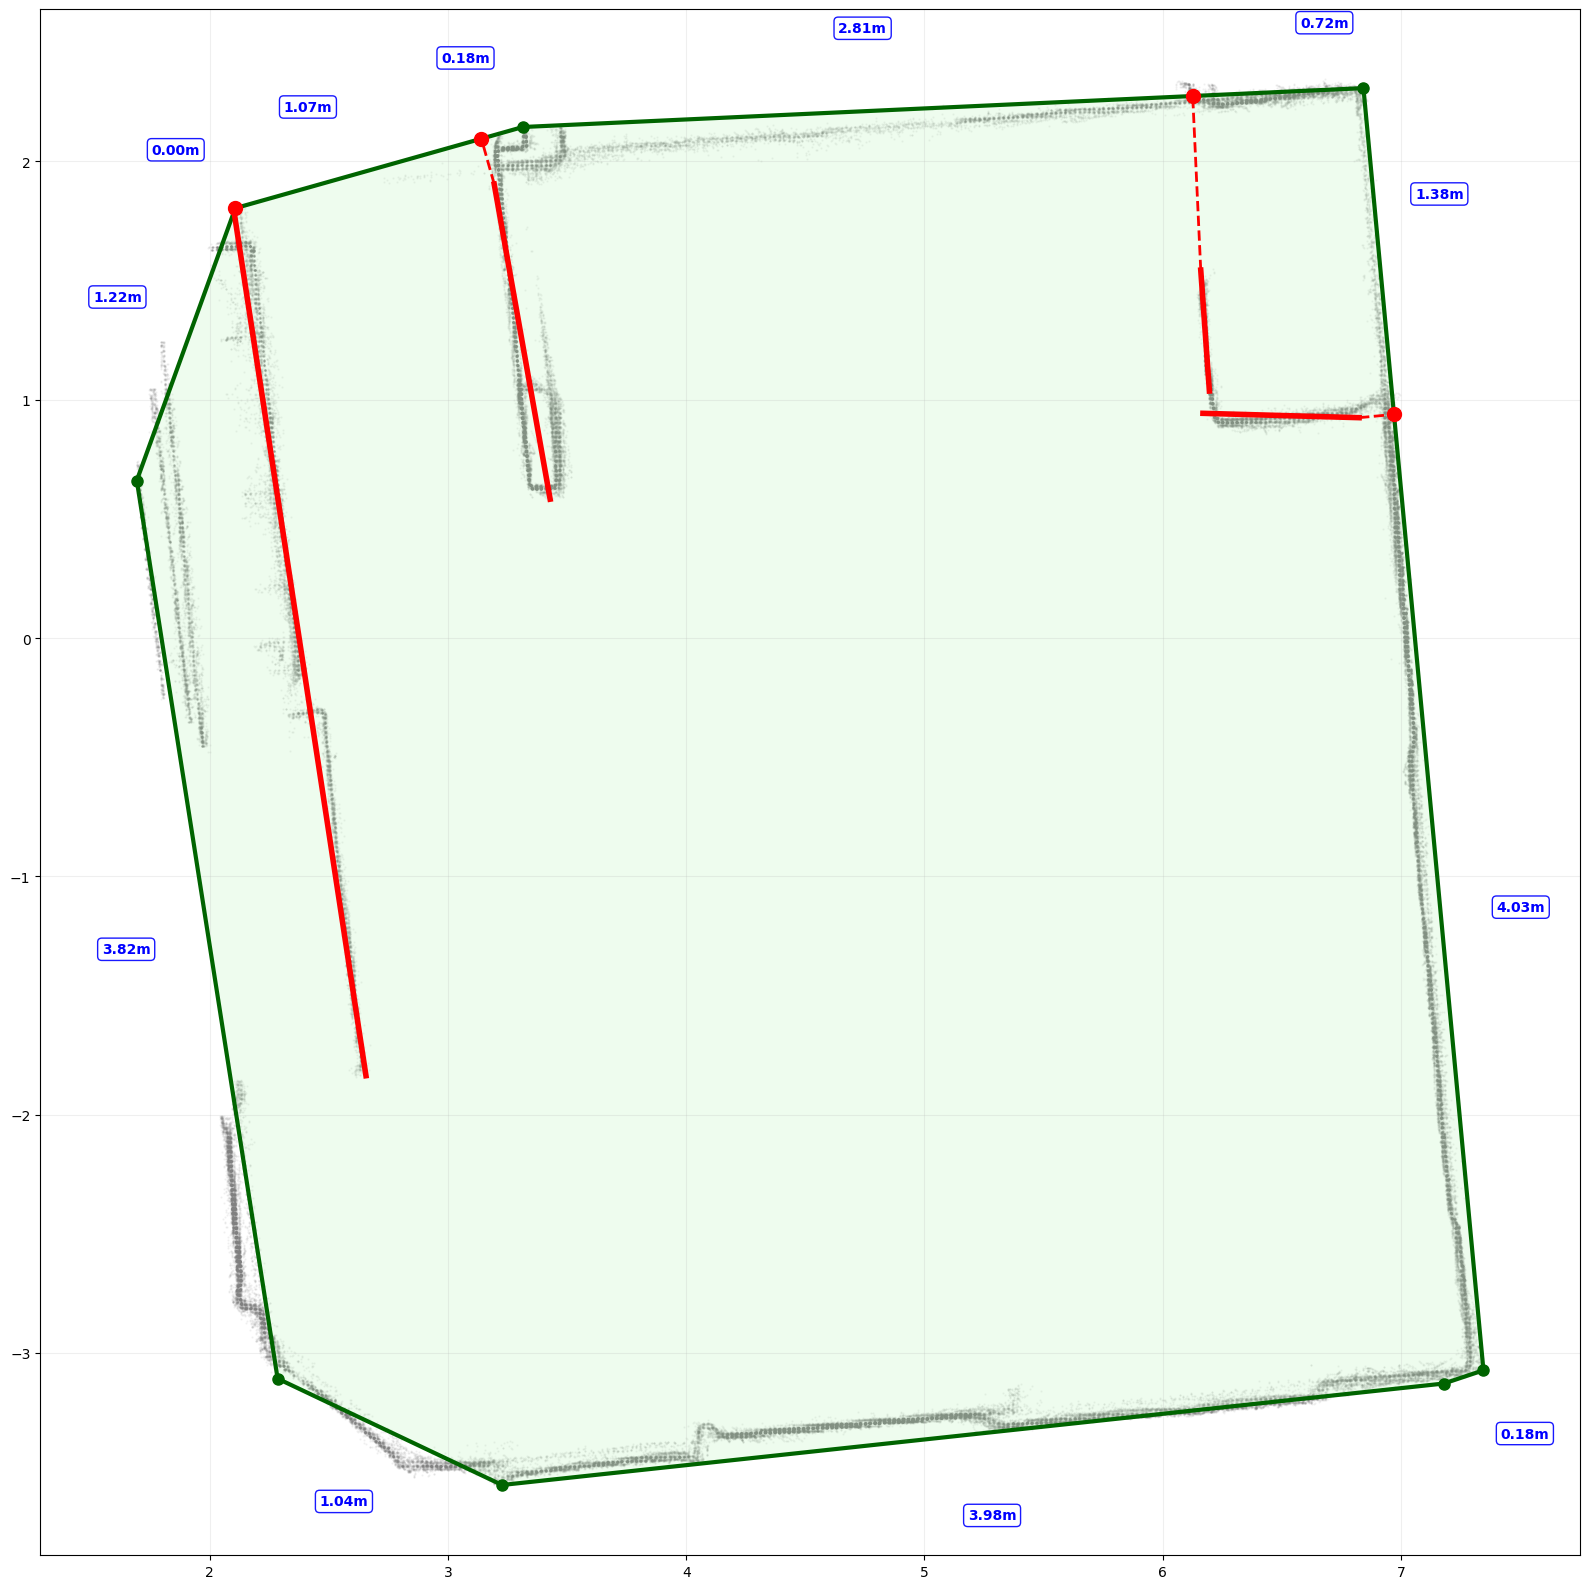

In [349]:
dimensions = measure_boundary_segments(floorplan['boundary']['polygon'], connected)
visualize_with_dimensions(floorplan, connected, dimensions, points_2d)

In [325]:
def measure_boundary_segments_merged(boundary_polygon, connected_walls, merge_threshold=0.2):
    """Measure with merged close connections"""
    boundary_line = LineString(boundary_polygon.exterior.coords)
    boundary_coords = np.array(boundary_polygon.exterior.coords[:-1])
    
    points = []
    # Corners
    for corner in boundary_coords:
        pos = boundary_line.project(Point(corner), normalized=True)
        points.append({'pt': corner, 'pos': pos, 'type': 'corner'})
    
    # Collect all connections
    connections = []
    for wall in connected_walls:
        if wall['connected_start']:
            pos = boundary_line.project(Point(wall['boundary_start']), normalized=True)
            connections.append({'pt': wall['boundary_start'], 'pos': pos, 'type': 'connect'})
        if wall['connected_end']:
            pos = boundary_line.project(Point(wall['boundary_end']), normalized=True)
            connections.append({'pt': wall['boundary_end'], 'pos': pos, 'type': 'connect'})
    
    # Merge close connections
    merged_connections = []
    used = set()
    
    for i, c1 in enumerate(connections):
        if i in used:
            continue
        cluster = [c1]
        used.add(i)
        
        for j, c2 in enumerate(connections):
            if j in used or i == j:
                continue
            dist = np.linalg.norm(c1['pt'] - c2['pt'])
            if dist < merge_threshold:
                cluster.append(c2)
                used.add(j)
        
        # Average
        avg_pt = np.mean([c['pt'] for c in cluster], axis=0)
        avg_pos = np.mean([c['pos'] for c in cluster])
        merged_connections.append({'pt': avg_pt, 'pos': avg_pos, 'type': 'connect'})
    
    points.extend(merged_connections)
    points.sort(key=lambda x: x['pos'])
    
    # Calculate dimensions
    dimensions = []
    for i in range(len(points)):
        p1, p2 = points[i], points[(i + 1) % len(points)]
        pos_diff = (p2['pos'] - p1['pos']) % 1.0
        length = pos_diff * boundary_line.length
        mid_pos = (p1['pos'] + pos_diff / 2) % 1.0
        mid_pt = boundary_line.interpolate(mid_pos, normalized=True)
        dimensions.append({
            'start': p1['pt'], 'end': p2['pt'], 'length': length,
            'mid': np.array([mid_pt.x, mid_pt.y])
        })
    
    return dimensions

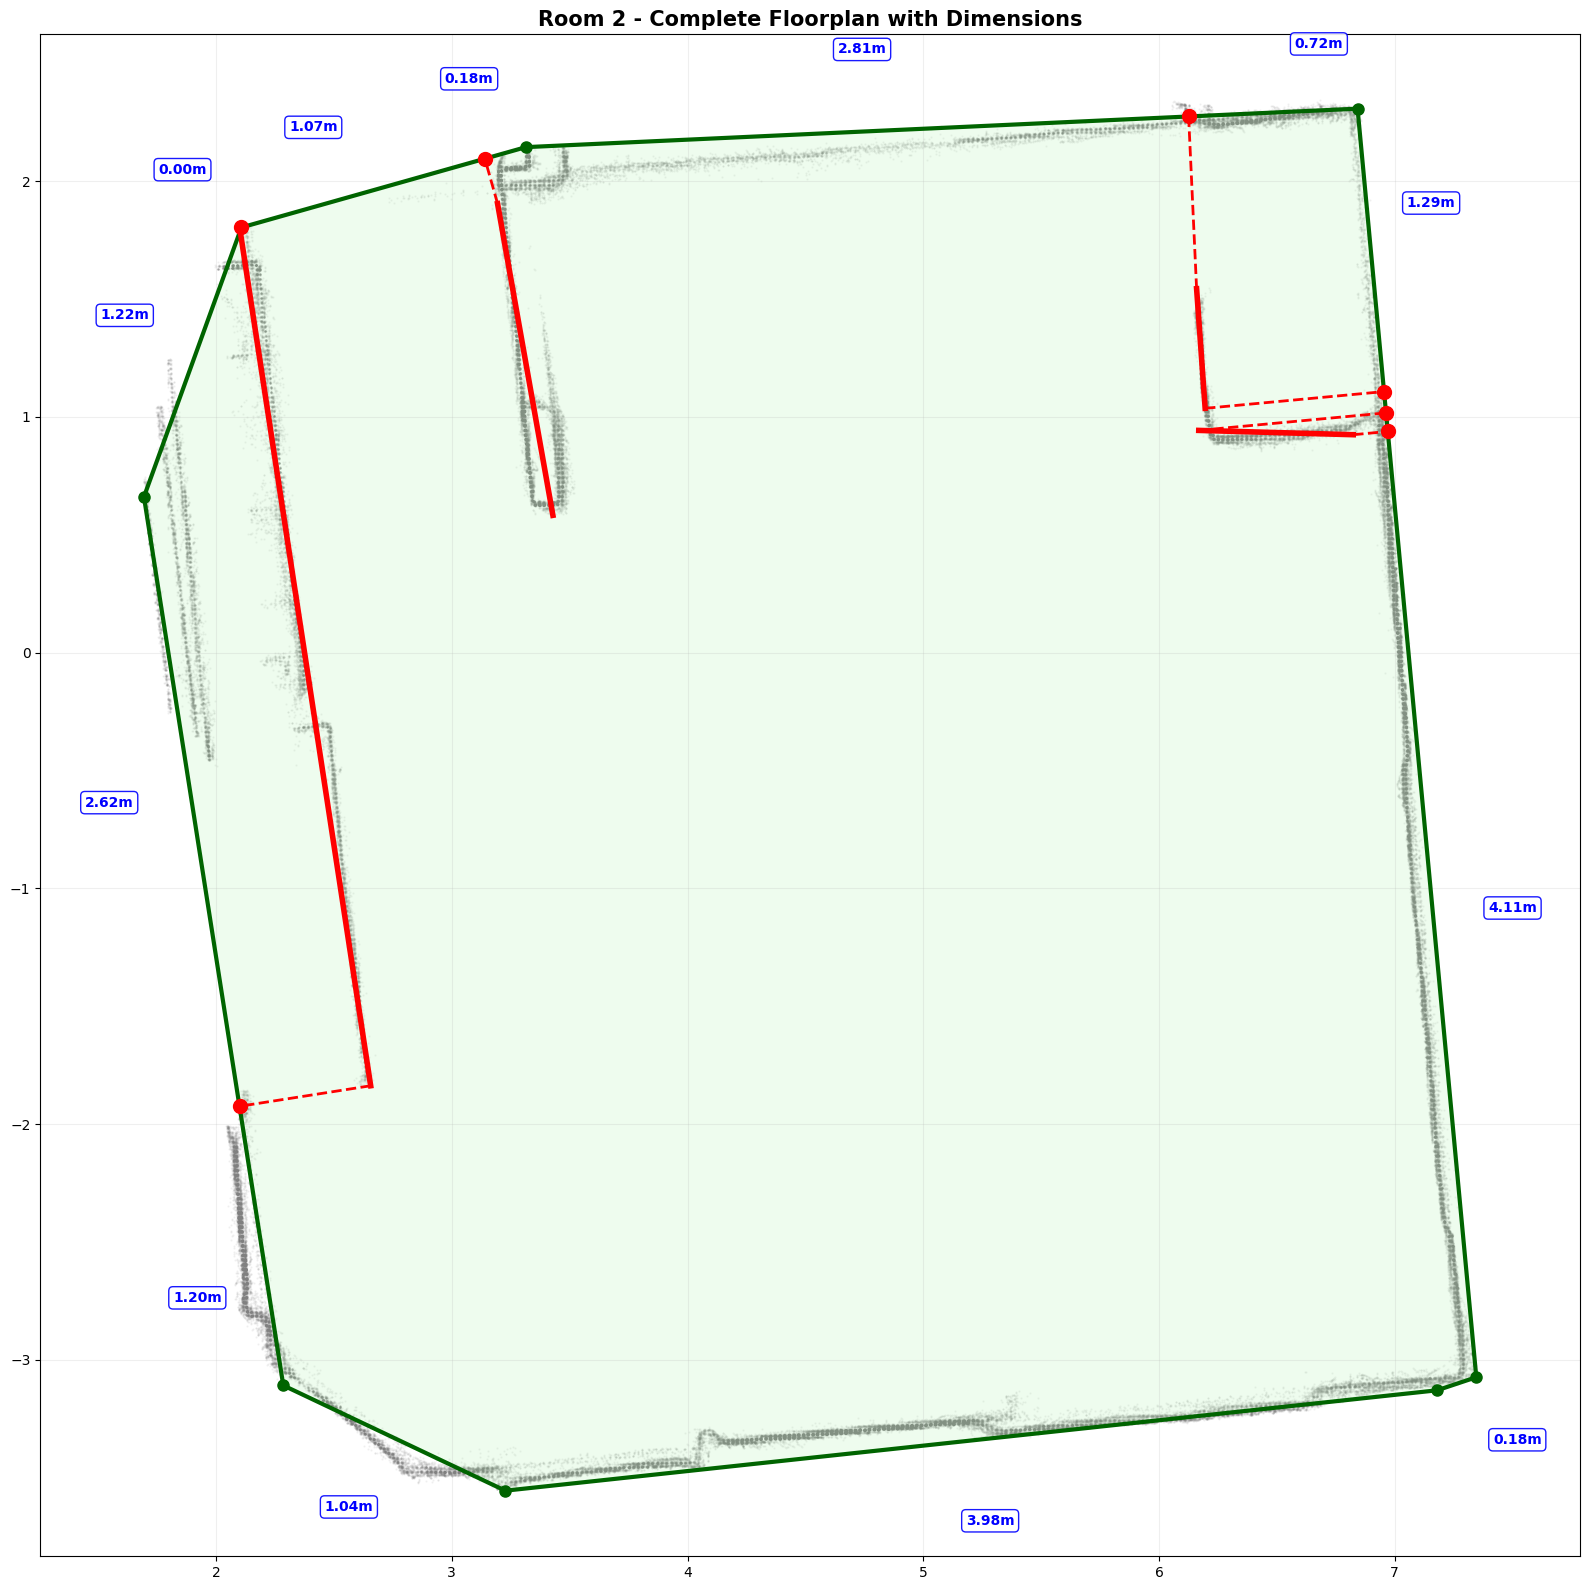

In [326]:
dimensions = measure_boundary_segments_merged(floorplan['boundary']['polygon'], connected, merge_threshold=0.2)
visualize_with_dimensions(floorplan, connected, dimensions, points_2d)

##### Hough transform

In [225]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from scipy.ndimage import gaussian_filter

In [222]:
def points_to_binary_image(points_2d, resolution=0.02):
    """
    Convert 2D point cloud to binary image for Hough Transform
    
    Args:
        points_2d: Nx2 array of 2D points
        resolution: Grid resolution in meters (pixel size)
    
    Returns:
        image: 2D binary array
        origin: (min_x, min_y) for coordinate conversion
        resolution: pixel size in meters
    """
    if len(points_2d) == 0:
        return None, None, resolution
    
    # Get bounds
    min_x, min_y = points_2d.min(axis=0)
    max_x, max_y = points_2d.max(axis=0)
    
    # Add margin
    margin = 0.1  # 10cm
    min_x -= margin
    min_y -= margin
    max_x += margin
    max_y += margin
    
    # Calculate image size
    width = int((max_x - min_x) / resolution) + 1
    height = int((max_y - min_y) / resolution) + 1
    
    # Create binary image
    image = np.zeros((height, width), dtype=np.uint8)
    
    # Convert points to pixel coordinates
    pixel_x = ((points_2d[:, 0] - min_x) / resolution).astype(int)
    pixel_y = ((points_2d[:, 1] - min_y) / resolution).astype(int)
    
    # Clip to image bounds
    pixel_x = np.clip(pixel_x, 0, width - 1)
    pixel_y = np.clip(pixel_y, 0, height - 1)
    
    # Set pixels
    image[pixel_y, pixel_x] = 255
    
    origin = (min_x, min_y)
    
    return image, origin, resolution

In [223]:
def extract_wall_line_hough(wall_segment, resolution=0.02, 
                            use_canny=False, sigma=1.0):
    """
    Extract 2D line from wall segment using Hough Transform
    
    Args:
        wall_segment: Dict with 'inliers' (Nx3 points) and 'plane_model'
        resolution: Grid resolution for rasterization (m)
        use_canny: If True, apply Canny edge detection first
        sigma: Gaussian blur sigma (for edge detection)
    
    Returns:
        line_info: Dict with start, end, direction, etc.
    """
    points_3d = wall_segment['inliers']
    plane_model = wall_segment['plane_model']
    
    # Project to 2D
    points_2d = points_3d[:, :2]
    
    # Convert to binary image
    image, origin, res = points_to_binary_image(points_2d, resolution)
    
    if image is None:
        print("Failed to create image")
        return None
    
    # Optional: Apply edge detection
    if use_canny:
        # Blur first
        image_float = gaussian_filter(image.astype(float), sigma=sigma)
        # Edge detection
        edges = canny(image_float, sigma=0, low_threshold=10, high_threshold=50)
        image_for_hough = (edges * 255).astype(np.uint8)
    else:
        image_for_hough = image
    
    # Apply Hough Transform
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(image_for_hough, theta=tested_angles)
    
    # Find peaks (strongest lines)
    # We expect 1 main line for this wall
    hough_peaks = hough_line_peaks(h, theta, d, num_peaks=1, threshold=0.3*h.max())
    
    if len(hough_peaks[0]) == 0:
        print("No line detected by Hough Transform")
        return None
    
    # Get strongest line parameters
    accum, angle, dist = hough_peaks[0][0], hough_peaks[1][0], hough_peaks[2][0]
    
    # Convert Hough parameters to line equation
    # Line: x*cos(angle) + y*sin(angle) = dist
    # Normal: (cos(angle), sin(angle))
    # Direction: (-sin(angle), cos(angle))
    
    line_normal = np.array([np.cos(angle), np.sin(angle)])
    line_direction = np.array([-np.sin(angle), np.cos(angle)])
    
    # Find line endpoints by projecting points
    # Point on line closest to origin (in pixel coords)
    point_on_line = dist * line_normal
    
    # Convert back to world coordinates
    point_on_line_world = point_on_line * res + np.array(origin)
    
    # Project all wall points onto line direction
    centroid = points_2d.mean(axis=0)
    centered = points_2d - point_on_line_world
    
    distances = np.dot(centered, line_direction)
    
    # Find extent
    min_dist = distances.min()
    max_dist = distances.max()
    
    # Endpoints
    start = point_on_line_world + min_dist * line_direction
    end = point_on_line_world + max_dist * line_direction
    
    length = np.linalg.norm(end - start)
    
    line_info = {
        'start': start,
        'end': end,
        'direction': line_direction,
        'length': length,
        'centroid': centroid,
        'plane_model': plane_model,
        'num_points': len(points_3d),
        'hough_angle': angle,
        'hough_distance': dist,
        'hough_score': accum,
        'method': 'hough'
    }
    
    return line_info

In [226]:
def visualize_hough_process(wall_segment, resolution=0.02, use_canny=False):
    """
    Visualize the Hough Transform process step by step
    
    Shows:
    1. Original points
    2. Rasterized image
    3. Hough space
    4. Detected line
    """
    points_3d = wall_segment['inliers']
    points_2d = points_3d[:, :2]
    
    # Create image
    image, origin, res = points_to_binary_image(points_2d, resolution)
    
    if image is None:
        print("Failed to create image")
        return
    
    # Optional edge detection
    if use_canny:
        image_float = gaussian_filter(image.astype(float), sigma=1.0)
        edges = canny(image_float, sigma=0, low_threshold=10, high_threshold=50)
        image_for_hough = (edges * 255).astype(np.uint8)
    else:
        image_for_hough = image
    
    # Hough Transform
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(image_for_hough, theta=tested_angles)
    
    # Find peak
    hough_peaks = hough_line_peaks(h, theta, d, num_peaks=1)
    
    # Extract line
    line_info = extract_wall_line_hough(wall_segment, resolution, use_canny)
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Original points
    ax = axes[0, 0]
    ax.scatter(points_2d[:, 0], points_2d[:, 1], s=1, c='blue', alpha=0.5)
    ax.set_title('Original Wall Points')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    
    # 2. Rasterized image
    ax = axes[0, 1]
    ax.imshow(image_for_hough, cmap='gray', origin='lower',
              extent=[origin[0], origin[0] + image.shape[1]*res,
                     origin[1], origin[1] + image.shape[0]*res])
    ax.set_title(f'Rasterized (res={resolution*100:.0f}cm)' + 
                 (' + Canny' if use_canny else ''))
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    
    # 3. Hough space
    ax = axes[1, 0]
    ax.imshow(np.log(1 + h), cmap='hot', aspect='auto',
              extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                     d[-1], d[0]])
    if len(hough_peaks[0]) > 0:
        ax.plot(np.rad2deg(hough_peaks[1]), hough_peaks[2], 'go', markersize=10)
    ax.set_title('Hough Space (log scale)')
    ax.set_xlabel('Angle (degrees)')
    ax.set_ylabel('Distance (pixels)')
    ax.set_xlim([-90, 90])
    
    # 4. Detected line
    ax = axes[1, 1]
    ax.scatter(points_2d[:, 0], points_2d[:, 1], s=1, c='lightblue', alpha=0.3)
    
    if line_info is not None:
        start = line_info['start']
        end = line_info['end']
        ax.plot([start[0], end[0]], [start[1], end[1]], 
               'r-', linewidth=3, label='Hough line')
        ax.plot([start[0], end[0]], [start[1], end[1]], 
               'ro', markersize=8)
        
        ax.set_title(f'Detected Line\nAngle: {np.rad2deg(line_info["hough_angle"]):.1f}°, '
                    f'Length: {line_info["length"]:.2f}m')
    else:
        ax.set_title('No Line Detected')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [231]:
def compare_methods(wall_segment):
    """
    Compare Hough vs Plane Normal vs PCA line extraction
    
    Args:
        wall_segment: Wall dict
    
    Returns:
        comparison: Dict with results from all methods
    """
    # from intersection_step1_extract_line import extract_wall_line_2d
    
    print("\n" + "="*60)
    print("COMPARING LINE EXTRACTION METHODS")
    print("="*60)
    
    # Method 1: Plane Normal (current)
    line_normal = extract_wall_line_2d(wall_segment, method='plane_normal')
    print(f"\nPlane Normal Method:")
    print(f"  Length: {line_normal['length']:.3f}m")
    print(f"  Angle: {np.rad2deg(np.arctan2(line_normal['direction'][1], line_normal['direction'][0])):.1f}°")
    
    # Method 2: PCA
    line_pca = extract_wall_line_2d(wall_segment, method='pca')
    print(f"\nPCA Method:")
    print(f"  Length: {line_pca['length']:.3f}m")
    print(f"  Angle: {np.rad2deg(np.arctan2(line_pca['direction'][1], line_pca['direction'][0])):.1f}°")
    
    # Method 3: Hough Transform
    line_hough = extract_wall_line_hough(wall_segment, resolution=0.02)
    if line_hough:
        print(f"\nHough Transform Method:")
        print(f"  Length: {line_hough['length']:.3f}m")
        print(f"  Angle: {np.rad2deg(line_hough['hough_angle']):.1f}°")
        print(f"  Score: {line_hough['hough_score']:.0f}")
    
    # Visualize all three
    points_2d = wall_segment['inliers'][:, :2]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(points_2d[:, 0], points_2d[:, 1], s=1, c='lightblue', alpha=0.3, label='Points')
    
    # Plot lines
    for method_name, line, color in [
        ('Plane Normal', line_normal, 'red'),
        ('PCA', line_pca, 'green'),
        ('Hough', line_hough, 'blue')
    ]:
        if line:
            ax.plot([line['start'][0], line['end'][0]], 
                   [line['start'][1], line['end'][1]],
                   color=color, linewidth=3, label=method_name, alpha=0.7)
            ax.plot([line['start'][0], line['end'][0]], 
                   [line['start'][1], line['end'][1]],
                   'o', color=color, markersize=6)
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Method Comparison')
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("="*60)
    
    return {
        'plane_normal': line_normal,
        'pca': line_pca,
        'hough': line_hough
    }


In [329]:
wall_lines_hough = []
for i, wall in enumerate(walls[2]):  # Room 2
    print(f"\nProcessing wall {i+1}...")
    line = extract_wall_line_hough(wall, resolution=0.02, use_canny=False)
    if line is not None:
        wall_lines_hough.append(line)
        print(f"  ✓ Length: {line['length']:.2f}m, Angle: {np.rad2deg(line['hough_angle']):.1f}°")
    else:
        print(f"  ✗ Failed to extract line")

print(f"\n✓ Extracted {len(wall_lines_hough)} wall lines with Hough Transform")


Processing wall 1...
  ✓ Length: 4.66m, Angle: -85.0°

Processing wall 2...
  ✓ Length: 5.39m, Angle: 5.0°

Processing wall 3...
  ✓ Length: 3.96m, Angle: -84.5°

Processing wall 4...
  ✓ Length: 1.73m, Angle: 6.0°

Processing wall 5...
  ✓ Length: 1.27m, Angle: 6.5°

Processing wall 6...
  ✓ Length: 3.69m, Angle: 8.5°

Processing wall 7...
  ✓ Length: 0.35m, Angle: 45.0°

Processing wall 8...
  ✓ Length: 1.34m, Angle: 6.0°

Processing wall 9...
  ✓ Length: 0.65m, Angle: -84.5°

Processing wall 10...
  ✓ Length: 0.51m, Angle: 45.0°

Processing wall 11...
  ✓ Length: 0.51m, Angle: -1.0°

✓ Extracted 11 wall lines with Hough Transform


In [330]:
classification_hough = classify_walls_boundary_vs_interior(
    wall_lines_hough, 
    simplified,
    distance_threshold=0.3,
    coverage_threshold=0.7
)


CLASSIFYING WALLS: BOUNDARY vs INTERIOR
Total walls: 11
Distance threshold: 0.3m
Coverage threshold: 70%
  Wall 1: BOUNDARY
    Length: 4.66m
    Avg dist to boundary: 0.066m
    Min dist to boundary: 0.022m
    Coverage: 100% near boundary
  Wall 2: BOUNDARY
    Length: 5.39m
    Avg dist to boundary: 0.062m
    Min dist to boundary: 0.049m
    Coverage: 100% near boundary
  Wall 3: BOUNDARY
    Length: 3.96m
    Avg dist to boundary: 0.081m
    Min dist to boundary: 0.000m
    Coverage: 100% near boundary
  Wall 4: BOUNDARY
    Length: 1.73m
    Avg dist to boundary: 0.103m
    Min dist to boundary: 0.028m
    Coverage: 100% near boundary
  Wall 5: BOUNDARY
    Length: 1.27m
    Avg dist to boundary: 0.024m
    Min dist to boundary: 0.003m
    Coverage: 100% near boundary
  Wall 6: INTERIOR
    Length: 3.69m
    Avg dist to boundary: 0.452m
    Min dist to boundary: 0.008m
    Coverage: 20% near boundary
  Wall 7: BOUNDARY
    Length: 0.35m
    Avg dist to boundary: 0.034m
    Min d

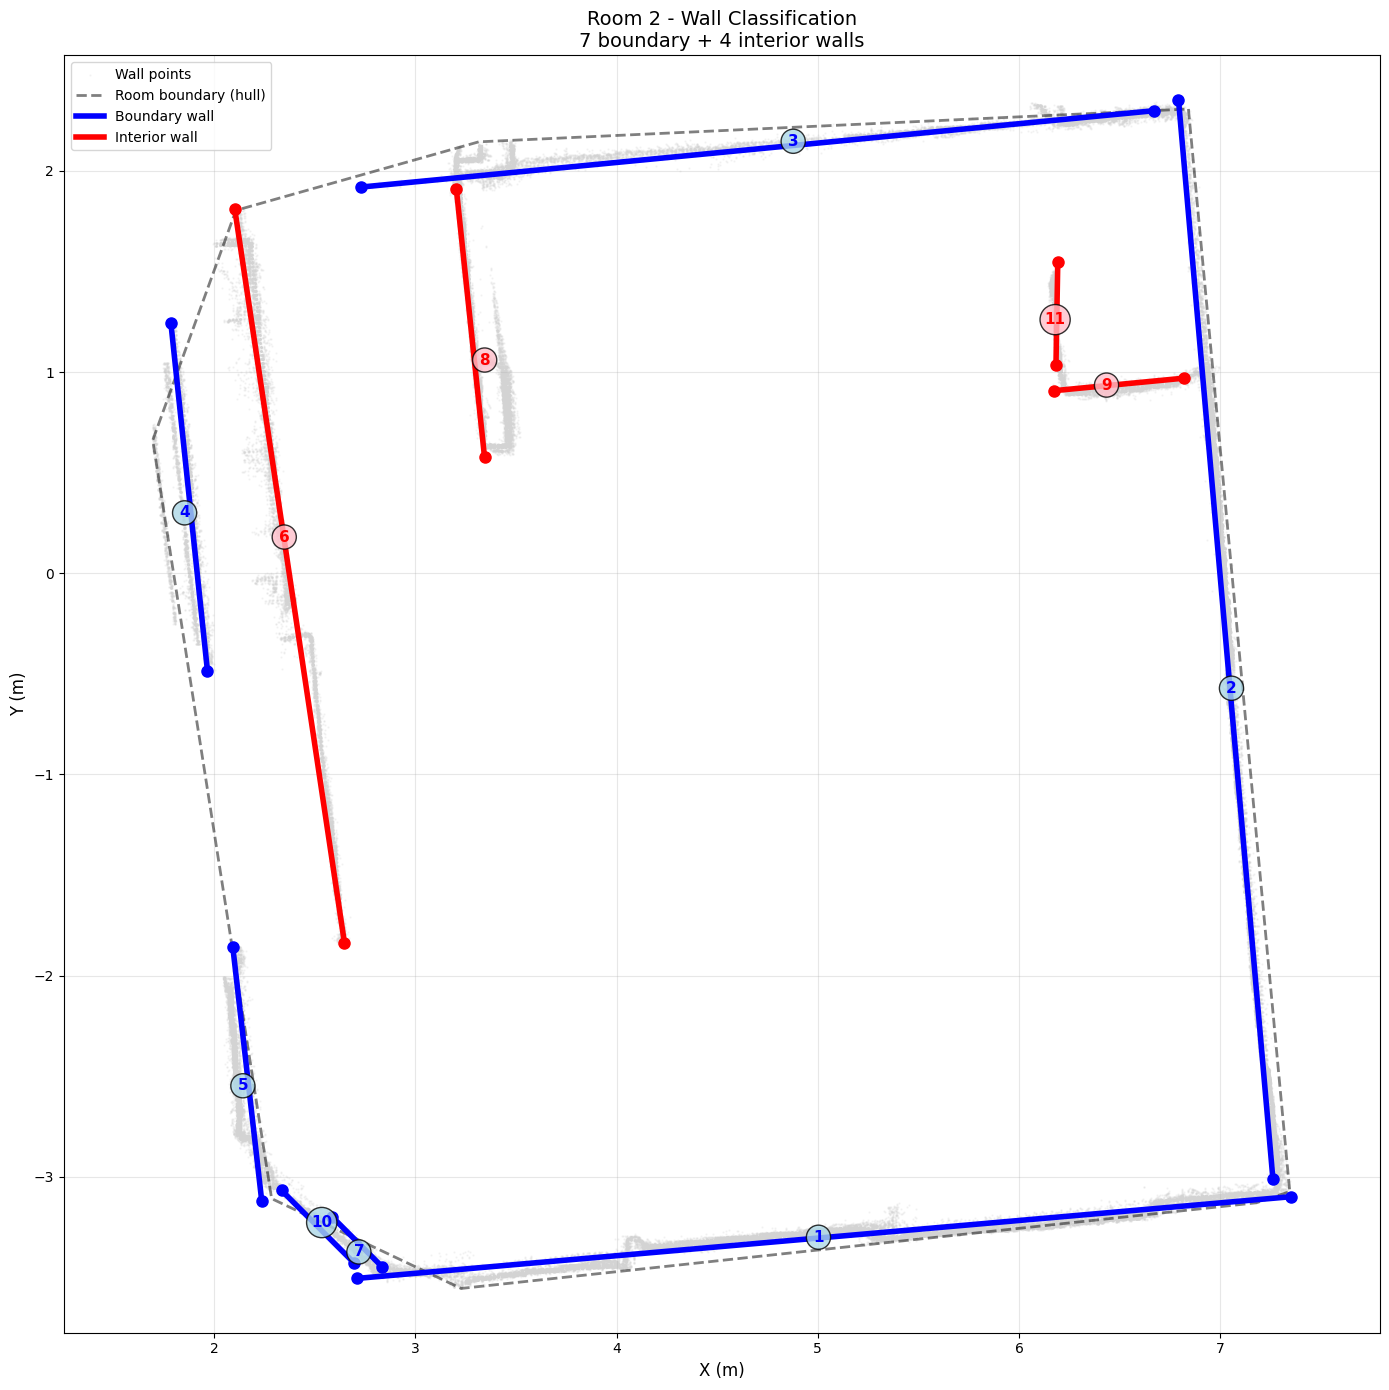

In [332]:
visualize_wall_classification(wall_lines_hough, classification_hough, 
                              simplified, room_id=2, points_2d=points_2d)

In [333]:
interior_walls_hough = extract_interior_walls(wall_lines_hough, classification_hough)


Extracted 4 interior walls:
  Wall 6: length=3.69m, points=13386
  Wall 8: length=1.34m, points=11911
  Wall 9: length=0.65m, points=4834
  Wall 11: length=0.51m, points=2918



CREATING HYBRID FLOORPLAN

Room Boundary:
  Method: Concave hull + simplification
  Vertices: 8
  Area: 28.14 m²
  Perimeter: 20.42 m

Interior Elements:
  Count: 4
  Wall 1:
    Length: 3.69m
    Start: (2.65, -1.84)
    End: (2.10, 1.81)
  Wall 2:
    Length: 1.34m
    Start: (3.34, 0.58)
    End: (3.20, 1.91)
  Wall 3:
    Length: 0.65m
    Start: (6.17, 0.91)
    End: (6.82, 0.97)
  Wall 4:
    Length: 0.51m
    Start: (6.18, 1.04)
    End: (6.19, 1.55)


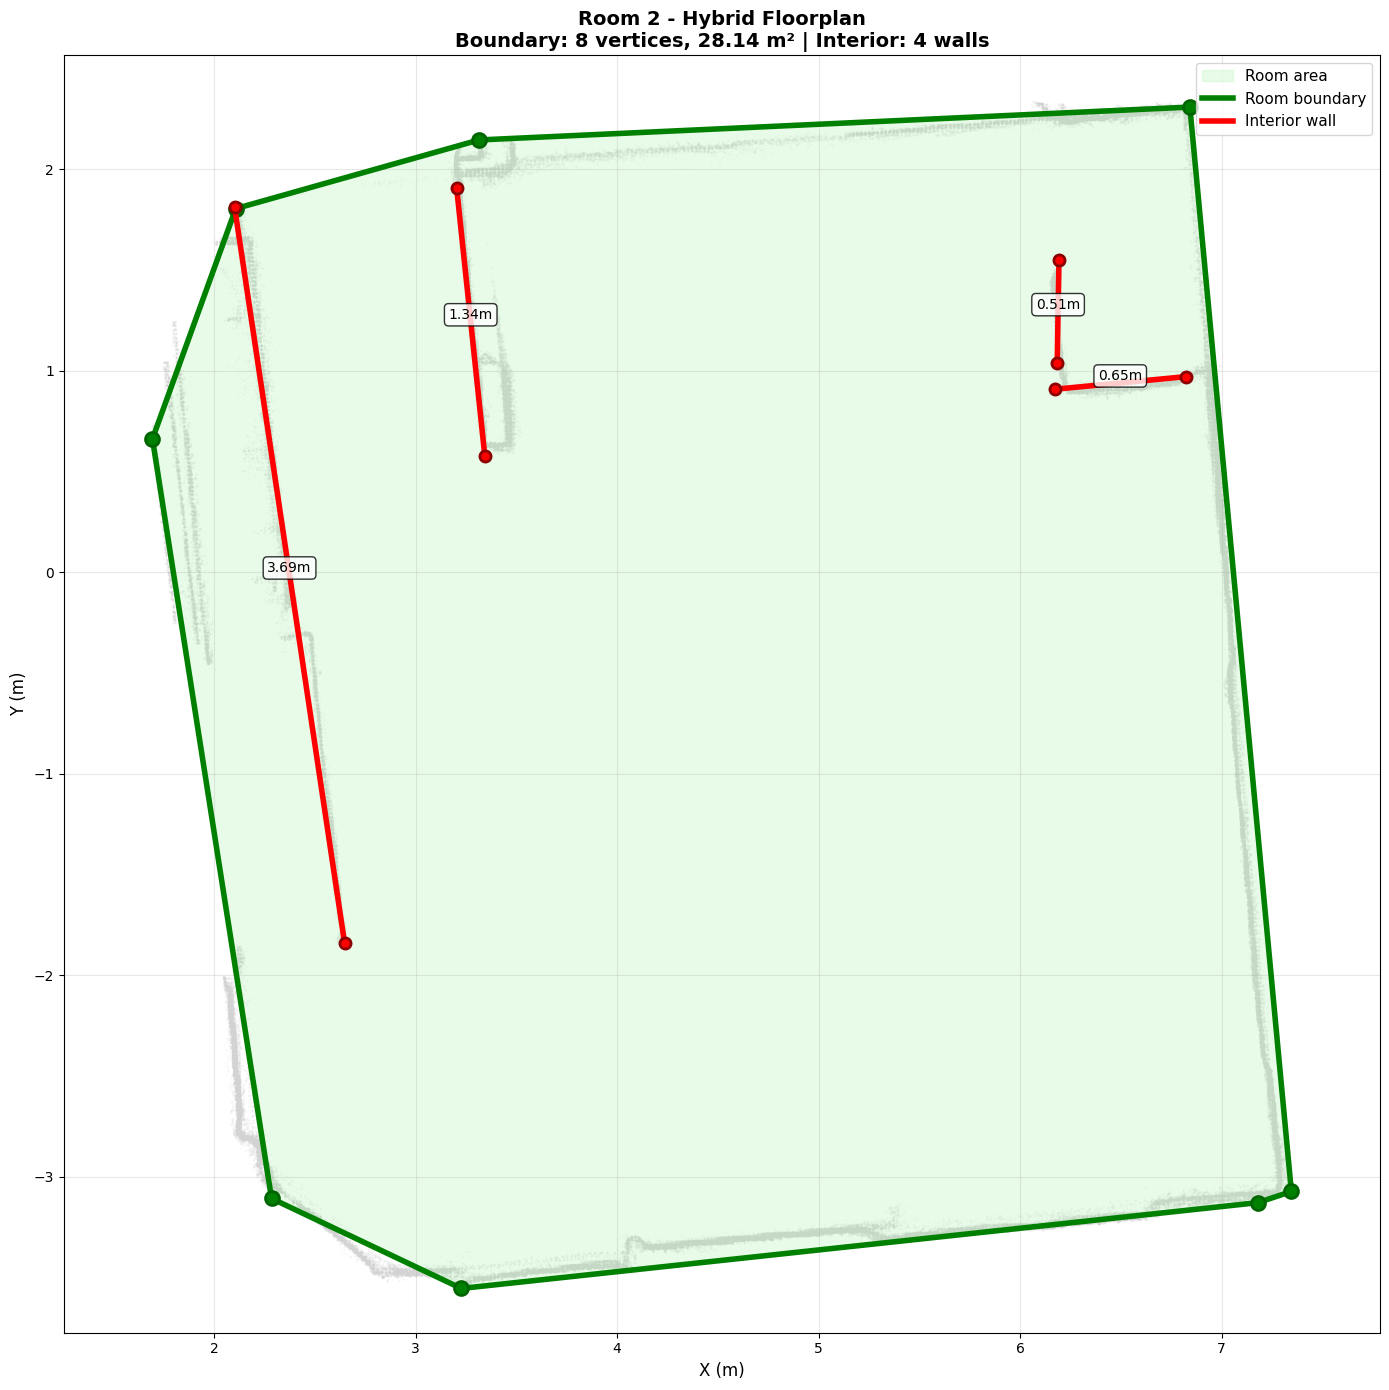

In [335]:
floorplan_hough = create_hybrid_floorplan(
    simplified, 
    interior_walls_hough, 
    room_id=2
)

# Visualize basic floorplan
visualize_hybrid_floorplan(floorplan_hough, points_2d=points_2d)

In [350]:
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import PatchCollection

In [351]:
def process_single_room(walls, room_id, alpha=0.5, epsilon=0.10, 
                        distance_threshold=0.3, coverage_threshold=0.7,
                        max_extension=2.0, merge_threshold=0.2,
                        method='pca'):
    """
    Process a single room through the complete hybrid pipeline
    
    Returns floorplan dict with boundary and interior walls
    """
    
    print(f"\n{'='*70}")
    print(f"PROCESSING ROOM {room_id}")
    print('='*70)
    
    # Get points
    room_points = get_room_wall_points(walls, room_id)
    if len(room_points) == 0:
        print(f"No points for room {room_id}")
        return None
    
    points_2d = project_points_to_2d(room_points)
    
    # Boundary (hull method)
    print(f"\n>>> Boundary (Hull Method)")
    hull = compute_concave_hull(points_2d, alpha=alpha)
    if hull is None:
        print(f"Failed to compute hull for room {room_id}")
        return None
    
    boundary_polygon = simplify_polygon(hull, epsilon=epsilon)
    if boundary_polygon is None:
        print(f"Failed to simplify hull for room {room_id}")
        return None
    
    print(f"✓ Boundary: {len(boundary_polygon.exterior.coords)-1} vertices, "
          f"Area: {boundary_polygon.area:.2f} m²")
    
    # Extract wall lines
    print(f"\n>>> Wall Lines ({method.upper()} method)")
    wall_lines = []
    for wall in walls[room_id]:
        line = extract_wall_line_2d(wall, method=method)
        if line is not None:
            wall_lines.append(line)
    
    print(f"✓ Extracted {len(wall_lines)} wall lines")
    
    if len(wall_lines) == 0:
        # No interior walls, just boundary
        return create_hybrid_floorplan(boundary_polygon, [], room_id)
    
    # Classify walls
    print(f"\n>>> Classification (Boundary vs Interior)")
    classification = classify_walls_boundary_vs_interior(
        wall_lines, boundary_polygon,
        distance_threshold=distance_threshold,
        coverage_threshold=coverage_threshold
    )
    
    interior_walls = extract_interior_walls(wall_lines, classification)
    
    # Create floorplan
    floorplan = create_hybrid_floorplan(boundary_polygon, interior_walls, room_id)
    
    if len(interior_walls) > 0:
        connected = connect_interior_to_boundary(interior_walls, boundary_polygon, max_extension)
        dimensions = measure_boundary_segments_merged(boundary_polygon, connected, merge_threshold)
        floorplan['connected_walls'] = connected
        floorplan['dimensions'] = dimensions
    else:
        floorplan['connected_walls'] = []
        floorplan['dimensions'] = []
    
    print(f"✓ Room {room_id} complete")
    
    return floorplan

In [352]:
def process_all_rooms(walls, alpha=0.5, epsilon=0.10, method='pca', **kwargs):
    """
    Process all rooms in the dataset
    
    Args:
        walls: Dict from detect_walls_per_room_all_clusters
        alpha: Hull concavity parameter
        epsilon: Simplification tolerance
        method: 'pca' or 'hough' for line extraction
        **kwargs: Additional parameters for processing
    
    Returns:
        building: Dict with floorplans for all rooms
    """
    print(f"\n{'#'*70}")
    print(f"PROCESSING ALL ROOMS")
    print(f"Method: {method.upper()} + Hull")
    print('#'*70)
    
    num_rooms = len(walls)
    floorplans = {}
    
    for room_id in range(1, num_rooms + 1):
        floorplan = process_single_room(walls, room_id, alpha, epsilon, method=method, **kwargs)
        if floorplan is not None:
            floorplans[room_id] = floorplan
    
    # Building summary
    print(f"\n{'='*70}")
    print("BUILDING SUMMARY")
    print('='*70)
    print(f"Total rooms processed: {len(floorplans)}")
    
    total_area = sum(fp['boundary']['area'] for fp in floorplans.values())
    total_interior_walls = sum(fp['num_interior_walls'] for fp in floorplans.values())
    
    print(f"Total building area: {total_area:.2f} m²")
    print(f"Total interior walls: {total_interior_walls}")
    
    for room_id, fp in floorplans.items():
        print(f"\n  Room {room_id}:")
        print(f"    Area: {fp['boundary']['area']:.2f} m²")
        print(f"    Perimeter: {fp['boundary']['perimeter']:.2f} m")
        print(f"    Vertices: {len(fp['boundary']['vertices'])}")
        print(f"    Interior walls: {fp['num_interior_walls']}")
    
    print('='*70)
    
    building = {
        'floorplans': floorplans,
        'num_rooms': len(floorplans),
        'total_area': total_area,
        'total_interior_walls': total_interior_walls,
        'method': method,
        'parameters': {
            'alpha': alpha,
            'epsilon': epsilon
        }
    }
    
    return building

In [353]:
def visualize_complete_building(building, figsize=(20, 20), 
                                show_interior_walls=True,
                                show_dimensions=False):
    """
    Visualize all rooms together in one complete floorplan
    
    Args:
        building: Dict from process_all_rooms
        figsize: Figure size
        show_interior_walls: Show interior structural elements
        show_dimensions: Show dimension labels
    """
    floorplans = building['floorplans']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Room colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(floorplans)))
    
    patches = []
    room_labels = []
    
    for i, (room_id, fp) in enumerate(floorplans.items()):
        color = colors[i]
        
        # Room boundary
        boundary_verts = fp['boundary']['vertices']
        
        # Create polygon patch
        poly = MPLPolygon(boundary_verts, closed=True, 
                         facecolor=color, edgecolor='black', 
                         linewidth=2.5, alpha=0.3)
        patches.append(poly)
        
        # Room label (at centroid)
        centroid_x = boundary_verts[:, 0].mean()
        centroid_y = boundary_verts[:, 1].mean()
        
        ax.text(centroid_x, centroid_y, 
               f'Room {room_id}\n{fp["boundary"]["area"]:.1f} m²',
               fontsize=14, fontweight='bold', ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                        edgecolor='black', linewidth=2, alpha=0.9))
        
        # Draw boundary with thicker line
        boundary_closed = np.vstack([boundary_verts, boundary_verts[0]])
        ax.plot(boundary_closed[:, 0], boundary_closed[:, 1],
               'k-', linewidth=3, zorder=10)
        
        # Corners
        ax.plot(boundary_verts[:, 0], boundary_verts[:, 1],
               'o', color='black', markersize=6, zorder=11)
        
        # Interior walls
        if show_interior_walls and fp['num_interior_walls'] > 0:
            for wall in fp['interior_walls']:
                start = wall['start']
                end = wall['end']
                ax.plot([start[0], end[0]], [start[1], end[1]],
                       'r-', linewidth=3, zorder=9)
                ax.plot([start[0], end[0]], [start[1], end[1]],
                       'ro', markersize=5, zorder=9)
        
        # Dimensions (optional)
        if show_dimensions and 'dimensions' in fp and len(fp['dimensions']) > 0:
            for dim in fp['dimensions']:
                mid = dim['mid']
                # Offset outward
                poly_shapely = fp['boundary']['polygon']
                centroid = np.array([poly_shapely.centroid.x, poly_shapely.centroid.y])
                offset_dir = (mid - centroid) / (np.linalg.norm(mid - centroid) + 1e-8)
                label_pos = mid + offset_dir * 0.25
                
                ax.text(label_pos[0], label_pos[1], f'{dim["length"]:.2f}',
                       fontsize=8, color='blue', ha='center', va='center',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                                edgecolor='blue', linewidth=1, alpha=0.8))
    
    # Add patches
    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    
    ax.set_xlabel('X (m)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Y (m)', fontsize=14, fontweight='bold')
    
    title = f'Complete Building Floorplan\n'
    title += f'{building["num_rooms"]} rooms | '
    title += f'Total area: {building["total_area"]:.2f} m² | '
    title += f'Method: {building["method"].upper()} + Hull'
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('equal')
    ax.grid(True, alpha=0.3, linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

In [356]:
building = process_all_rooms(
    walls,
    alpha=0.3,              # Hull concavity
    epsilon=0.15,           # Simplification
    method='pca',           # 'pca' or 'hough'
    distance_threshold=0.3, # Boundary classification
    coverage_threshold=0.7,
    max_extension=2.0,      # Interior wall connection
    merge_threshold=0.2     # Merge close connections
)


######################################################################
PROCESSING ALL ROOMS
Method: PCA + Hull
######################################################################

PROCESSING ROOM 1
  Wall segment 1: 25383 points
  Wall segment 2: 22089 points
  Wall segment 3: 7285 points
  Wall segment 4: 888 points
  Wall segment 5: 5226 points
  Wall segment 6: 3628 points
  Wall segment 7: 4271 points
  Wall segment 8: 1600 points
  Wall segment 9: 678 points
  Wall segment 10: 796 points

Total wall points for room 1: 71844
Projected 71844 points to 2D
2D bounds:
  X: [-1.656, 3.238] (range: 4.894m)
  Y: [5.195, 10.014] (range: 4.819m)

>>> Boundary (Hull Method)

Computing concave hull with alpha=0.3...
Input: 71844 points
✓ Hull computed successfully
  Vertices: 63
  Area: 15.52 m²
  Perimeter: 16.36 m

Simplifying polygon with epsilon=0.15m...
Original: 63 vertices, area=15.52 m², perimeter=16.36 m
Simplified: 7 vertices, area=15.06 m², perimeter=16.23 m
Reduction: 56 verti

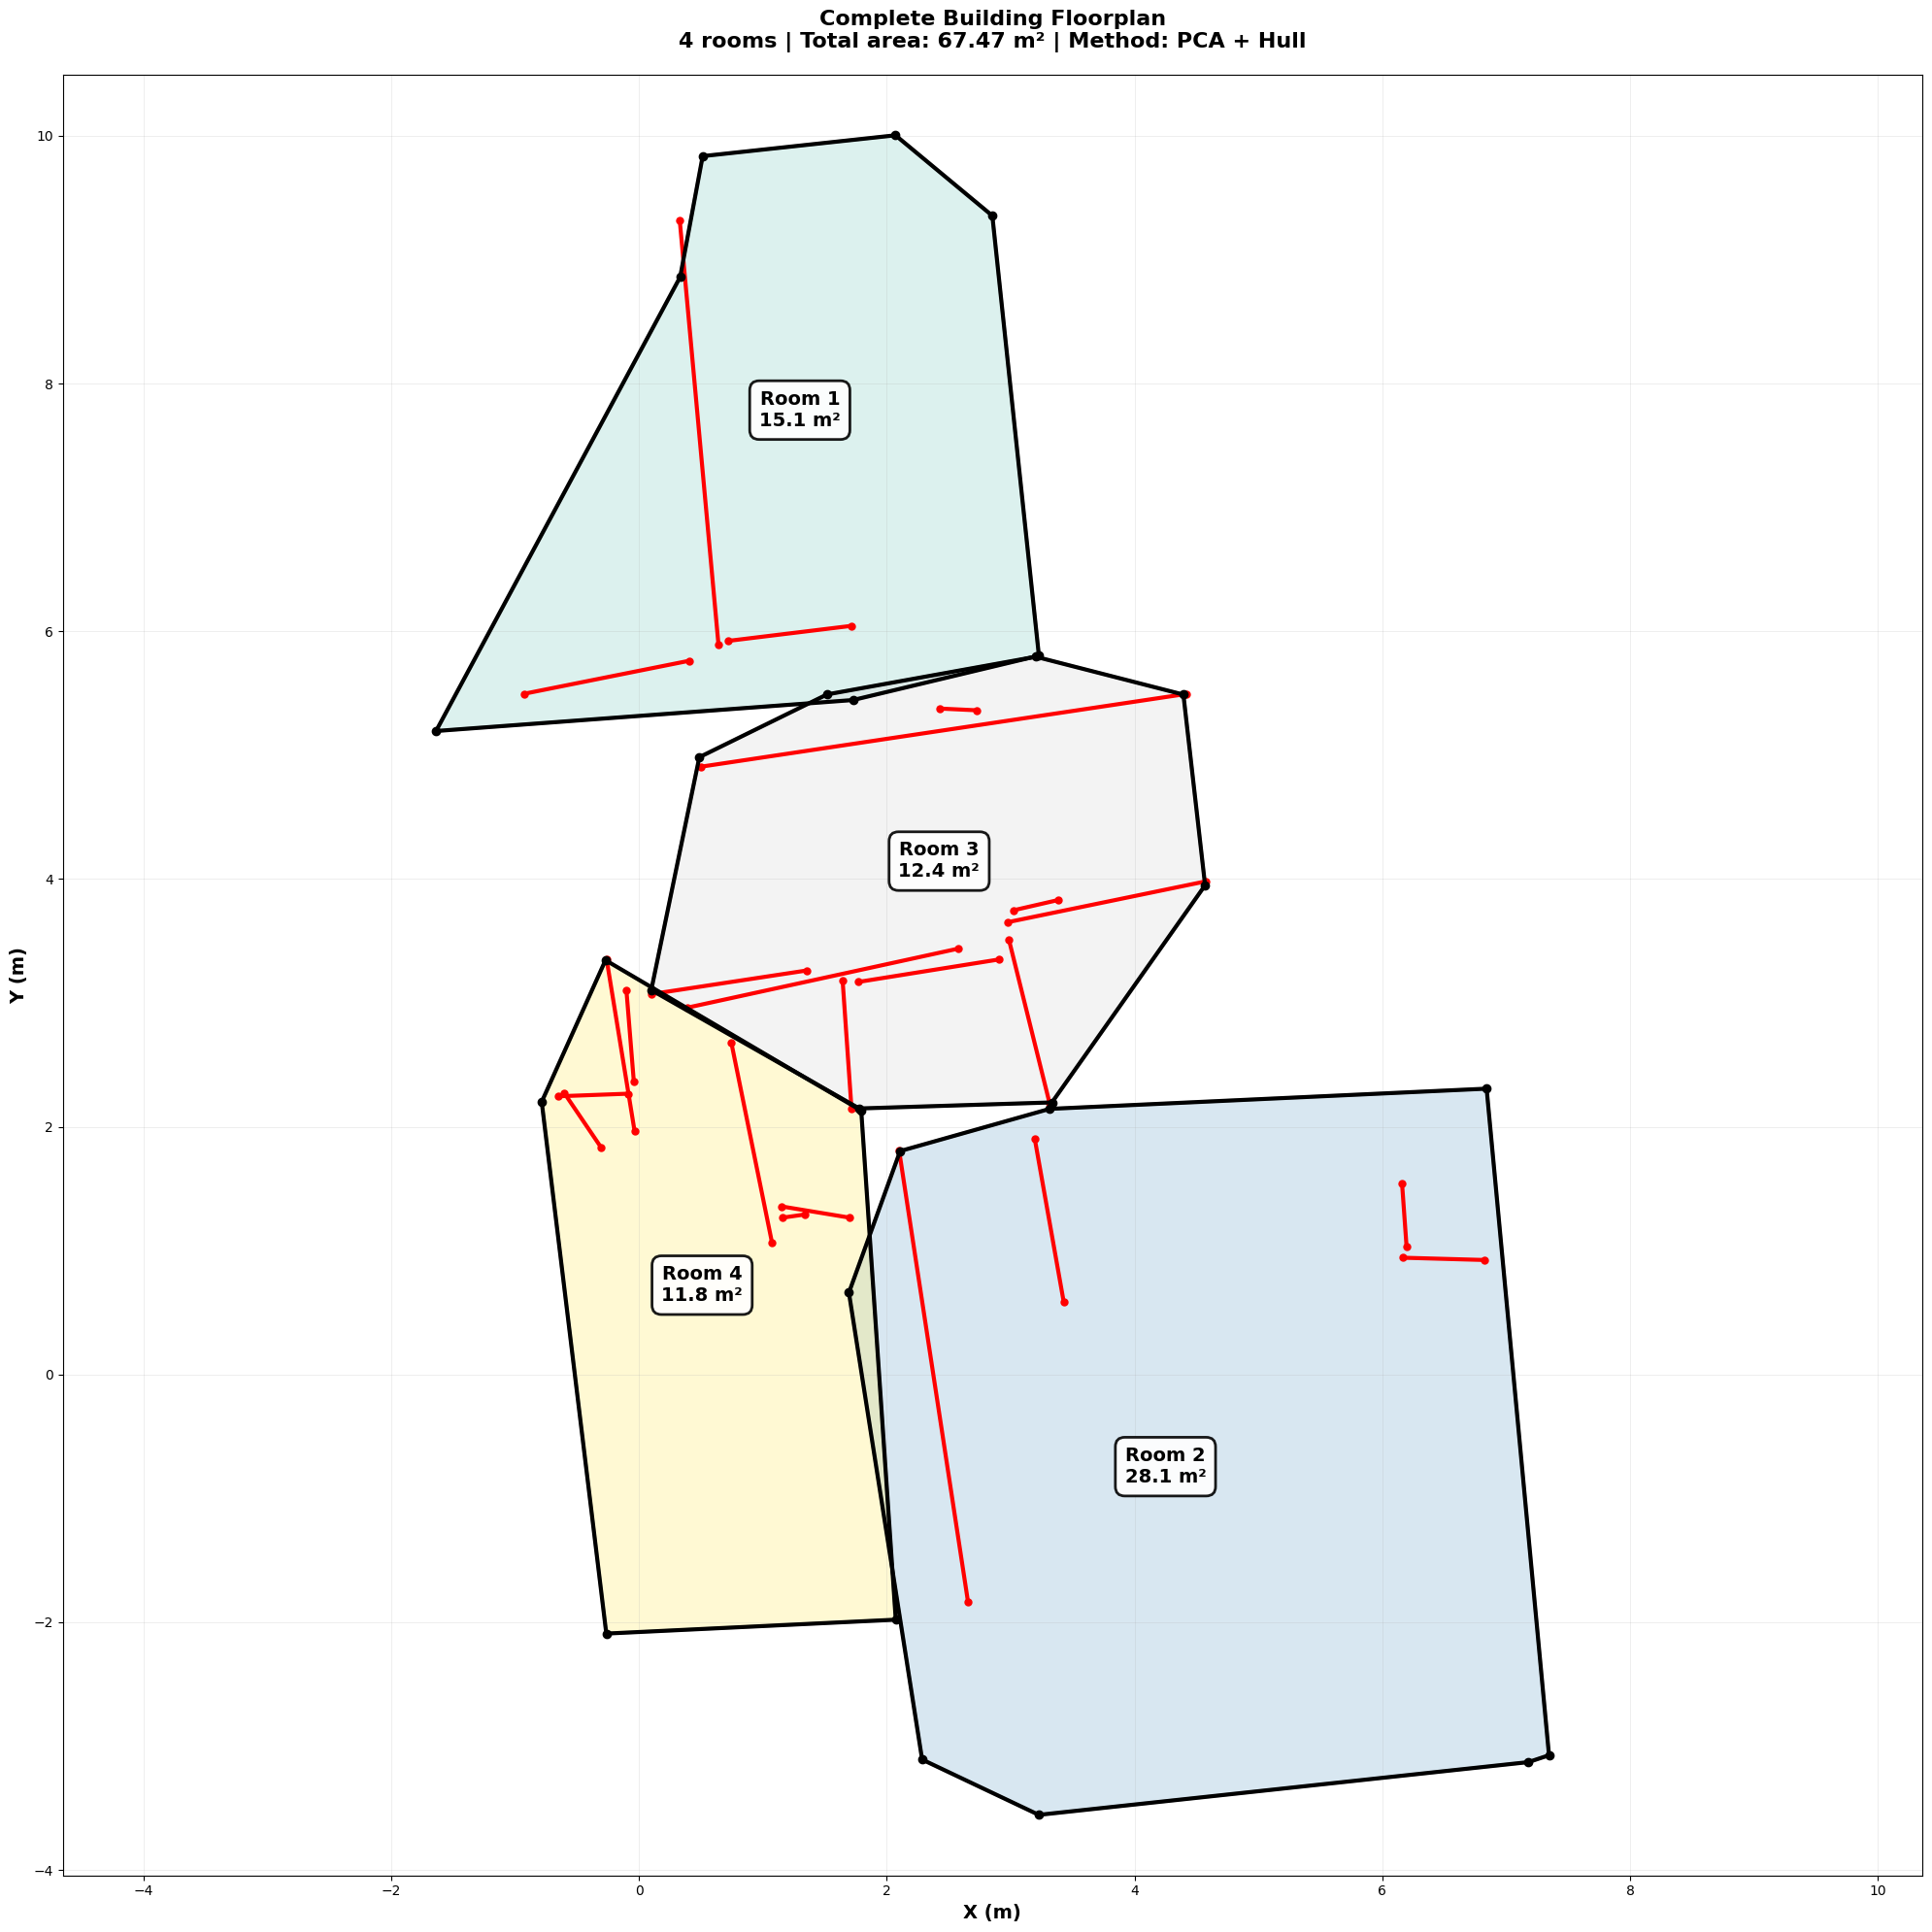

In [358]:
visualize_complete_building(
    building, 
    figsize=(20, 20),
    show_interior_walls=True,   # Show interior structural elements
    show_dimensions=False        # Set True to show all dimensions (might be cluttered)
)

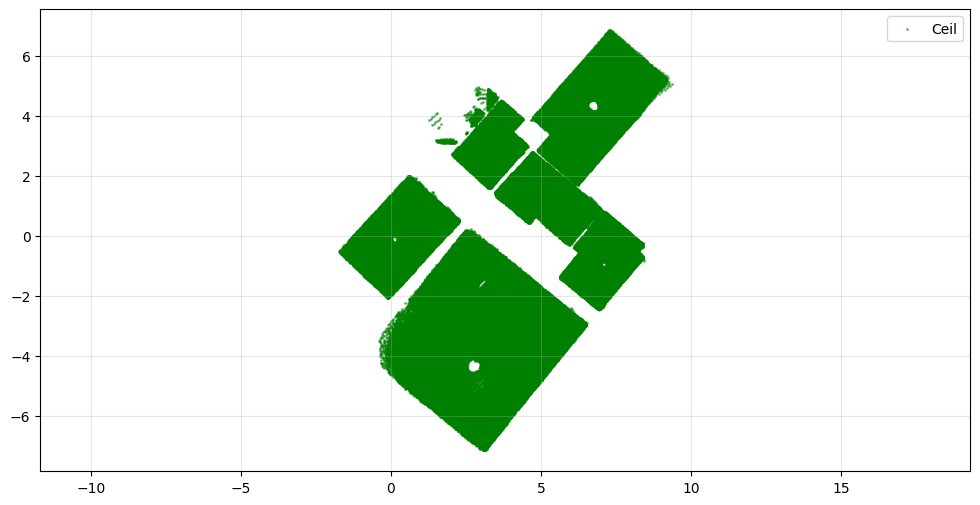

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(ceiling_points_2d[:, 0], ceiling_points_2d[:, 1], c='green', s=1, label='Ceil', alpha=0.5)

plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [17]:
clustering = DBSCAN(eps=0.1, min_samples=5, algorithm='kd_tree', n_jobs=-1)  
ceiling_clusters = clustering.fit_predict(ceiling_points_2d)

In [18]:
n = len(set(ceiling_clusters)) - (1 if -1 in ceiling_clusters else 0)
print(f"Number of segments found: {n}")

Number of segments found: 7


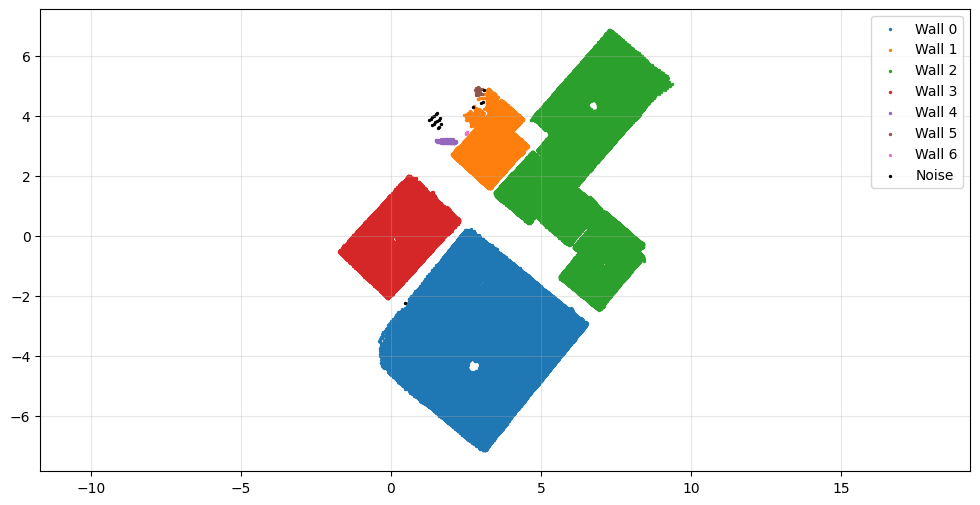

In [19]:
keep_clusters = []
plt.figure(figsize=(12, 6))
for cluster_id in set(ceiling_clusters):
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        label = f'Wall {cluster_id}'
        color = None
    
    mask = ceiling_clusters == cluster_id
    if sum(mask) > 0:
        keep_clusters.append(cluster_id)
        plt.scatter(ceiling_points_2d[mask, 0], ceiling_points_2d[mask, 1], 
                    s=2, label=label, c=color if color else None)

plt.axis('equal')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()

In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def segment_rooms_hierarchical(ceiling_2d, n_rooms=None, distance_threshold=1.0):
    """
    Use hierarchical clustering - better for rooms with narrow connections
    
    Args:
        ceiling_2d: Nx2 array of ceiling points
        n_rooms: Number of rooms (if known), or None
        distance_threshold: Distance to merge clusters
    """
    
    if n_rooms is not None:
        # If you know how many rooms
        clustering = AgglomerativeClustering(n_clusters=n_rooms)
        labels = clustering.fit_predict(ceiling_2d)
    else:
        # Let algorithm decide based on distance
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            linkage='ward'
        )
        labels = clustering.fit_predict(ceiling_2d)
    
    n_found = len(set(labels))
    print(f"Hierarchical clustering found {n_found} rooms")
    
    return labels

In [1]:
def detect_walls_ransac(pcd, gravity=np.array([0,0,1]),
                        dist_thresh=0.02,  # 2 cm tolerance
                        angle_thresh_deg=10,
                        min_inliers=2000,   # depends on your density
                        max_iter=20):

    walls = []
    remaining = pcd
    angle_thresh = np.deg2rad(angle_thresh_deg)

    for i in range(max_iter):
        if len(remaining.points) < min_inliers:
            break

        plane_model, inliers = remaining.segment_plane(
            distance_threshold=dist_thresh,
            ransac_n=3,
            num_iterations=1000
        )

        n = np.array(plane_model[:3])
        n /= np.linalg.norm(n)
        d = plane_model[3]

        # angle between normal and gravity
        angle = np.arccos(np.clip(np.abs(np.dot(n, gravity)), -1.0, 1.0))

        if abs(angle - np.pi/2) < angle_thresh:   # near-vertical plane
            walls.append({'normal': n, 'd': d, 'inliers': inliers})

        # remove inliers from cloud regardless
        mask = np.ones(len(remaining.points), dtype=bool)
        mask[inliers] = False
        remaining = remaining.select_by_index(np.where(mask)[0])

        if len(walls) > 20:
            break  # stop if too many planes found (optional)

    return walls

NameError: name 'np' is not defined

In [ ]:
labels

In [134]:
keep_clusters

[np.int64(0), np.int64(1), np.int64(3)]

In [146]:
mask = ceiling_clusters == keep_clusters[0]

In [147]:
sum(mask)

np.int64(22783)

In [148]:
coord = ceiling_points_2d[mask]

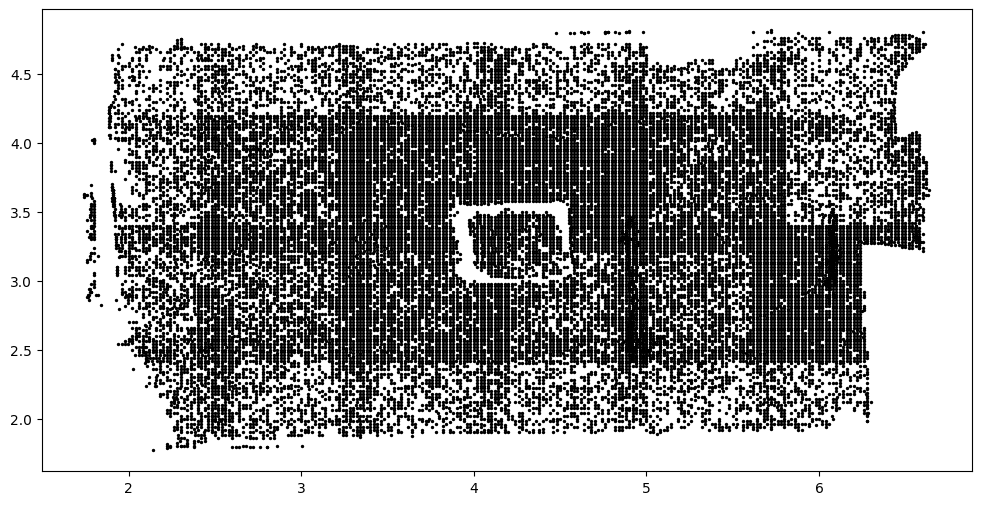

In [149]:
plt.figure(figsize=(12, 6))
plt.scatter(coord[:, 0], coord[:, 1], 
                    s=2, label=label, c=color if color else None)

In [144]:
def get_shape_dimensions_numpy(coordinates_array):
    if coordinates_array.size == 0:
        return 0, 0

    min_coords = np.min(coordinates_array, axis=0)
    max_coords = np.max(coordinates_array, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

In [145]:
get_shape_dimensions_numpy(coord)

(np.float64(4.670390605926514), np.float64(3.1399996876716614))

In [ ]:
def rotation_to_align(g, target=np.array([0.,0.,-1.])):
    g = g / np.linalg.norm(g)
    t = target / np.linalg.norm(target)
    c = np.dot(g, t)
    if np.isclose(c, 1.0):
        return np.eye(3)
    if np.isclose(c, -1.0):
        # 180-degree rotation: pick arbitrary orthogonal axis
        # find vector orthogonal to g
        if abs(g[0]) < abs(g[1]):
            axis = np.array([1.,0.,0.])
        else:
            axis = np.array([0.,1.,0.])
        v = np.cross(g, axis)
        v = v / np.linalg.norm(v)
        # Rodrigues with angle = pi
        K = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
        return np.eye(3) + 2*(K @ K)  # since sin(pi)=0, 1-cos(pi)=2 -> simplifies
    v = np.cross(g, t)
    K = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    R = np.eye(3) + K + K @ K * (1.0 / (1.0 + c))
    return R

# Example usage:
g = np.array([0.0036468, 0.0030084, -0.9999889])  # example gravity
R = rotation_to_align(g)
points_aligned = (points - points.mean(axis=0)) @ R.T  # center then rotate

np.int64(38)

In [ ]:
wall_indices = sem_seg.ransac_segmentor.segments['wall_pointnet']['indices']
# door_indices = sem_seg.ransac_segmentor.segments['door_pointnet']['indices']
# window_indices = sem_seg.ransac_segmentor.segments['window_pointnet']['indices']

print(f"Wall points: {len(wall_indices)}")
# print(f"Door points: {len(door_indices)}")
# print(f"Window points: {len(window_indices)}")

  

# Extract architectural points using indices
wall_points_2d = points_2d[wall_indices]
# door_points_2d = points_2d[door_indices]
# window_points_2d = points_2d[window_indices]

Wall points: 165476


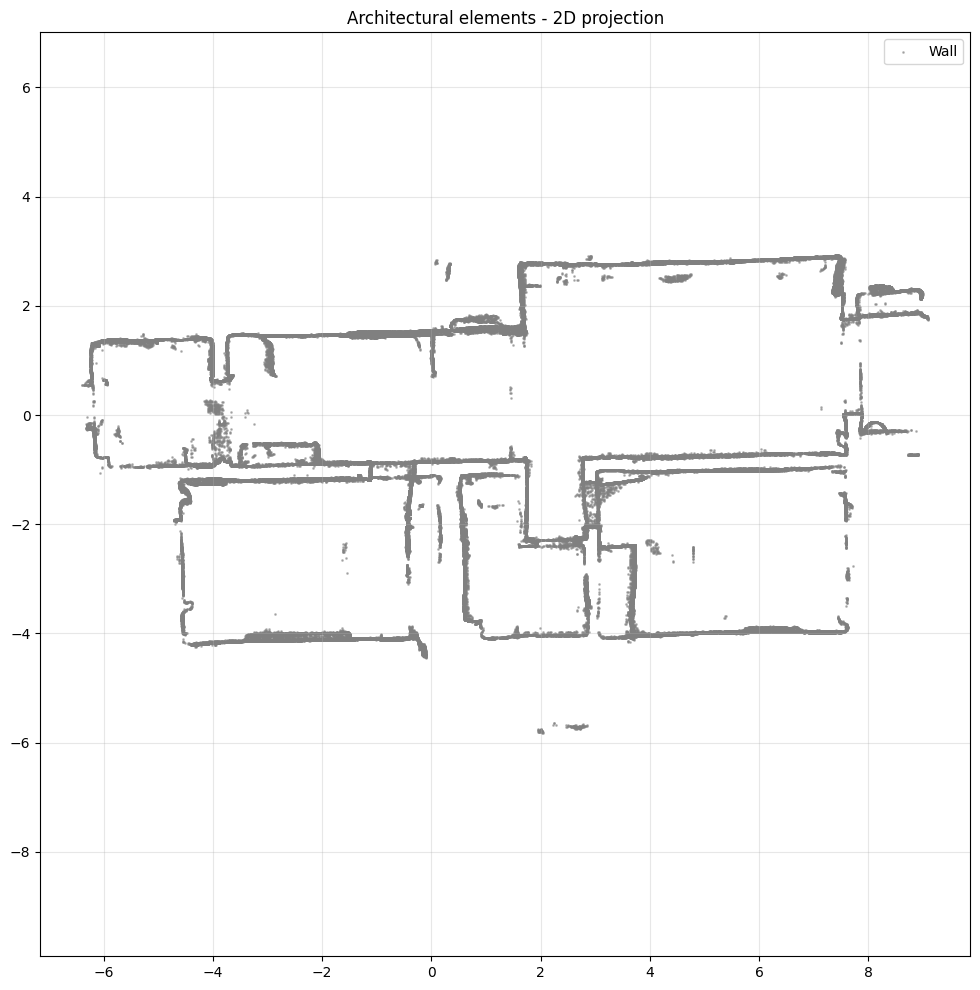

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
# plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [12]:
door_clusters = sem_seg.ransac_segmentor.cluster_points(door_indices, eps=0.5, )

In [13]:
for i, cluster in enumerate(door_clusters):
    print(i, len(cluster))

0 326
1 15
2 5062
3 12


In [14]:
door_indices_clustered = door_clusters[2]

In [15]:
wall_points_2d = points_2d[wall_indices]
door_points_2d = points_2d[door_indices_clustered]
# window_points_2d = points_2d[window_indices]

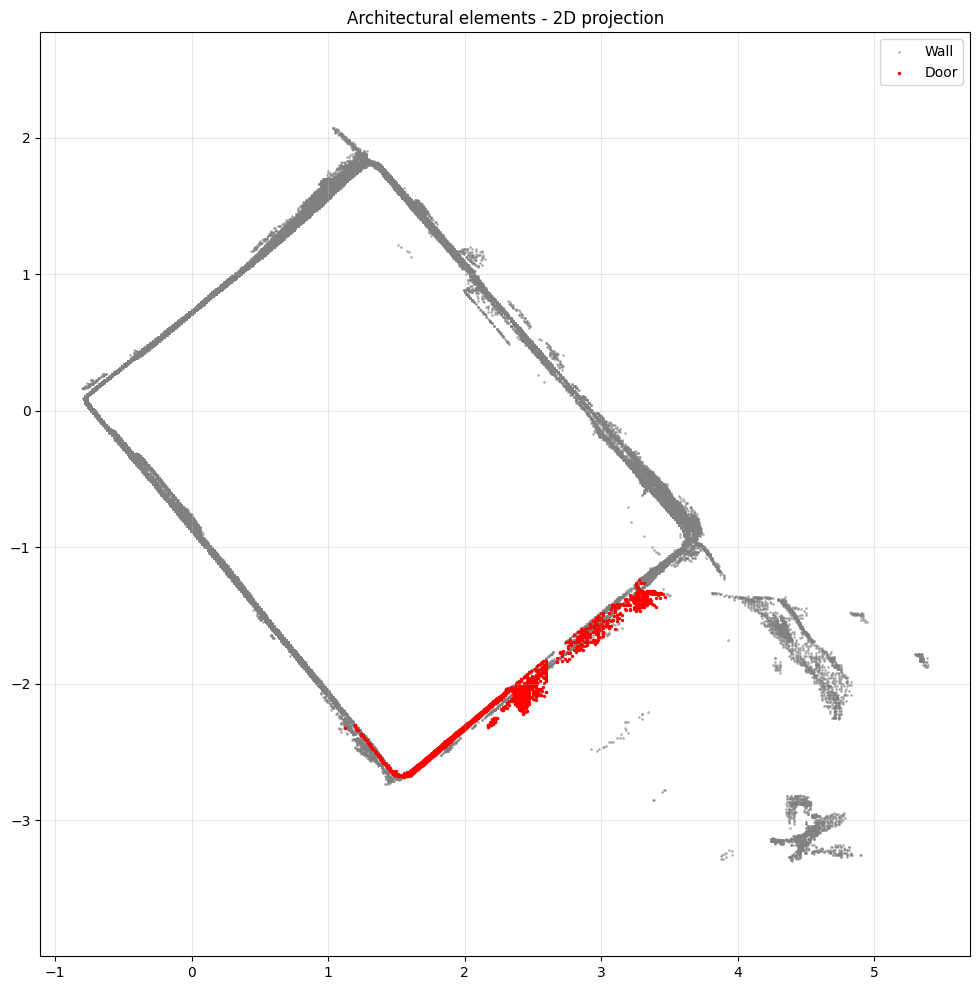

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(wall_points_2d[:, 0], wall_points_2d[:, 1], c='gray', s=1, label='Wall', alpha=0.5)
# plt.scatter(window_points_2d[:, 0], window_points_2d[:, 1], c='cyan', s=2, label='Window')
plt.scatter(door_points_2d[:, 0], door_points_2d[:, 1], c='red', s=2, label='Door')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Architectural elements - 2D projection')
plt.show()

In [34]:
segment_models = {}
segments_ransac = {}

epsilon = 0.15
min_cluster_points = 50
max_plane_idx = 30
distance_threshold = 0.1
rest = sem_seg.pcd
for i in range(max_plane_idx):
    # colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=distance_threshold, ransac_n=3, num_iterations=2000)
    segments_ransac[i] = rest.select_by_index(inliers)
    labels = np.array(segments_ransac[i].cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
    candidates = [len(np.where(labels == j)[0]) for j in np.unique(labels)]
    best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True) + segments_ransac[i].select_by_index(list(np.where(labels != best_candidate)[0]))
    segments_ransac[i] = segments_ransac[i].select_by_index(list(np.where(labels == best_candidate)[0]))
    colors = plt.get_cmap("tab20")(i)
    segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # segments_ransac[i].paint_uniform_color(list(colors[:3]))
    # rest = rest.select_by_index(inliers, invert=True)
    
    # print("pass", i, "/", max_plane_idx, "done.")

/var/folders/j4/yzpk21j93c5bl_mjst9qb4mc0000gn/T/ipykernel_28967/882629629.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_candidate = int(np.unique(labels)[np.where(candidates == np.max(candidates))[0]])


In [35]:
o3d.visualization.draw_geometries([segments_ransac[i] for i in range(max_plane_idx)])

In [36]:
sem_seg.visualize_pcd()